In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
# from random import randrangeD
# from torchsummary import summary
import os
import datetime

import sys
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from CoordConvModule import *

In [2]:
trainset = torch.load('../data/dataset_10steps.pt')

In [3]:
import datetime
dateTimeObj = datetime.datetime.now()
timestampStr = "Deeper_" + dateTimeObj.strftime("%d_%b_%Y_%H_%M")
if timestampStr not in os.listdir("../data/model/"):
    os.mkdir("../data/model/"+timestampStr)

In [4]:
epochs = 30
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 100, 100]
        # Output size: [batch, 3, 100, 100]
        self.encoder = nn.Sequential(
            CoordConv(3, 64, kernel_size = 1, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size = 5, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, 7, stride=1, padding=1),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 7, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 64, 5, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 3, 1, stride=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 9, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 8, 7, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.sigmoid(self.fc2(x))
        return x

In [8]:
class StepAE(nn.Module):
    def __init__(self):
        """Variational Auto-Encoder Class"""
        super(StepAE, self).__init__()
        
        self.enc = Autoencoder()

    def step(self, x): # For actual run after training
        x = self.enc(x)
        return x

    def forward(self, x): # For training
        recon1 = self.enc(x)
        recon2 = self.enc(recon1)
        recon3 = self.enc(recon2)
        recon4 = self.enc(recon3)
        
        return recon1, recon2, recon3, recon4

# Training

In [9]:
disc_history_real = []
disc_history_fake = []
rme_history = []

In [10]:
# https://uos-deep-learning.tistory.com/16
def calc_gradient_penalty(netD, real_data, generated_data):
    # GP strength
    LAMBDA = 5

    b_size = real_data.size()[0]

    # Calculate interpolation
    alpha = torch.rand(b_size, 1, 1, 1)
    alpha = alpha.expand_as(real_data)
    alpha = alpha.cuda()

    interpolated = alpha * real_data.data + (1 - alpha) * generated_data.data
    interpolated = torch.autograd.Variable(interpolated, requires_grad=True)
    interpolated = interpolated.cuda()

    # Calculate probability of interpolated examples
    prob_interpolated = netD(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                           create_graph=True, retain_graph=True)[0]

    # Gradients have shape (batch_size, num_channels, img_width, img_height),
    # so flatten to easily take norm per example in batch
    gradients = gradients.view(b_size, -1)

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

    # Return gradient penalty
    return LAMBDA * ((gradients_norm - 1) ** 2).mean()

In [11]:
def train(model, discnet, train_loader, epochnow):
    model.train()
    discnet.train()
    avg_loss = 0
    for step, (x0, _, x1, _, x2, _, x3, _, x4, _) in enumerate(train_loader):
        del _

        x0 = x0.permute(0, 3, 1, 2)
        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)
        x3 = x3.permute(0, 3, 1, 2)
        x4 = x4.permute(0, 3, 1, 2)

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))
        discnet.train()
        discnet.zero_grad()
        optimizerD.zero_grad()
        r1, r2, r3, r4 = model(x0.cuda())
        
        # All real
        label_size = x1.size(0)
        real_label = 1
        label = torch.full((label_size,), real_label, dtype=torch.float, device=device)       
        for idx, x_ in enumerate([x1, x2, x3, x4]):
            output = discnet(x_.cuda()).view(-1)
            if idx == 0:
                errD_real = criterionD(output, label)
            else:
                errD_real += criterionD(output, label)
        errD_real.backward()
        out_real = output.detach().cpu().numpy()

        # All fake
        fake_label = 0
        label.fill_(fake_label)
        for idx, r_ in enumerate([r1, r2, r3, r4]):
            output = discnet(r_.detach().contiguous()).view(-1)
            if idx == 0:
                errD_fake = criterionD(output, label)
            else:
                errD_fake += criterionD(output, label)
        errD_fake.backward()

        grad_penalty = calc_gradient_penalty(netD, x1.cuda(), r1)
        grad_penalty += calc_gradient_penalty(netD, x2.cuda(), r2)
        grad_penalty += calc_gradient_penalty(netD, x3.cuda(), r3)
        grad_penalty += calc_gradient_penalty(netD, x4.cuda(), r4)
        grad_penalty = 1*grad_penalty
        grad_penalty.backward()

        if epochnow > 1:
            optimizerD.step()
        del r1, r2, r3, r4

        if step > 50:
            break

    for step, (x0, _, x1, _, x2, _, x3, _, x4, _) in enumerate(train_loader):
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        # model.train()
        discnet.eval()
        optimizer.zero_grad()
        model.zero_grad()

        r1, r2, r3, r4 = model(x0.cuda())
        label.fill_(real_label)
        for idx, r_ in enumerate([r1, r2, r3, r4]):
            output = discnet(r_.detach().contiguous()).view(-1)
            if idx == 0:
                errG = criterionD(output, label)
            else:
                errG += criterionD(output, label)

        loss1 = criterion(r1, x1.cuda())
        loss2 = criterion(r2, x2.cuda())
        loss3 = criterion(r3, x3.cuda())
        loss4 = criterion(r4, x4.cuda())
        loss = 10*(loss1 + loss2 + loss3 + loss4) + errG
        
        del x0, x1, x2, x3, x4, r1, r2, r3, r4

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
        loss_history.append(loss.item())

        if step%10 == 0:
            print("step{}, loss = {}, real = {}, fake = {}".format(step, loss, np.mean(out_real), (output.mean().item())), errG.mean().item())
            disc_history_real.append([out_real])
            disc_history_fake.append([output.detach().cpu().numpy()])

        if step%100 == 0:
            # sys.stdout = open(os.devnull, 'w')
            figplot(epochnow, step)
            torch.save(model_origin.state_dict(), "../data/model/" + timestampStr + "/CConv_stepwise_ep{}_{}.pt".format(epochnow, step))
            torch.save(netD.state_dict(), "../data/model/" + timestampStr + "/CConv_discnet_ep{}_{}.pt".format(epochnow, step))
            torch.save(model_origin.state_dict(), "latest_deeper_net.pt".format(epochnow, step))
            torch.save(netD.state_dict(), "latest_deeper_disc.pt".format(epochnow, step))
            np.save("../data/model/" + timestampStr +"/disc_history_fake", disc_history_fake)
            np.save("../data/model/" + timestampStr +"/disc_history_real", disc_history_real)
            np.save("../data/model/" + timestampStr +"/loss_history", loss_history)
            # sys.stdout = sys.__stdout__

    return avg_loss / len(train_loader)

In [12]:
netD = Discriminator().to(device)
optimizerD = optim.Adam(netD.parameters(), lr=0.0001)
criterionD = nn.BCEWithLogitsLoss()

In [13]:
model_origin = StepAE().to(device)
# model_origin.load_state_dict(torch.load("Deeper_net.pt"))
criterion = nn.MSELoss()
loss_history = []

In [14]:
oneloader = DataLoader(trainset, batch_size=1, shuffle=True)
torch.cuda.empty_cache()

def figplot(epochnow, step):
    model_origin.eval()
    dataiter = iter(oneloader)
    images, *_ = dataiter.next()
    del _

    recon, *_ = model_origin(images.permute(0, 3, 1, 2).cuda())

    del _
    torch.cuda.empty_cache()
    # get sample outputs

    steps = 100
    skip = int(steps/10)
    plt.figure(figsize=(6, 20))
    ii = 0
    for i in range(steps):
        recon, *_ = model_origin(recon)
        del _
        
        if i%skip == 0:
            ii+=1
            ax = plt.subplot(10, 1, ii + 0)
            # print(i)
            # output is resized into a batch of iages
            # use detach when it's an output that requires_grad
            output = recon.detach().view(1, 3, 100, 100).cpu()[0].permute(1, 2, 0)
            # print(output.min(), output.max())
            plt.imshow(output)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            del output
            torch.cuda.empty_cache()
    plt.savefig("../data/model/"+timestampStr+"/fig_{}_{}.png".format(epochnow, step))
    torch.save(images, "../data/model/"+timestampStr+"/input_{}_{}.pt".format(epochnow,step))
    del images
    del recon
    del dataiter

/home/sbin-home/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 11.155263900756836, real = 0.501221776008606, fake = 0.49507686495780945 1.9037537574768066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 9.1620454788208, real = 0.49501827359199524, fake = 0.4969102442264557 1.9012082815170288
step20, loss = 6.232766628265381, real = 0.49698406457901, fake = 0.49749472737312317 1.8997527360916138
step30, loss = 5.826940536499023, real = 0.497153103351593, fake = 0.4966474771499634 1.9013354778289795
step40, loss = 6.614657878875732, real = 0.4993155598640442, fake = 0.4974759817123413 1.8999351263046265
step50, loss = 5.473586082458496, real = 0.5009991526603699, fake = 0.4986962378025055 1.898397445678711
step60, loss = 4.901409149169922, real = 0.4980568587779999, fake = 0.49793052673339844 1.8994133472442627
step70, loss = 5.096234321594238, real = 0.493137001991272, fake = 0.49699193239212036 1.9006739854812622
step80, loss = 4.66969108581543, real = 0.5007187128067017, fake = 0.4987837076187134 1.8978843688964844
step90, loss = 4.443997383117676, real = 0.49432045221328735, fake = 0.49649471044540405 1.9012751579284668


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 4.693872451782227, real = 0.4976172149181366, fake = 0.4992942214012146 1.8970985412597656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 4.0418829917907715, real = 0.49712538719177246, fake = 0.4989480674266815 1.897956371307373
step120, loss = 3.8584024906158447, real = 0.5017937421798706, fake = 0.4990580081939697 1.8978149890899658
step130, loss = 4.073414325714111, real = 0.49777543544769287, fake = 0.49950581789016724 1.8969707489013672
step140, loss = 4.430830001831055, real = 0.49656450748443604, fake = 0.4966968894004822 1.900963306427002
step150, loss = 4.310329914093018, real = 0.4989302158355713, fake = 0.4990890622138977 1.8977843523025513
step160, loss = 3.9084572792053223, real = 0.4987611174583435, fake = 0.5000577569007874 1.8962546586990356
step170, loss = 4.828263759613037, real = 0.5025854110717773, fake = 0.4995420575141907 1.8971242904663086
step180, loss = 3.6957321166992188, real = 0.49804621934890747, fake = 0.49784615635871887 1.8992893695831299
step190, loss = 4.013150215148926, real = 0.494376003742218, fake = 0.4985140860080719 1.8989191055297852
step200, loss = 3.873430967330

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

step210, loss = 3.955782175064087, real = 0.5001060962677002, fake = 0.49884021282196045 1.8981008529663086
step220, loss = 4.530775547027588, real = 0.499202698469162, fake = 0.4997527599334717 1.8969166278839111
step230, loss = 5.074976444244385, real = 0.4987393319606781, fake = 0.4986993670463562 1.898344874382019
step240, loss = 4.4805707931518555, real = 0.5019944310188293, fake = 0.498914510011673 1.8978428840637207
step250, loss = 3.9627110958099365, real = 0.5024542808532715, fake = 0.49965620040893555 1.8968966007232666
step260, loss = 3.976285457611084, real = 0.5001623630523682, fake = 0.5004109740257263 1.8958067893981934
step270, loss = 3.570578098297119, real = 0.4984210431575775, fake = 0.49978482723236084 1.8969234228134155
step280, loss = 3.556377410888672, real = 0.5000473260879517, fake = 0.49942681193351746 1.8972344398498535
step290, loss = 4.1884260177612305, real = 0.4982786774635315, fake = 0.49791938066482544 1.8994683027267456
step300, loss = 3.14128112792968

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

step310, loss = 3.4698824882507324, real = 0.4976935386657715, fake = 0.4998459815979004 1.8962633609771729
step320, loss = 3.4843358993530273, real = 0.5018884539604187, fake = 0.5000947117805481 1.8963228464126587
step330, loss = 3.7720608711242676, real = 0.5018736124038696, fake = 0.4998141825199127 1.8966898918151855
step340, loss = 3.5979249477386475, real = 0.5006511211395264, fake = 0.5003900527954102 1.8961124420166016
step350, loss = 3.6282758712768555, real = 0.49811452627182007, fake = 0.4985837936401367 1.8985297679901123
step360, loss = 3.519846200942993, real = 0.49730411171913147, fake = 0.4991527199745178 1.897291898727417
step370, loss = 3.2730495929718018, real = 0.5001993179321289, fake = 0.49825984239578247 1.899195671081543
step380, loss = 3.43184757232666, real = 0.5006405115127563, fake = 0.49813422560691833 1.8991641998291016
step390, loss = 4.4719061851501465, real = 0.49830618500709534, fake = 0.49653160572052 1.9017568826675415


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 3.568816900253296, real = 0.49772876501083374, fake = 0.4989805519580841 1.8978188037872314


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 3.5008277893066406, real = 0.49990153312683105, fake = 0.4993864893913269 1.8974703550338745
step420, loss = 3.2634377479553223, real = 0.49837079644203186, fake = 0.4987446665763855 1.8984522819519043
step430, loss = 3.8088791370391846, real = 0.49960094690322876, fake = 0.4975334405899048 1.8998502492904663
step440, loss = 3.26247501373291, real = 0.49478963017463684, fake = 0.4978219270706177 1.8994261026382446
step450, loss = 4.1599836349487305, real = 0.5000592470169067, fake = 0.4990924000740051 1.8975956439971924
step460, loss = 3.383192777633667, real = 0.49813926219940186, fake = 0.498045414686203 1.8992230892181396
step470, loss = 3.4817676544189453, real = 0.5037496089935303, fake = 0.5000642538070679 1.8962565660476685
step480, loss = 3.2970314025878906, real = 0.49736636877059937, fake = 0.49718591570854187 1.9005720615386963
step490, loss = 3.6173477172851562, real = 0.4956461191177368, fake = 0.49865514039993286 1.898118257522583


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 3.2046658992767334, real = 0.4992343485355377, fake = 0.49889394640922546 1.8983656167984009


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 3.244469404220581, real = 0.4983559250831604, fake = 0.5003423690795898 1.8959017992019653
step520, loss = 4.03657341003418, real = 0.4952049255371094, fake = 0.49913254380226135 1.8975412845611572
step530, loss = 3.212137222290039, real = 0.49779653549194336, fake = 0.49771246314048767 1.9000648260116577
step540, loss = 3.431934356689453, real = 0.5033590197563171, fake = 0.49964842200279236 1.8967742919921875
step550, loss = 3.3833744525909424, real = 0.49962031841278076, fake = 0.49921372532844543 1.8975695371627808
step560, loss = 4.025236129760742, real = 0.4970410466194153, fake = 0.49771127104759216 1.8997176885604858
step570, loss = 3.2887372970581055, real = 0.49910271167755127, fake = 0.49891403317451477 1.898390769958496
step580, loss = 3.7760114669799805, real = 0.4969678521156311, fake = 0.49933260679244995 1.897358775138855
step590, loss = 3.3975086212158203, real = 0.497452050447464, fake = 0.49746859073638916 1.9002940654754639


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 3.162203788757324, real = 0.4953279495239258, fake = 0.49688026309013367 1.900589942932129


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 3.226959228515625, real = 0.49545973539352417, fake = 0.4979628026485443 1.8989566564559937
step620, loss = 3.1116857528686523, real = 0.49912765622138977, fake = 0.49920326471328735 1.8973082304000854
step630, loss = 3.03273344039917, real = 0.4981071352958679, fake = 0.4977439045906067 1.9000438451766968
step640, loss = 3.315786600112915, real = 0.4995044767856598, fake = 0.49966752529144287 1.896824836730957
step650, loss = 3.279128074645996, real = 0.49942076206207275, fake = 0.49780625104904175 1.8997443914413452
step660, loss = 3.33642315864563, real = 0.49968039989471436, fake = 0.5000885725021362 1.8958027362823486
step670, loss = 3.3403353691101074, real = 0.49695467948913574, fake = 0.5001059770584106 1.8962956666946411
step680, loss = 3.5220463275909424, real = 0.4990384578704834, fake = 0.4997606873512268 1.8965914249420166
step690, loss = 3.1089224815368652, real = 0.49628937244415283, fake = 0.49812161922454834 1.899599552154541


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 3.1886088848114014, real = 0.5001482367515564, fake = 0.499140202999115 1.8977665901184082


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 3.959038257598877, real = 0.49776601791381836, fake = 0.49683263897895813 1.9014219045639038
step720, loss = 3.2716856002807617, real = 0.4974227547645569, fake = 0.49863770604133606 1.8981623649597168
step730, loss = 3.2018802165985107, real = 0.4999886751174927, fake = 0.4984589219093323 1.8989408016204834
step740, loss = 3.1645920276641846, real = 0.4992568790912628, fake = 0.5003707408905029 1.8956258296966553
step750, loss = 3.263392925262451, real = 0.5001731514930725, fake = 0.49882110953330994 1.8983594179153442
step760, loss = 3.9194822311401367, real = 0.498080849647522, fake = 0.4981030821800232 1.8994628190994263
step770, loss = 3.3921890258789062, real = 0.4986588954925537, fake = 0.49954459071159363 1.897458791732788
step780, loss = 3.2255566120147705, real = 0.4988706111907959, fake = 0.49795717000961304 1.8995310068130493
step790, loss = 3.6005237102508545, real = 0.5005576610565186, fake = 0.49989959597587585 1.8965299129486084


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 3.2029833793640137, real = 0.49767211079597473, fake = 0.498235285282135 1.8991435766220093


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 3.2872581481933594, real = 0.49825891852378845, fake = 0.49931132793426514 1.8973579406738281
step820, loss = 3.281829833984375, real = 0.502532958984375, fake = 0.4991125464439392 1.8979465961456299
step830, loss = 3.065783977508545, real = 0.49699634313583374, fake = 0.49863138794898987 1.8984944820404053
step840, loss = 3.6803736686706543, real = 0.4963681697845459, fake = 0.498819500207901 1.8984777927398682
step850, loss = 3.6092352867126465, real = 0.49891895055770874, fake = 0.49864012002944946 1.8982293605804443
step860, loss = 3.2388405799865723, real = 0.49841588735580444, fake = 0.5000397562980652 1.8961446285247803
step870, loss = 3.158247470855713, real = 0.496064692735672, fake = 0.4982229471206665 1.8991029262542725
step880, loss = 4.075188159942627, real = 0.5007369518280029, fake = 0.49856022000312805 1.8984119892120361
step890, loss = 3.6185219287872314, real = 0.49934569001197815, fake = 0.4982360601425171 1.8991411924362183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 3.322934865951538, real = 0.5005828142166138, fake = 0.4989228844642639 1.8982408046722412


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 3.2627146244049072, real = 0.49927589297294617, fake = 0.49936389923095703 1.8972373008728027
step920, loss = 3.1586215496063232, real = 0.4986463189125061, fake = 0.4998790919780731 1.8969879150390625
step930, loss = 3.1893773078918457, real = 0.49815911054611206, fake = 0.49851635098457336 1.8983981609344482
step940, loss = 3.6602110862731934, real = 0.5012648701667786, fake = 0.4981808066368103 1.8994131088256836
step950, loss = 3.888763904571533, real = 0.4994102418422699, fake = 0.49880945682525635 1.8983250856399536
step960, loss = 3.151871681213379, real = 0.49827250838279724, fake = 0.4989515542984009 1.8981642723083496
step970, loss = 3.4558804035186768, real = 0.5011035203933716, fake = 0.4997974634170532 1.8963655233383179
step980, loss = 3.330291748046875, real = 0.4994766116142273, fake = 0.5001751780509949 1.896317720413208
step990, loss = 3.13057541847229, real = 0.49577635526657104, fake = 0.4991825819015503 1.8977086544036865


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 3.157376289367676, real = 0.5001782178878784, fake = 0.4991724491119385 1.897599697113037


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 3.2890443801879883, real = 0.5032570362091064, fake = 0.5002455711364746 1.8964396715164185
step1020, loss = 2.9521701335906982, real = 0.4982694983482361, fake = 0.4973103404045105 1.900284767150879
step1030, loss = 3.875927448272705, real = 0.49835702776908875, fake = 0.49897533655166626 1.8979132175445557
step1040, loss = 3.0202269554138184, real = 0.499482125043869, fake = 0.4972672462463379 1.9004871845245361
step1050, loss = 3.0332655906677246, real = 0.5002868175506592, fake = 0.4980187714099884 1.899545669555664
step1060, loss = 3.1611666679382324, real = 0.5018692016601562, fake = 0.49926960468292236 1.8974939584732056
step1070, loss = 3.5685970783233643, real = 0.4985272288322449, fake = 0.49727943539619446 1.9005441665649414
step1080, loss = 3.5691046714782715, real = 0.49552661180496216, fake = 0.4966834485530853 1.9016674757003784
step1090, loss = 2.9803385734558105, real = 0.5016765594482422, fake = 0.4979284405708313 1.8996427059173584


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 3.414346218109131, real = 0.5004113912582397, fake = 0.4990656077861786 1.8980894088745117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 3.0211024284362793, real = 0.4997636675834656, fake = 0.5000280141830444 1.8962262868881226
step1120, loss = 3.035342216491699, real = 0.4941282868385315, fake = 0.4973944127559662 1.9002907276153564
step1130, loss = 3.118821144104004, real = 0.49751225113868713, fake = 0.5004174709320068 1.8960394859313965
step1140, loss = 3.765430450439453, real = 0.49966925382614136, fake = 0.49933505058288574 1.8972223997116089
step1150, loss = 3.0828728675842285, real = 0.4981352686882019, fake = 0.498881071805954 1.8984267711639404
step1160, loss = 3.352748155593872, real = 0.498016357421875, fake = 0.4978514611721039 1.8997639417648315
step1170, loss = 2.9174771308898926, real = 0.500961422920227, fake = 0.4980059266090393 1.8992116451263428
step1180, loss = 3.252274990081787, real = 0.49980130791664124, fake = 0.49733051657676697 1.9002711772918701
step1190, loss = 3.17283034324646, real = 0.4970742464065552, fake = 0.49911585450172424 1.8976287841796875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 3.5563066005706787, real = 0.5019088387489319, fake = 0.49792587757110596 1.8994901180267334


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 3.813804864883423, real = 0.4974033832550049, fake = 0.49765509366989136 1.9000585079193115
step1220, loss = 3.383392810821533, real = 0.5018628835678101, fake = 0.5003213882446289 1.8961615562438965
step1230, loss = 3.29378604888916, real = 0.5009932518005371, fake = 0.5011917352676392 1.894665002822876
step1240, loss = 3.0695080757141113, real = 0.5001410245895386, fake = 0.49805426597595215 1.8992693424224854
step1250, loss = 2.7868640422821045, real = 0.5008398294448853, fake = 0.49808329343795776 1.8989136219024658
step1260, loss = 3.4515221118927, real = 0.49648064374923706, fake = 0.497240275144577 1.9007580280303955
step1270, loss = 3.6273679733276367, real = 0.49694350361824036, fake = 0.4983539283275604 1.8992235660552979
step1280, loss = 3.2800955772399902, real = 0.4981316328048706, fake = 0.4971765875816345 1.9005730152130127
step1290, loss = 3.6451406478881836, real = 0.5023027658462524, fake = 0.500347912311554 1.8955726623535156


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 3.019524574279785, real = 0.5003986954689026, fake = 0.49787241220474243 1.8997154235839844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 2.98508882522583, real = 0.4998587369918823, fake = 0.4996553659439087 1.8971102237701416
step1320, loss = 3.0290369987487793, real = 0.49663764238357544, fake = 0.49880075454711914 1.8978722095489502
step1330, loss = 3.5914807319641113, real = 0.5003660321235657, fake = 0.49977073073387146 1.8969041109085083
step1340, loss = 2.819153308868408, real = 0.4985100328922272, fake = 0.49873098731040955 1.8982353210449219
step1350, loss = 3.0016825199127197, real = 0.49966520071029663, fake = 0.4981101453304291 1.8992199897766113
step1360, loss = 2.958847761154175, real = 0.5028151273727417, fake = 0.4986305236816406 1.8986940383911133
step1370, loss = 3.1805036067962646, real = 0.49730384349823, fake = 0.4978857636451721 1.8994417190551758
step1380, loss = 3.4113011360168457, real = 0.4994335174560547, fake = 0.4972354769706726 1.9007123708724976
step1390, loss = 4.0288214683532715, real = 0.50131756067276, fake = 0.4995070695877075 1.8970597982406616


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 2.979980945587158, real = 0.4950041174888611, fake = 0.4971941113471985 1.9007136821746826


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 3.1348421573638916, real = 0.4985886812210083, fake = 0.4982547163963318 1.8987996578216553
step1420, loss = 3.0269999504089355, real = 0.5010867118835449, fake = 0.4984852075576782 1.898869514465332
step1430, loss = 3.114189624786377, real = 0.49851927161216736, fake = 0.49739888310432434 1.9003682136535645
step1440, loss = 4.49354362487793, real = 0.5004217624664307, fake = 0.49703124165534973 1.900848388671875
step1450, loss = 3.5914735794067383, real = 0.49458688497543335, fake = 0.4979367256164551 1.8994414806365967
step1460, loss = 3.0479860305786133, real = 0.4952359199523926, fake = 0.49880802631378174 1.8981480598449707
step1470, loss = 3.1481080055236816, real = 0.4992408752441406, fake = 0.5000460147857666 1.8964205980300903
step1480, loss = 3.726212501525879, real = 0.49926236271858215, fake = 0.4991404116153717 1.897597074508667
step1490, loss = 2.9631123542785645, real = 0.497343510389328, fake = 0.4981376528739929 1.8990342617034912


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 2.9494681358337402, real = 0.502377986907959, fake = 0.49787384271621704 1.8997182846069336


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 3.2318501472473145, real = 0.5021094679832458, fake = 0.500234842300415 1.895792007446289
step1520, loss = 3.463073253631592, real = 0.499666690826416, fake = 0.4980960488319397 1.8990998268127441
step1530, loss = 2.8089635372161865, real = 0.5004575252532959, fake = 0.49822330474853516 1.898712158203125
step1540, loss = 3.453143358230591, real = 0.500077486038208, fake = 0.4989519715309143 1.897937297821045
step1550, loss = 2.7233448028564453, real = 0.5000326633453369, fake = 0.49962329864501953 1.8966901302337646
step1560, loss = 3.7177958488464355, real = 0.5002611875534058, fake = 0.5005455613136292 1.8956269025802612
step1570, loss = 2.9995970726013184, real = 0.4992152750492096, fake = 0.4992382526397705 1.8975428342819214
step1580, loss = 2.9245247840881348, real = 0.4964640736579895, fake = 0.49851706624031067 1.8986294269561768
step1590, loss = 3.098109245300293, real = 0.5015712380409241, fake = 0.5007168650627136 1.8953090906143188


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 2.913395643234253, real = 0.5005993247032166, fake = 0.4984898269176483 1.8986634016036987


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 2.9021122455596924, real = 0.4985591173171997, fake = 0.49993136525154114 1.8958675861358643
step1620, loss = 2.9976377487182617, real = 0.4986032545566559, fake = 0.4987248182296753 1.8986002206802368
step1630, loss = 3.2535486221313477, real = 0.4954518675804138, fake = 0.49736595153808594 1.9004523754119873
step1640, loss = 3.4521219730377197, real = 0.5021824836730957, fake = 0.49916619062423706 1.8972241878509521
step1650, loss = 3.5621602535247803, real = 0.4993540048599243, fake = 0.4990807771682739 1.8975775241851807
step1660, loss = 2.8436691761016846, real = 0.49897563457489014, fake = 0.4986967444419861 1.898484706878662
step1670, loss = 2.7560386657714844, real = 0.49940699338912964, fake = 0.49768394231796265 1.899710774421692
step1680, loss = 2.963414430618286, real = 0.4964457154273987, fake = 0.4968317151069641 1.9013408422470093
step1690, loss = 2.832226037979126, real = 0.49884283542633057, fake = 0.4986248314380646 1.8987334966659546


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 3.1189932823181152, real = 0.5007792711257935, fake = 0.49846574664115906 1.8985369205474854


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 2.877669334411621, real = 0.4998679757118225, fake = 0.49901479482650757 1.897668480873108
step1720, loss = 3.777923107147217, real = 0.49554386734962463, fake = 0.49779146909713745 1.8996527194976807
step1730, loss = 2.783968687057495, real = 0.4969678521156311, fake = 0.4982234835624695 1.8989768028259277
step1740, loss = 3.4224610328674316, real = 0.49883365631103516, fake = 0.49772512912750244 1.899552822113037
step1750, loss = 2.8915514945983887, real = 0.5012619495391846, fake = 0.500243604183197 1.896090030670166
step1760, loss = 2.712476968765259, real = 0.49939078092575073, fake = 0.4984111785888672 1.8986512422561646
step1770, loss = 2.7301149368286133, real = 0.4976673424243927, fake = 0.4989628195762634 1.897728443145752
step1780, loss = 3.0269014835357666, real = 0.4961201548576355, fake = 0.49868232011795044 1.89862060546875
step1790, loss = 2.8156957626342773, real = 0.4961865544319153, fake = 0.498332142829895 1.898975133895874


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 3.2006425857543945, real = 0.5004695653915405, fake = 0.49787524342536926 1.8999638557434082


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.113811492919922, real = 0.4988032281398773, fake = 0.49835023283958435 1.8990044593811035
step1820, loss = 2.8727989196777344, real = 0.501391589641571, fake = 0.4987797737121582 1.8982841968536377
step1830, loss = 2.91040301322937, real = 0.5011855959892273, fake = 0.4990605413913727 1.8979053497314453
[Epoch 1] loss:3.4983244478149746


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 3.4488422870635986, real = 0.5020896196365356, fake = 0.4959975481033325 1.9024230241775513


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 2.6852145195007324, real = 0.473969042301178, fake = 0.4713871479034424 1.9401805400848389
step20, loss = 3.0474510192871094, real = 0.43121612071990967, fake = 0.4380074739456177 1.9934210777282715
step30, loss = 2.8485913276672363, real = 0.43595558404922485, fake = 0.44324278831481934 1.9826395511627197
step40, loss = 3.751342535018921, real = 0.4569411277770996, fake = 0.4666045904159546 1.9507637023925781
step50, loss = 2.8665878772735596, real = 0.49270665645599365, fake = 0.48758381605148315 1.9155830144882202
step60, loss = 3.1977922916412354, real = 0.4911877512931824, fake = 0.4813152551651001 1.9260146617889404
step70, loss = 2.7564687728881836, real = 0.4967386722564697, fake = 0.4904489517211914 1.9161709547042847
step80, loss = 2.881844997406006, real = 0.481988787651062, fake = 0.48214882612228394 1.9224967956542969
step90, loss = 2.93346905708313, real = 0.4773770570755005, fake = 0.4820411205291748 1.9224004745483398


/tmp/ipykernel_3454604/2056485379.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6, 20))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 3.112415313720703, real = 0.49230140447616577, fake = 0.48291367292404175 1.9213500022888184


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 2.6958789825439453, real = 0.4878111481666565, fake = 0.48548203706741333 1.917572021484375
step120, loss = 2.7257437705993652, real = 0.48031744360923767, fake = 0.4806463122367859 1.92555570602417
step130, loss = 2.979034900665283, real = 0.49072009325027466, fake = 0.48095402121543884 1.9245864152908325
step140, loss = 3.014474868774414, real = 0.4834102988243103, fake = 0.4807974398136139 1.9260361194610596
step150, loss = 2.8766045570373535, real = 0.48030808568000793, fake = 0.4734794795513153 1.9358991384506226
step160, loss = 2.752272129058838, real = 0.491699755191803, fake = 0.47872117161750793 1.9308042526245117
step170, loss = 3.281723976135254, real = 0.5821084976196289, fake = 0.5644928812980652 1.8158361911773682
step180, loss = 3.5684456825256348, real = 0.6022144556045532, fake = 0.5731360912322998 1.8053749799728394
step190, loss = 3.0384480953216553, real = 0.5329004526138306, fake = 0.5138939619064331 1.8786258697509766


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 2.9598119258880615, real = 0.4629570245742798, fake = 0.4122670292854309 2.0397918224334717


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 3.386113166809082, real = 0.24455526471138, fake = 0.20281600952148438 2.403482437133789
step220, loss = 2.9658591747283936, real = 0.3396425247192383, fake = 0.3506114184856415 2.1399099826812744
step230, loss = 3.4735498428344727, real = 0.42524194717407227, fake = 0.4145892858505249 2.0258946418762207
step240, loss = 2.9602909088134766, real = 0.4392699599266052, fake = 0.4252292513847351 2.0111429691314697
step250, loss = 2.838261127471924, real = 0.45724260807037354, fake = 0.43507933616638184 1.9927809238433838
step260, loss = 2.8339240550994873, real = 0.4410756826400757, fake = 0.4252582788467407 2.013198137283325
step270, loss = 3.397378921508789, real = 0.4256870448589325, fake = 0.42244860529899597 2.018928289413452
step280, loss = 2.7963356971740723, real = 0.428401380777359, fake = 0.4230048954486847 2.014130115509033
step290, loss = 3.11659574508667, real = 0.39886030554771423, fake = 0.3993510603904724 2.056035041809082


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 3.0036706924438477, real = 0.38072991371154785, fake = 0.38163813948631287 2.0847017765045166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.414299964904785, real = 0.36563754081726074, fake = 0.36259520053863525 2.111135244369507
step320, loss = 2.9392426013946533, real = 0.3687150478363037, fake = 0.3594604730606079 2.1221256256103516
step330, loss = 3.1449198722839355, real = 0.34523889422416687, fake = 0.34710150957107544 2.1429965496063232
step340, loss = 3.0874826908111572, real = 0.32873815298080444, fake = 0.324380099773407 2.1765284538269043
step350, loss = 3.195207118988037, real = 0.31542646884918213, fake = 0.3131728172302246 2.191049337387085
step360, loss = 3.010617256164551, real = 0.27895307540893555, fake = 0.2665979266166687 2.277256965637207
step370, loss = 3.150857925415039, real = 0.2740533947944641, fake = 0.2582668364048004 2.286065101623535
step380, loss = 3.116945505142212, real = 0.2591351866722107, fake = 0.2345488965511322 2.3313214778900146
step390, loss = 3.2144839763641357, real = 0.2514093816280365, fake = 0.23099088668823242 2.338555335998535


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 3.552485466003418, real = 0.2006518840789795, fake = 0.20923402905464172 2.3754467964172363


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 3.2860331535339355, real = 0.22051216661930084, fake = 0.19939923286437988 2.389401435852051
step420, loss = 3.3271877765655518, real = 0.23094935715198517, fake = 0.21672086417675018 2.36356258392334
step430, loss = 3.346129894256592, real = 0.21309059858322144, fake = 0.19409102201461792 2.4045305252075195
step440, loss = 3.2324602603912354, real = 0.19802094995975494, fake = 0.20551906526088715 2.384455680847168
step450, loss = 3.2527105808258057, real = 0.17737263441085815, fake = 0.17565476894378662 2.436732292175293
step460, loss = 3.250215768814087, real = 0.2014944851398468, fake = 0.1821572184562683 2.4226245880126953
step470, loss = 3.1313247680664062, real = 0.18628734350204468, fake = 0.18686263263225555 2.4142627716064453
step480, loss = 3.24927020072937, real = 0.20579296350479126, fake = 0.181417316198349 2.426023006439209
step490, loss = 3.861697196960449, real = 0.18323035538196564, fake = 0.18315532803535461 2.4224870204925537


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 3.0863614082336426, real = 0.1861741542816162, fake = 0.19494876265525818 2.403287649154663


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 3.351947784423828, real = 0.17891666293144226, fake = 0.16114023327827454 2.4624009132385254
step520, loss = 3.1636621952056885, real = 0.1775975376367569, fake = 0.16496381163597107 2.4577956199645996
step530, loss = 3.2278757095336914, real = 0.18340404331684113, fake = 0.1774834394454956 2.4317569732666016
step540, loss = 3.8687920570373535, real = 0.19992640614509583, fake = 0.17905408143997192 2.428208112716675
step550, loss = 3.2609431743621826, real = 0.18093134462833405, fake = 0.1740015745162964 2.440704822540283
step560, loss = 3.3493361473083496, real = 0.1674778312444687, fake = 0.16805146634578705 2.451878070831299
step570, loss = 3.4159417152404785, real = 0.170024573802948, fake = 0.16552823781967163 2.45485258102417
step580, loss = 4.059192657470703, real = 0.16203489899635315, fake = 0.16897431015968323 2.450113534927368
step590, loss = 3.231508731842041, real = 0.18245109915733337, fake = 0.174590602517128 2.4404852390289307


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 3.198099136352539, real = 0.1779520958662033, fake = 0.1759375035762787 2.4379169940948486


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 3.119475841522217, real = 0.17912039160728455, fake = 0.162738636136055 2.459019184112549
step620, loss = 3.342604398727417, real = 0.16828376054763794, fake = 0.16947320103645325 2.4471797943115234
step630, loss = 3.77258038520813, real = 0.19345629215240479, fake = 0.16385701298713684 2.458652973175049
step640, loss = 3.133803606033325, real = 0.16864259541034698, fake = 0.17352613806724548 2.4395809173583984
step650, loss = 3.1538262367248535, real = 0.1884850263595581, fake = 0.1690281331539154 2.4482996463775635
step660, loss = 3.163968801498413, real = 0.1745820939540863, fake = 0.1722380816936493 2.4444355964660645
step670, loss = 3.340731382369995, real = 0.17513281106948853, fake = 0.15397009253501892 2.4763541221618652
step680, loss = 3.2545711994171143, real = 0.18099936842918396, fake = 0.16704359650611877 2.451505661010742
step690, loss = 3.2761425971984863, real = 0.17242512106895447, fake = 0.16872206330299377 2.4485855102539062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 3.303318977355957, real = 0.16616728901863098, fake = 0.1639617383480072 2.4566445350646973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 3.320866584777832, real = 0.17513254284858704, fake = 0.16586914658546448 2.4545044898986816
step720, loss = 3.3922643661499023, real = 0.17927445471286774, fake = 0.16138845682144165 2.462756395339966
step730, loss = 3.3166139125823975, real = 0.16273796558380127, fake = 0.15618214011192322 2.4717350006103516
step740, loss = 4.142325401306152, real = 0.16141629219055176, fake = 0.15546509623527527 2.4727468490600586
step750, loss = 3.209876537322998, real = 0.1908884346485138, fake = 0.16466642916202545 2.4563674926757812
step760, loss = 3.322000503540039, real = 0.17844855785369873, fake = 0.16359591484069824 2.4570512771606445
step770, loss = 3.315178394317627, real = 0.16220778226852417, fake = 0.16862031817436218 2.448334217071533
step780, loss = 3.8268260955810547, real = 0.18970882892608643, fake = 0.16251826286315918 2.4626657962799072
step790, loss = 3.278903007507324, real = 0.17487341165542603, fake = 0.1688949316740036 2.4468307495117188


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 3.06791090965271, real = 0.17982450127601624, fake = 0.16699983179569244 2.4501404762268066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 3.1157093048095703, real = 0.17509102821350098, fake = 0.15984152257442474 2.4646811485290527
step820, loss = 3.207082509994507, real = 0.17672045528888702, fake = 0.16705858707427979 2.4506030082702637
step830, loss = 2.985888719558716, real = 0.1637362837791443, fake = 0.16346469521522522 2.4598028659820557
step840, loss = 3.7656750679016113, real = 0.15067055821418762, fake = 0.15879234671592712 2.4671878814697266
step850, loss = 3.2650887966156006, real = 0.17149873077869415, fake = 0.16262374818325043 2.4598639011383057
step860, loss = 3.090816020965576, real = 0.167872816324234, fake = 0.16377219557762146 2.4580626487731934
step870, loss = 3.1931276321411133, real = 0.16610632836818695, fake = 0.15644149482250214 2.4717283248901367
step880, loss = 3.8117659091949463, real = 0.1704409420490265, fake = 0.16179825365543365 2.460780382156372
step890, loss = 3.614091634750366, real = 0.17168542742729187, fake = 0.16178429126739502 2.4604392051696777


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 3.6378724575042725, real = 0.17367492616176605, fake = 0.16623258590698242 2.453155040740967


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 3.2532806396484375, real = 0.17280787229537964, fake = 0.15923798084259033 2.465188503265381
step920, loss = 3.6879281997680664, real = 0.15996932983398438, fake = 0.16087430715560913 2.464066505432129
step930, loss = 3.474365711212158, real = 0.17272546887397766, fake = 0.15765918791294098 2.4688239097595215
step940, loss = 3.296966552734375, real = 0.18883568048477173, fake = 0.15497785806655884 2.4730405807495117
step950, loss = 3.7663471698760986, real = 0.17429466545581818, fake = 0.1607118546962738 2.4614241123199463
step960, loss = 3.2429044246673584, real = 0.1674584299325943, fake = 0.16219854354858398 2.4607601165771484
step970, loss = 3.2118117809295654, real = 0.16360606253147125, fake = 0.16050295531749725 2.4633398056030273
step980, loss = 3.727381944656372, real = 0.17556369304656982, fake = 0.16341134905815125 2.457061290740967
step990, loss = 3.0692694187164307, real = 0.1613847315311432, fake = 0.14973267912864685 2.4833831787109375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 3.0822999477386475, real = 0.16458357870578766, fake = 0.15824106335639954 2.4686670303344727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 3.6940250396728516, real = 0.17247533798217773, fake = 0.1578250378370285 2.468224287033081
step1020, loss = 3.2462539672851562, real = 0.16792085766792297, fake = 0.15643125772476196 2.4724655151367188
step1030, loss = 3.334841728210449, real = 0.17861944437026978, fake = 0.1610894352197647 2.4631991386413574
step1040, loss = 3.219000816345215, real = 0.17444023489952087, fake = 0.16313084959983826 2.4592766761779785
step1050, loss = 3.1238200664520264, real = 0.1695837676525116, fake = 0.15957164764404297 2.4649438858032227
step1060, loss = 3.2536444664001465, real = 0.17003218829631805, fake = 0.15351292490959167 2.475281238555908
step1070, loss = 3.1303396224975586, real = 0.15977734327316284, fake = 0.15671929717063904 2.4719111919403076
step1080, loss = 3.259749174118042, real = 0.1635524332523346, fake = 0.15750637650489807 2.4690794944763184
step1090, loss = 3.0394082069396973, real = 0.18074080348014832, fake = 0.15272308886051178 2.4784131050109863


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 3.4955313205718994, real = 0.16391035914421082, fake = 0.16038811206817627 2.464264154434204


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 3.4567461013793945, real = 0.1702747344970703, fake = 0.14958453178405762 2.48460054397583
step1120, loss = 3.067378044128418, real = 0.14878883957862854, fake = 0.16281947493553162 2.460914373397827
step1130, loss = 3.235100030899048, real = 0.16192612051963806, fake = 0.14697127044200897 2.489785671234131
step1140, loss = 3.683263063430786, real = 0.16197150945663452, fake = 0.16078031063079834 2.4648704528808594
step1150, loss = 5.064854145050049, real = 0.1907176524400711, fake = 0.16617807745933533 2.452256679534912
step1160, loss = 3.722111940383911, real = 0.17717981338500977, fake = 0.16400620341300964 2.456801652908325
step1170, loss = 3.1158339977264404, real = 0.1587815284729004, fake = 0.15594980120658875 2.4728927612304688
step1180, loss = 3.2568798065185547, real = 0.18000829219818115, fake = 0.15882495045661926 2.465634822845459
step1190, loss = 3.204784870147705, real = 0.1675986349582672, fake = 0.15912991762161255 2.4659557342529297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 3.15122652053833, real = 0.16983813047409058, fake = 0.1542111039161682 2.4743049144744873


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 3.2983908653259277, real = 0.1540141999721527, fake = 0.15196549892425537 2.4798951148986816
step1220, loss = 3.2070841789245605, real = 0.17296043038368225, fake = 0.15979763865470886 2.465738296508789
step1230, loss = 3.665364980697632, real = 0.16490225493907928, fake = 0.15539339184761047 2.4734578132629395
step1240, loss = 3.8506829738616943, real = 0.17080223560333252, fake = 0.15800826251506805 2.4674952030181885
step1250, loss = 4.442096710205078, real = 0.16692319512367249, fake = 0.15396928787231445 2.4761457443237305
step1260, loss = 3.070087432861328, real = 0.16112612187862396, fake = 0.1588459461927414 2.467928409576416
step1270, loss = 3.189120292663574, real = 0.16743819415569305, fake = 0.15448011457920074 2.4736013412475586
step1280, loss = 3.22332501411438, real = 0.17283344268798828, fake = 0.15766967833042145 2.469182014465332
step1290, loss = 3.227081775665283, real = 0.17028853297233582, fake = 0.15384556353092194 2.4762654304504395


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 3.234783887863159, real = 0.1664927750825882, fake = 0.1535259187221527 2.4766969680786133


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 3.1380813121795654, real = 0.16765792667865753, fake = 0.15149682760238647 2.4808578491210938
step1320, loss = 3.3398594856262207, real = 0.1654694825410843, fake = 0.15472397208213806 2.4739205837249756
step1330, loss = 3.1443095207214355, real = 0.17866985499858856, fake = 0.15859901905059814 2.4672493934631348
step1340, loss = 3.0341506004333496, real = 0.160919651389122, fake = 0.153341144323349 2.4764437675476074
step1350, loss = 3.3172192573547363, real = 0.13480199873447418, fake = 0.14758387207984924 2.4888176918029785
step1360, loss = 3.61915922164917, real = 0.17131392657756805, fake = 0.15306085348129272 2.4770736694335938
step1370, loss = 3.099483013153076, real = 0.1629975140094757, fake = 0.15262706577777863 2.478961944580078
step1380, loss = 3.072726011276245, real = 0.15925291180610657, fake = 0.15200179815292358 2.4797780513763428
step1390, loss = 3.102445125579834, real = 0.17191064357757568, fake = 0.1520305573940277 2.4805259704589844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 3.0720608234405518, real = 0.1498241126537323, fake = 0.15000519156455994 2.483720541000366


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 3.0645644664764404, real = 0.1723397672176361, fake = 0.15107789635658264 2.479915142059326
step1420, loss = 3.098306179046631, real = 0.16161546111106873, fake = 0.15039052069187164 2.483279228210449
step1430, loss = 3.055309534072876, real = 0.15515168011188507, fake = 0.15120410919189453 2.4808051586151123
step1440, loss = 3.137080430984497, real = 0.15628966689109802, fake = 0.15282577276229858 2.4789278507232666
step1450, loss = 3.0418941974639893, real = 0.15160131454467773, fake = 0.1588529795408249 2.466265916824341
step1460, loss = 3.177748441696167, real = 0.15247857570648193, fake = 0.15244737267494202 2.4797005653381348
step1470, loss = 3.3228983879089355, real = 0.16889792680740356, fake = 0.15492407977581024 2.4751272201538086
step1480, loss = 3.1638479232788086, real = 0.15522266924381256, fake = 0.14737078547477722 2.489047050476074
step1490, loss = 3.120100975036621, real = 0.1569252610206604, fake = 0.14775249361991882 2.487640857696533


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 3.174276351928711, real = 0.1689026653766632, fake = 0.1539452075958252 2.475383758544922


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 3.0783252716064453, real = 0.14969781041145325, fake = 0.15108218789100647 2.480908155441284
step1520, loss = 3.2392685413360596, real = 0.15945011377334595, fake = 0.15198040008544922 2.479525327682495
step1530, loss = 3.1694042682647705, real = 0.16260495781898499, fake = 0.15735837817192078 2.4704301357269287
step1540, loss = 3.1276638507843018, real = 0.1646842658519745, fake = 0.14981061220169067 2.4835410118103027
step1550, loss = 3.1349027156829834, real = 0.16150221228599548, fake = 0.15187501907348633 2.4795002937316895
step1560, loss = 2.969897747039795, real = 0.15724822878837585, fake = 0.15132734179496765 2.481451988220215
step1570, loss = 3.7015676498413086, real = 0.15348342061042786, fake = 0.14724254608154297 2.4889369010925293
step1580, loss = 3.068331480026245, real = 0.15842656791210175, fake = 0.151136115193367 2.4789156913757324
step1590, loss = 3.01772403717041, real = 0.15118522942066193, fake = 0.1504315286874771 2.4834330081939697


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 3.335692882537842, real = 0.1570190042257309, fake = 0.14600738883018494 2.4903972148895264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 3.032940149307251, real = 0.16440974175930023, fake = 0.15067696571350098 2.4821629524230957
step1620, loss = 3.0755560398101807, real = 0.16339324414730072, fake = 0.1541743129491806 2.4757847785949707
step1630, loss = 2.9905431270599365, real = 0.16064906120300293, fake = 0.15360486507415771 2.477872371673584
step1640, loss = 3.9654383659362793, real = 0.16715529561042786, fake = 0.15178126096725464 2.479902505874634
step1650, loss = 3.062378406524658, real = 0.16005012392997742, fake = 0.1500542312860489 2.483386993408203
step1660, loss = 3.0600264072418213, real = 0.16754654049873352, fake = 0.15400563180446625 2.475292921066284
step1670, loss = 3.2206873893737793, real = 0.1595054715871811, fake = 0.14891627430915833 2.4845516681671143
step1680, loss = 2.9882137775421143, real = 0.15249943733215332, fake = 0.14849530160427094 2.48654842376709
step1690, loss = 3.2224442958831787, real = 0.14759677648544312, fake = 0.14568936824798584 2.4901928901672363


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 3.1265392303466797, real = 0.18002039194107056, fake = 0.14988552033901215 2.4839539527893066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 3.1262617111206055, real = 0.1546977162361145, fake = 0.1533069610595703 2.478005886077881
step1720, loss = 3.153022527694702, real = 0.1719791144132614, fake = 0.14948096871376038 2.4838006496429443
step1730, loss = 3.124798536300659, real = 0.16003453731536865, fake = 0.158899188041687 2.4671688079833984
step1740, loss = 3.157013177871704, real = 0.1507243812084198, fake = 0.15119841694831848 2.4818756580352783
step1750, loss = 3.1726324558258057, real = 0.17463195323944092, fake = 0.15055447816848755 2.4817922115325928
step1760, loss = 3.0486741065979004, real = 0.1518634557723999, fake = 0.15023839473724365 2.482908248901367
step1770, loss = 3.0440621376037598, real = 0.16534575819969177, fake = 0.1480620801448822 2.4875247478485107
step1780, loss = 3.146984100341797, real = 0.15077954530715942, fake = 0.1476626694202423 2.4878456592559814
step1790, loss = 3.0878195762634277, real = 0.15941064059734344, fake = 0.14943745732307434 2.484738349914551


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 3.347564935684204, real = 0.16985061764717102, fake = 0.14427301287651062 2.492896556854248


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 3.091153860092163, real = 0.1509213149547577, fake = 0.1468951404094696 2.490088939666748
step1820, loss = 2.927276372909546, real = 0.16890892386436462, fake = 0.15293610095977783 2.4792325496673584
step1830, loss = 3.0148138999938965, real = 0.1706085205078125, fake = 0.15269634127616882 2.477421283721924
[Epoch 2] loss:3.2702507876465376


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 3.2262918949127197, real = 0.16161955893039703, fake = 0.14597897231578827 2.488192081451416


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 3.2583956718444824, real = 0.15754465758800507, fake = 0.14944836497306824 2.4841012954711914
step20, loss = 3.1459429264068604, real = 0.15233655273914337, fake = 0.14696314930915833 2.4880621433258057
step30, loss = 3.302564859390259, real = 0.15857435762882233, fake = 0.14521780610084534 2.491943359375
step40, loss = 3.0957372188568115, real = 0.15189683437347412, fake = 0.1479048877954483 2.4863739013671875
step50, loss = 3.8511619567871094, real = 0.16394641995429993, fake = 0.15054908394813538 2.482881784439087
step60, loss = 3.4493408203125, real = 0.15976771712303162, fake = 0.14905601739883423 2.485006809234619
step70, loss = 3.1125123500823975, real = 0.15318363904953003, fake = 0.14483745396137238 2.4934935569763184
step80, loss = 3.229236602783203, real = 0.1667734980583191, fake = 0.14694669842720032 2.488863468170166
step90, loss = 3.0905144214630127, real = 0.15828165411949158, fake = 0.14732739329338074 2.4879109859466553


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 3.547905921936035, real = 0.16228802502155304, fake = 0.1501958966255188 2.4836325645446777


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 3.1405692100524902, real = 0.1667676717042923, fake = 0.14877381920814514 2.486294746398926
step120, loss = 3.7289419174194336, real = 0.1614975929260254, fake = 0.14770492911338806 2.488145351409912
step130, loss = 3.018848419189453, real = 0.15455377101898193, fake = 0.14832144975662231 2.4865942001342773
step140, loss = 3.1680490970611572, real = 0.15151244401931763, fake = 0.14081734418869019 2.50130295753479
step150, loss = 3.113635778427124, real = 0.15003877878189087, fake = 0.13804996013641357 2.505779266357422
step160, loss = 3.0724451541900635, real = 0.1570306122303009, fake = 0.1545192003250122 2.477165699005127
step170, loss = 3.1430137157440186, real = 0.17885734140872955, fake = 0.14999452233314514 2.4830636978149414
step180, loss = 3.4312868118286133, real = 0.1610228419303894, fake = 0.145047128200531 2.4925479888916016
step190, loss = 3.287804365158081, real = 0.1620742678642273, fake = 0.14723654091358185 2.4882819652557373


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 3.2375943660736084, real = 0.17299458384513855, fake = 0.14180508255958557 2.4986727237701416


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 3.2764673233032227, real = 0.15960028767585754, fake = 0.13730816543102264 2.5067293643951416
step220, loss = 3.08463191986084, real = 0.15148097276687622, fake = 0.1438826024532318 2.4955077171325684
step230, loss = 2.9457149505615234, real = 0.1556483656167984, fake = 0.15071317553520203 2.481868267059326
step240, loss = 2.9148786067962646, real = 0.15165266394615173, fake = 0.14829953014850616 2.486497402191162
step250, loss = 3.1470704078674316, real = 0.1609378159046173, fake = 0.14850711822509766 2.4861526489257812
step260, loss = 3.1288912296295166, real = 0.1539338380098343, fake = 0.13701993227005005 2.5076076984405518
step270, loss = 3.6205577850341797, real = 0.1500367969274521, fake = 0.14221948385238647 2.498000144958496
step280, loss = 3.044081211090088, real = 0.17715102434158325, fake = 0.1460253894329071 2.491741895675659
step290, loss = 3.157092571258545, real = 0.14994360506534576, fake = 0.15021748840808868 2.4824345111846924


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 3.0802578926086426, real = 0.1560302972793579, fake = 0.14799118041992188 2.487056016921997


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 3.1465795040130615, real = 0.14921694993972778, fake = 0.1429387927055359 2.4975948333740234
step320, loss = 3.5225062370300293, real = 0.14927653968334198, fake = 0.13800252974033356 2.505232334136963
step330, loss = 3.14914608001709, real = 0.14638903737068176, fake = 0.1440861076116562 2.493314743041992
step340, loss = 3.1564531326293945, real = 0.1569514125585556, fake = 0.13882040977478027 2.5038957595825195
step350, loss = 3.0721817016601562, real = 0.1517927050590515, fake = 0.14273226261138916 2.497119426727295
step360, loss = 3.0804882049560547, real = 0.15031014382839203, fake = 0.14621570706367493 2.4913156032562256
step370, loss = 3.0046613216400146, real = 0.1579459309577942, fake = 0.146397203207016 2.4905762672424316
step380, loss = 3.120523452758789, real = 0.14994505047798157, fake = 0.14245381951332092 2.496960401535034
step390, loss = 3.154787063598633, real = 0.1562589704990387, fake = 0.14312458038330078 2.495361804962158


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 3.1403145790100098, real = 0.15183505415916443, fake = 0.1479969471693039 2.4871723651885986


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 3.1501948833465576, real = 0.14679411053657532, fake = 0.14557471871376038 2.4924964904785156
step420, loss = 4.215374946594238, real = 0.151082843542099, fake = 0.14079031348228455 2.4988436698913574
step430, loss = 3.6806459426879883, real = 0.15612518787384033, fake = 0.13935735821723938 2.50192928314209
step440, loss = 2.933507204055786, real = 0.15111635625362396, fake = 0.14783355593681335 2.487623453140259
step450, loss = 3.239799737930298, real = 0.16734221577644348, fake = 0.14683647453784943 2.4885659217834473
step460, loss = 2.9546408653259277, real = 0.16659238934516907, fake = 0.15146923065185547 2.481191873550415
step470, loss = 3.186833381652832, real = 0.1522389054298401, fake = 0.14376264810562134 2.495910406112671
step480, loss = 2.9672911167144775, real = 0.1546746790409088, fake = 0.1389589160680771 2.5045366287231445
step490, loss = 3.0888915061950684, real = 0.1383507251739502, fake = 0.1432139128446579 2.495961904525757


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 3.1355175971984863, real = 0.1423969864845276, fake = 0.14448796212673187 2.494441032409668


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 3.8038485050201416, real = 0.15340663492679596, fake = 0.1411035656929016 2.499711751937866
step520, loss = 3.2668447494506836, real = 0.14248806238174438, fake = 0.1397046446800232 2.5028204917907715
step530, loss = 3.156078577041626, real = 0.15284043550491333, fake = 0.14104577898979187 2.499079704284668
step540, loss = 3.136340618133545, real = 0.15318839251995087, fake = 0.13958528637886047 2.5025248527526855
step550, loss = 3.148024559020996, real = 0.17372849583625793, fake = 0.14634498953819275 2.4901633262634277
step560, loss = 3.1866655349731445, real = 0.14475592970848083, fake = 0.14552941918373108 2.491697311401367
step570, loss = 3.1020970344543457, real = 0.15780186653137207, fake = 0.1417127549648285 2.498960018157959
step580, loss = 3.1049575805664062, real = 0.1427299827337265, fake = 0.13864246010780334 2.5049638748168945
step590, loss = 2.9734809398651123, real = 0.1533331274986267, fake = 0.14326876401901245 2.4956154823303223


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 3.3002681732177734, real = 0.16222426295280457, fake = 0.14799900352954865 2.4869980812072754


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 3.1879782676696777, real = 0.15481773018836975, fake = 0.14107605814933777 2.499758720397949
step620, loss = 3.042635917663574, real = 0.1361357867717743, fake = 0.14079871773719788 2.50053071975708
step630, loss = 3.6042370796203613, real = 0.1547401249408722, fake = 0.1443856656551361 2.493995189666748
step640, loss = 3.1681559085845947, real = 0.1370864063501358, fake = 0.14022251963615417 2.5017521381378174
step650, loss = 3.2240192890167236, real = 0.16037338972091675, fake = 0.14077594876289368 2.499034881591797
step660, loss = 3.2509124279022217, real = 0.15628862380981445, fake = 0.14225706458091736 2.497274875640869
step670, loss = 3.269956350326538, real = 0.15552376210689545, fake = 0.13872826099395752 2.5052828788757324
step680, loss = 3.2912535667419434, real = 0.14910465478897095, fake = 0.13911990821361542 2.502551555633545
step690, loss = 3.901521682739258, real = 0.1469816267490387, fake = 0.14347055554389954 2.496093988418579


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 3.17799711227417, real = 0.15530022978782654, fake = 0.14825183153152466 2.4872989654541016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 3.2311275005340576, real = 0.15505152940750122, fake = 0.14304697513580322 2.4956164360046387
step720, loss = 3.0043885707855225, real = 0.15449309349060059, fake = 0.13724017143249512 2.5073301792144775
step730, loss = 3.053525924682617, real = 0.14051517844200134, fake = 0.13640430569648743 2.5083398818969727
step740, loss = 2.97340989112854, real = 0.156855046749115, fake = 0.14057819545269012 2.5006301403045654
step750, loss = 3.1064136028289795, real = 0.16330298781394958, fake = 0.1445591151714325 2.4940052032470703
step760, loss = 3.2838785648345947, real = 0.1495881974697113, fake = 0.1421148180961609 2.4981043338775635
step770, loss = 3.247791290283203, real = 0.16544800996780396, fake = 0.14244043827056885 2.4979639053344727
step780, loss = 2.9953441619873047, real = 0.14516165852546692, fake = 0.13593274354934692 2.509589195251465
step790, loss = 3.0328807830810547, real = 0.16113415360450745, fake = 0.14430022239685059 2.49507999420166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 4.272729873657227, real = 0.1396976113319397, fake = 0.13966524600982666 2.5025675296783447


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 3.058063507080078, real = 0.16027146577835083, fake = 0.13805508613586426 2.5059762001037598
step820, loss = 3.256269693374634, real = 0.14356306195259094, fake = 0.14330771565437317 2.4959864616394043
step830, loss = 3.6337473392486572, real = 0.16054344177246094, fake = 0.1398724466562271 2.501800298690796
step840, loss = 4.114340782165527, real = 0.16237130761146545, fake = 0.1439887136220932 2.495537281036377
step850, loss = 3.1786868572235107, real = 0.1615062952041626, fake = 0.13245156407356262 2.516204357147217
step860, loss = 3.1712658405303955, real = 0.158400297164917, fake = 0.1404418796300888 2.500798225402832
step870, loss = 3.0279932022094727, real = 0.14924541115760803, fake = 0.14252035319805145 2.497673988342285
step880, loss = 3.0528154373168945, real = 0.13699673116207123, fake = 0.13674098253250122 2.5074734687805176
step890, loss = 3.162418842315674, real = 0.15393292903900146, fake = 0.13994728028774261 2.502183675765991


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 3.1134650707244873, real = 0.14981594681739807, fake = 0.14500802755355835 2.493302345275879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 3.049586772918701, real = 0.15246251225471497, fake = 0.14019808173179626 2.501014232635498
step920, loss = 3.07771897315979, real = 0.14995534718036652, fake = 0.13753566145896912 2.507411003112793
step930, loss = 4.174371242523193, real = 0.15944626927375793, fake = 0.1394815742969513 2.5008342266082764
step940, loss = 3.243542194366455, real = 0.1518198400735855, fake = 0.1386091560125351 2.504906177520752
step950, loss = 3.158994197845459, real = 0.1446734517812729, fake = 0.1379515379667282 2.5060853958129883
step960, loss = 3.0309159755706787, real = 0.1596049666404724, fake = 0.13967478275299072 2.5022449493408203
step970, loss = 3.845242977142334, real = 0.15553703904151917, fake = 0.13984107971191406 2.5001413822174072
step980, loss = 2.9640462398529053, real = 0.14097225666046143, fake = 0.1407192051410675 2.500600814819336
step990, loss = 3.2149267196655273, real = 0.14430087804794312, fake = 0.13530853390693665 2.5099096298217773


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 2.95684814453125, real = 0.1568789780139923, fake = 0.14244279265403748 2.4979004859924316


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 3.3303346633911133, real = 0.15983736515045166, fake = 0.14243432879447937 2.498119354248047
step1020, loss = 3.1731231212615967, real = 0.14854663610458374, fake = 0.13886867463588715 2.503701686859131
step1030, loss = 3.1124534606933594, real = 0.1519336998462677, fake = 0.13280445337295532 2.51492977142334
step1040, loss = 3.071410655975342, real = 0.14827799797058105, fake = 0.1393001675605774 2.5031163692474365
step1050, loss = 3.653684139251709, real = 0.15643975138664246, fake = 0.1373891830444336 2.505375385284424
step1060, loss = 3.008805513381958, real = 0.15265747904777527, fake = 0.1396157592535019 2.503708600997925
step1070, loss = 3.163857936859131, real = 0.15938116610050201, fake = 0.13391324877738953 2.5135178565979004
step1080, loss = 3.1938107013702393, real = 0.15462979674339294, fake = 0.13475841283798218 2.5116145610809326
step1090, loss = 3.6937363147735596, real = 0.1640034168958664, fake = 0.13875488936901093 2.50365948677063


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 3.6523399353027344, real = 0.16220809519290924, fake = 0.14058899879455566 2.5006327629089355


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 3.0848231315612793, real = 0.15756511688232422, fake = 0.14094975590705872 2.5008397102355957
step1120, loss = 3.421229600906372, real = 0.16465778648853302, fake = 0.141544371843338 2.4998021125793457
step1130, loss = 3.1445488929748535, real = 0.14736220240592957, fake = 0.13796091079711914 2.505884885787964
step1140, loss = 3.905533790588379, real = 0.15193608403205872, fake = 0.13992604613304138 2.5020463466644287
step1150, loss = 3.1739249229431152, real = 0.14581570029258728, fake = 0.13970455527305603 2.502868175506592
step1160, loss = 3.5242857933044434, real = 0.15814504027366638, fake = 0.1368691325187683 2.508453845977783
step1170, loss = 3.8011765480041504, real = 0.15709352493286133, fake = 0.13867458701133728 2.5046072006225586
step1180, loss = 3.0695953369140625, real = 0.15112559497356415, fake = 0.13999322056770325 2.5024254322052
step1190, loss = 3.7252213954925537, real = 0.15540578961372375, fake = 0.1389354169368744 2.504197835922241


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 3.0432872772216797, real = 0.13864386081695557, fake = 0.1391768604516983 2.5034351348876953


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 3.1476500034332275, real = 0.15694719552993774, fake = 0.137407124042511 2.5075395107269287
step1220, loss = 3.0365591049194336, real = 0.16065868735313416, fake = 0.14169877767562866 2.4983572959899902
step1230, loss = 3.06276798248291, real = 0.15534324944019318, fake = 0.1320326030254364 2.516369581222534
step1240, loss = 4.003078937530518, real = 0.15148678421974182, fake = 0.13840234279632568 2.5054373741149902
step1250, loss = 3.155668258666992, real = 0.15424013137817383, fake = 0.14075195789337158 2.500272274017334
step1260, loss = 3.2032909393310547, real = 0.14994218945503235, fake = 0.13665373623371124 2.50901198387146
step1270, loss = 3.7271265983581543, real = 0.1478465050458908, fake = 0.13918450474739075 2.503880500793457
step1280, loss = 3.1010050773620605, real = 0.15679924190044403, fake = 0.135830357670784 2.5102641582489014
step1290, loss = 3.5845985412597656, real = 0.15061572194099426, fake = 0.13153955340385437 2.515453338623047


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 3.1274380683898926, real = 0.13918739557266235, fake = 0.13537481427192688 2.5101261138916016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 3.081378936767578, real = 0.15812447667121887, fake = 0.13982492685317993 2.502765417098999
step1320, loss = 2.9881415367126465, real = 0.15195226669311523, fake = 0.14028635621070862 2.5017871856689453
step1330, loss = 3.0547900199890137, real = 0.13979637622833252, fake = 0.13520638644695282 2.5108776092529297
step1340, loss = 3.024893283843994, real = 0.14625266194343567, fake = 0.13637204468250275 2.508427381515503
step1350, loss = 3.850277900695801, real = 0.15200743079185486, fake = 0.13730841875076294 2.5055768489837646
step1360, loss = 3.1841859817504883, real = 0.15520603954792023, fake = 0.13991716504096985 2.5030741691589355
step1370, loss = 3.3362321853637695, real = 0.14220961928367615, fake = 0.1368032544851303 2.5066781044006348
step1380, loss = 3.2732656002044678, real = 0.15019407868385315, fake = 0.1313425898551941 2.5178475379943848
step1390, loss = 3.095351457595825, real = 0.1440110057592392, fake = 0.1344190090894699 2.511544704437256


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 3.7565011978149414, real = 0.155847430229187, fake = 0.13597342371940613 2.510322332382202


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 3.1565167903900146, real = 0.1526658535003662, fake = 0.1396489143371582 2.502455234527588
step1420, loss = 3.129549980163574, real = 0.15086990594863892, fake = 0.13670745491981506 2.508908748626709
step1430, loss = 3.1650702953338623, real = 0.15101966261863708, fake = 0.13878536224365234 2.504213809967041
step1440, loss = 2.987546920776367, real = 0.14466235041618347, fake = 0.13360652327537537 2.513383626937866
step1450, loss = 3.2539706230163574, real = 0.14999043941497803, fake = 0.14008840918540955 2.5023012161254883
step1460, loss = 3.055631160736084, real = 0.15956982970237732, fake = 0.1400013417005539 2.5023651123046875
step1470, loss = 3.0611507892608643, real = 0.15216337144374847, fake = 0.13589097559452057 2.5104899406433105
step1480, loss = 3.1102488040924072, real = 0.1463923454284668, fake = 0.13743942975997925 2.507338285446167
step1490, loss = 3.0449700355529785, real = 0.14197273552417755, fake = 0.1424412727355957 2.497955799102783


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 3.0877208709716797, real = 0.15124045312404633, fake = 0.13897529244422913 2.5047202110290527


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 3.085932970046997, real = 0.15124672651290894, fake = 0.13532191514968872 2.510568380355835
step1520, loss = 3.2252306938171387, real = 0.15600474178791046, fake = 0.14084815979003906 2.4993720054626465
step1530, loss = 2.944598436355591, real = 0.1547984927892685, fake = 0.14220133423805237 2.4971227645874023
step1540, loss = 2.96863055229187, real = 0.14659199118614197, fake = 0.13356170058250427 2.5128984451293945
step1550, loss = 3.1117100715637207, real = 0.14725717902183533, fake = 0.13931405544281006 2.5041801929473877
step1560, loss = 2.944157123565674, real = 0.13492029905319214, fake = 0.13691826164722443 2.5081095695495605
step1570, loss = 3.206254243850708, real = 0.12774023413658142, fake = 0.13670113682746887 2.5088424682617188
step1580, loss = 3.090174436569214, real = 0.14432987570762634, fake = 0.13612928986549377 2.508420467376709
step1590, loss = 3.0460171699523926, real = 0.15273624658584595, fake = 0.13892437517642975 2.503734588623047


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 3.186436891555786, real = 0.15574324131011963, fake = 0.14182303845882416 2.499568462371826


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 3.803231716156006, real = 0.14786243438720703, fake = 0.13953547179698944 2.5032029151916504
step1620, loss = 4.194362163543701, real = 0.14628171920776367, fake = 0.1393532156944275 2.502939224243164
step1630, loss = 3.124768018722534, real = 0.14294502139091492, fake = 0.14031407237052917 2.502110242843628
step1640, loss = 2.972723960876465, real = 0.15303272008895874, fake = 0.1364780068397522 2.5084805488586426
step1650, loss = 3.288564443588257, real = 0.16177567839622498, fake = 0.14041432738304138 2.5011978149414062
step1660, loss = 3.0225400924682617, real = 0.13687849044799805, fake = 0.1400000900030136 2.5026166439056396
step1670, loss = 3.103536367416382, real = 0.15167416632175446, fake = 0.13802161812782288 2.5052616596221924
step1680, loss = 3.0379414558410645, real = 0.14861059188842773, fake = 0.13679106533527374 2.5080740451812744
step1690, loss = 3.1082143783569336, real = 0.14748446643352509, fake = 0.13756781816482544 2.5063016414642334


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 3.0794496536254883, real = 0.15559574961662292, fake = 0.14153450727462769 2.499558687210083


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 3.4898386001586914, real = 0.1634109616279602, fake = 0.13958010077476501 2.5014872550964355
step1720, loss = 3.5780134201049805, real = 0.14419540762901306, fake = 0.13870330154895782 2.504471778869629
step1730, loss = 3.1444947719573975, real = 0.15841177105903625, fake = 0.14098826050758362 2.4997267723083496
step1740, loss = 3.589336633682251, real = 0.15155859291553497, fake = 0.13796168565750122 2.506549835205078
step1750, loss = 3.086923599243164, real = 0.15826447308063507, fake = 0.1379852294921875 2.505528211593628
step1760, loss = 3.0340828895568848, real = 0.1463419795036316, fake = 0.14152777194976807 2.498936176300049
step1770, loss = 3.0740764141082764, real = 0.15888971090316772, fake = 0.138441801071167 2.5046567916870117
step1780, loss = 3.050994634628296, real = 0.14833733439445496, fake = 0.14003536105155945 2.502291679382324
step1790, loss = 2.998307228088379, real = 0.1432287096977234, fake = 0.13923397660255432 2.5038933753967285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 3.2061140537261963, real = 0.1414802074432373, fake = 0.1379406452178955 2.505312442779541


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 2.9893059730529785, real = 0.1581842601299286, fake = 0.13889509439468384 2.503696918487549
step1820, loss = 2.9944071769714355, real = 0.1422702968120575, fake = 0.1423143595457077 2.4989984035491943
step1830, loss = 3.060823917388916, real = 0.14887532591819763, fake = 0.13519635796546936 2.5106654167175293
[Epoch 3] loss:3.2234689862885504


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 3.617321729660034, real = 0.15279878675937653, fake = 0.14011219143867493 2.5008699893951416


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 2.9808201789855957, real = 0.15812140703201294, fake = 0.14245900511741638 2.496666669845581
step20, loss = 3.1838650703430176, real = 0.14532122015953064, fake = 0.13781525194644928 2.50701904296875
step30, loss = 3.186692237854004, real = 0.15392544865608215, fake = 0.1342323273420334 2.512394428253174
step40, loss = 3.739072561264038, real = 0.140955850481987, fake = 0.142873615026474 2.4977118968963623
step50, loss = 3.1828927993774414, real = 0.15700948238372803, fake = 0.13651275634765625 2.5082502365112305
step60, loss = 3.0286600589752197, real = 0.15436629951000214, fake = 0.13739129900932312 2.5067296028137207
step70, loss = 3.0149917602539062, real = 0.1339784562587738, fake = 0.13553288578987122 2.511096477508545
step80, loss = 3.7450480461120605, real = 0.15501010417938232, fake = 0.1428321897983551 2.497131824493408
step90, loss = 3.018728733062744, real = 0.15631112456321716, fake = 0.13988952338695526 2.502318859100342


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 3.072603702545166, real = 0.15631701052188873, fake = 0.13772830367088318 2.506287097930908


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 2.9683351516723633, real = 0.14949029684066772, fake = 0.14174547791481018 2.498706579208374
step120, loss = 3.089205026626587, real = 0.14912644028663635, fake = 0.14004693925380707 2.5023019313812256
step130, loss = 3.112896680831909, real = 0.15773804485797882, fake = 0.13976888358592987 2.5012946128845215
step140, loss = 3.530653953552246, real = 0.1612352728843689, fake = 0.14000849425792694 2.5025546550750732
step150, loss = 3.017049789428711, real = 0.15074804425239563, fake = 0.1336871087551117 2.5137710571289062
step160, loss = 3.1280741691589355, real = 0.1499195098876953, fake = 0.14365175366401672 2.495410442352295
step170, loss = 3.007882595062256, real = 0.1594291776418686, fake = 0.14743676781654358 2.488513469696045
step180, loss = 3.1396398544311523, real = 0.15698489546775818, fake = 0.14093667268753052 2.4995675086975098
step190, loss = 3.2986698150634766, real = 0.14816945791244507, fake = 0.13768388330936432 2.5061960220336914


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 3.238664150238037, real = 0.15864115953445435, fake = 0.13683074712753296 2.507822036743164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 2.942493438720703, real = 0.14508119225502014, fake = 0.13978035748004913 2.502523899078369
step220, loss = 3.0015294551849365, real = 0.15474751591682434, fake = 0.13727939128875732 2.5060722827911377
step230, loss = 3.039780616760254, real = 0.16104094684123993, fake = 0.1459941267967224 2.490464210510254
step240, loss = 3.038262128829956, real = 0.15986737608909607, fake = 0.14196103811264038 2.498236656188965
step250, loss = 3.0895872116088867, real = 0.15372733771800995, fake = 0.13846278190612793 2.504706859588623
step260, loss = 3.3578126430511475, real = 0.16761380434036255, fake = 0.14176468551158905 2.498087167739868
step270, loss = 4.281177043914795, real = 0.15866340696811676, fake = 0.14339441061019897 2.4962565898895264
step280, loss = 3.835906982421875, real = 0.14473307132720947, fake = 0.14524351060390472 2.4928267002105713
step290, loss = 3.6930103302001953, real = 0.15132471919059753, fake = 0.14936742186546326 2.4841017723083496


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 3.152803421020508, real = 0.16132526099681854, fake = 0.13751573860645294 2.5065698623657227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 3.0317351818084717, real = 0.15815426409244537, fake = 0.1391134262084961 2.5048203468322754
step320, loss = 3.00057053565979, real = 0.15481889247894287, fake = 0.14435136318206787 2.4951634407043457
step330, loss = 3.0346570014953613, real = 0.1574135720729828, fake = 0.14591629803180695 2.490811347961426
step340, loss = 3.597648859024048, real = 0.1589697301387787, fake = 0.14109903573989868 2.5007903575897217
step350, loss = 3.099412441253662, real = 0.14708852767944336, fake = 0.13719910383224487 2.507241725921631
step360, loss = 3.530785083770752, real = 0.15375491976737976, fake = 0.1477455496788025 2.4874281883239746
step370, loss = 2.929730176925659, real = 0.15325553715229034, fake = 0.15182696282863617 2.4802489280700684
step380, loss = 3.032282829284668, real = 0.1519230306148529, fake = 0.14165523648262024 2.5001800060272217
step390, loss = 2.9727730751037598, real = 0.1485947072505951, fake = 0.14524151384830475 2.4918432235717773


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 3.1097707748413086, real = 0.1661626547574997, fake = 0.1473652720451355 2.488668441772461


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 2.968606948852539, real = 0.1524547040462494, fake = 0.1454395204782486 2.491992473602295
step420, loss = 2.980011224746704, real = 0.14797963201999664, fake = 0.14011263847351074 2.501438856124878
step430, loss = 3.0623583793640137, real = 0.1579665243625641, fake = 0.14246997237205505 2.4982035160064697
step440, loss = 2.9369301795959473, real = 0.15280494093894958, fake = 0.1435144990682602 2.4949991703033447
step450, loss = 3.6673364639282227, real = 0.15632742643356323, fake = 0.1497473120689392 2.483590602874756
step460, loss = 3.6006100177764893, real = 0.1624828726053238, fake = 0.1437697410583496 2.495490074157715
step470, loss = 3.6999852657318115, real = 0.1523866057395935, fake = 0.14159250259399414 2.4992825984954834
step480, loss = 3.28708553314209, real = 0.16195331513881683, fake = 0.14028948545455933 2.500774383544922
step490, loss = 3.033416271209717, real = 0.1619873195886612, fake = 0.1477195918560028 2.4884796142578125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 3.0907793045043945, real = 0.16452611982822418, fake = 0.14506840705871582 2.493100643157959


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 3.1098461151123047, real = 0.1579637974500656, fake = 0.1423223465681076 2.496389150619507
step520, loss = 3.1087822914123535, real = 0.16115447878837585, fake = 0.14318367838859558 2.496312141418457
step530, loss = 3.222841262817383, real = 0.15609198808670044, fake = 0.15186025202274323 2.479447841644287
step540, loss = 3.6454918384552, real = 0.15897294878959656, fake = 0.1484716832637787 2.4855825901031494
step550, loss = 3.0370380878448486, real = 0.14980623126029968, fake = 0.14527598023414612 2.4923744201660156
step560, loss = 3.081550121307373, real = 0.1547679901123047, fake = 0.14102086424827576 2.5000128746032715
step570, loss = 3.013902425765991, real = 0.15641416609287262, fake = 0.14216114580631256 2.497873067855835
step580, loss = 3.0019030570983887, real = 0.15788280963897705, fake = 0.14335383474826813 2.4958133697509766
step590, loss = 3.1730451583862305, real = 0.15557682514190674, fake = 0.14545470476150513 2.4916443824768066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 3.0972867012023926, real = 0.15641991794109344, fake = 0.14845232665538788 2.4859673976898193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 3.0395145416259766, real = 0.1504763811826706, fake = 0.14490436017513275 2.493002414703369
step620, loss = 3.1261425018310547, real = 0.15731248259544373, fake = 0.14217782020568848 2.4970908164978027
step630, loss = 3.2087841033935547, real = 0.16230309009552002, fake = 0.14463697373867035 2.494314432144165
step640, loss = 3.674907684326172, real = 0.1622115671634674, fake = 0.14888516068458557 2.4847898483276367
step650, loss = 2.974404811859131, real = 0.16602811217308044, fake = 0.14816832542419434 2.485321044921875
step660, loss = 3.079575538635254, real = 0.15240740776062012, fake = 0.14387544989585876 2.4932055473327637
step670, loss = 3.1117448806762695, real = 0.15958799421787262, fake = 0.14069238305091858 2.498809337615967
step680, loss = 3.0872955322265625, real = 0.15510337054729462, fake = 0.14310374855995178 2.4969089031219482
step690, loss = 2.961418628692627, real = 0.154748797416687, fake = 0.14362448453903198 2.4957029819488525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 3.1500539779663086, real = 0.15495893359184265, fake = 0.14878788590431213 2.4867281913757324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 3.593748092651367, real = 0.16297340393066406, fake = 0.1453743278980255 2.4920802116394043
step720, loss = 3.0474820137023926, real = 0.16051235795021057, fake = 0.14268553256988525 2.495657444000244
step730, loss = 2.953277826309204, real = 0.16287271678447723, fake = 0.14646172523498535 2.490032434463501
step740, loss = 3.062056064605713, real = 0.16749411821365356, fake = 0.14536535739898682 2.4922332763671875
step750, loss = 3.0755035877227783, real = 0.16200938820838928, fake = 0.1454666703939438 2.492051601409912
step760, loss = 2.999526023864746, real = 0.15394708514213562, fake = 0.14415669441223145 2.4935073852539062
step770, loss = 3.096186399459839, real = 0.16002503037452698, fake = 0.1465892791748047 2.488903284072876
step780, loss = 3.1934282779693604, real = 0.155086487531662, fake = 0.14427360892295837 2.4948105812072754
step790, loss = 4.148475646972656, real = 0.1653415858745575, fake = 0.14975085854530334 2.4835753440856934


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 3.6617350578308105, real = 0.15591523051261902, fake = 0.14384590089321136 2.495217800140381


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 2.995842218399048, real = 0.16157643496990204, fake = 0.14185285568237305 2.4976768493652344
step820, loss = 2.944125175476074, real = 0.1715918481349945, fake = 0.1498299539089203 2.483255386352539
step830, loss = 3.352847099304199, real = 0.1649467647075653, fake = 0.15131095051765442 2.4806160926818848
step840, loss = 3.1554832458496094, real = 0.15055888891220093, fake = 0.14743822813034058 2.487852096557617
step850, loss = 2.907917022705078, real = 0.1611720323562622, fake = 0.14610782265663147 2.4905688762664795
step860, loss = 3.561378240585327, real = 0.1610499918460846, fake = 0.1496955305337906 2.4838368892669678
step870, loss = 3.0846199989318848, real = 0.15338093042373657, fake = 0.15087857842445374 2.482325553894043
step880, loss = 3.0806846618652344, real = 0.15057732164859772, fake = 0.14379937946796417 2.4943714141845703
step890, loss = 3.057814836502075, real = 0.16062641143798828, fake = 0.1470337212085724 2.4896657466888428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 3.7342464923858643, real = 0.15526022017002106, fake = 0.14794118702411652 2.487464666366577


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 3.113140344619751, real = 0.15086844563484192, fake = 0.14476367831230164 2.4925169944763184
step920, loss = 3.4226348400115967, real = 0.15675443410873413, fake = 0.1485748589038849 2.4859347343444824
step930, loss = 3.5086617469787598, real = 0.16150444746017456, fake = 0.14331507682800293 2.4952077865600586
step940, loss = 2.9970574378967285, real = 0.16032809019088745, fake = 0.14888736605644226 2.485095739364624
step950, loss = 3.0585503578186035, real = 0.16620224714279175, fake = 0.14970707893371582 2.4836058616638184
step960, loss = 3.3922691345214844, real = 0.1560010313987732, fake = 0.15205544233322144 2.479445457458496
step970, loss = 2.9819700717926025, real = 0.15547171235084534, fake = 0.14239181578159332 2.496699094772339
step980, loss = 2.9580585956573486, real = 0.1669967770576477, fake = 0.14707255363464355 2.4886839389801025
step990, loss = 2.9590442180633545, real = 0.1621652990579605, fake = 0.15127210319042206 2.4817357063293457


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 3.038797378540039, real = 0.17155078053474426, fake = 0.14943215250968933 2.484135627746582


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 3.05873966217041, real = 0.16034013032913208, fake = 0.1431896835565567 2.4963040351867676
step1020, loss = 2.977907657623291, real = 0.15414023399353027, fake = 0.14876890182495117 2.4861109256744385
step1030, loss = 2.8972582817077637, real = 0.15979327261447906, fake = 0.15531210601329803 2.4733519554138184
step1040, loss = 2.9537084102630615, real = 0.15331749618053436, fake = 0.1463647186756134 2.4903645515441895
step1050, loss = 3.094945192337036, real = 0.16344895958900452, fake = 0.1474551558494568 2.4876091480255127
step1060, loss = 3.09659743309021, real = 0.16268959641456604, fake = 0.14982303977012634 2.483780860900879
step1070, loss = 3.0292882919311523, real = 0.15690776705741882, fake = 0.14771252870559692 2.4869518280029297
step1080, loss = 3.099074363708496, real = 0.14726318418979645, fake = 0.1437034159898758 2.4953207969665527
step1090, loss = 3.240450143814087, real = 0.1577749252319336, fake = 0.13935630023479462 2.5029544830322266


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 2.9893393516540527, real = 0.1603342741727829, fake = 0.14459696412086487 2.492513656616211


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 3.06623911857605, real = 0.15641458332538605, fake = 0.15012994408607483 2.483325958251953
step1120, loss = 3.4482998847961426, real = 0.16340014338493347, fake = 0.1523069143295288 2.479689598083496
step1130, loss = 3.0570993423461914, real = 0.16196799278259277, fake = 0.14693622291088104 2.489347457885742
step1140, loss = 2.9467828273773193, real = 0.1688218116760254, fake = 0.14463725686073303 2.4938125610351562
step1150, loss = 3.082273483276367, real = 0.15060704946517944, fake = 0.14535653591156006 2.4924185276031494
step1160, loss = 2.957746744155884, real = 0.16150426864624023, fake = 0.15001890063285828 2.483743190765381
step1170, loss = 3.057912588119507, real = 0.16184008121490479, fake = 0.14477209746837616 2.493091344833374
step1180, loss = 3.1062920093536377, real = 0.1624293029308319, fake = 0.15079566836357117 2.481050491333008
step1190, loss = 3.2543931007385254, real = 0.16654501855373383, fake = 0.1441550850868225 2.493589401245117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 3.095297336578369, real = 0.154412180185318, fake = 0.14724671840667725 2.4886832237243652


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 3.0779829025268555, real = 0.16318844258785248, fake = 0.14544552564620972 2.492004871368408
step1220, loss = 3.028322219848633, real = 0.14897283911705017, fake = 0.15730074048042297 2.469769239425659
step1230, loss = 2.9657373428344727, real = 0.14882278442382812, fake = 0.14177818596363068 2.4979560375213623
step1240, loss = 3.4465627670288086, real = 0.15279120206832886, fake = 0.1301770806312561 2.5203771591186523
step1250, loss = 2.9932191371917725, real = 0.15529370307922363, fake = 0.13591766357421875 2.5095419883728027
step1260, loss = 3.1938374042510986, real = 0.16155388951301575, fake = 0.14201469719409943 2.4976344108581543
step1270, loss = 3.482719659805298, real = 0.15797856450080872, fake = 0.13998201489448547 2.502074718475342
step1280, loss = 3.773778200149536, real = 0.1594112515449524, fake = 0.14678841829299927 2.4892690181732178
step1290, loss = 3.0654711723327637, real = 0.16223564743995667, fake = 0.14142808318138123 2.5002095699310303


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 3.094882011413574, real = 0.16530746221542358, fake = 0.16443277895450592 2.456240653991699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 3.1454057693481445, real = 0.15305933356285095, fake = 0.13842123746871948 2.5029330253601074
step1320, loss = 3.0447182655334473, real = 0.16639384627342224, fake = 0.13554534316062927 2.509737014770508
step1330, loss = 3.1259052753448486, real = 0.16592587530612946, fake = 0.14786213636398315 2.487394332885742
step1340, loss = 3.070553779602051, real = 0.1536630541086197, fake = 0.15329903364181519 2.4768857955932617
step1350, loss = 2.957871198654175, real = 0.15282419323921204, fake = 0.14010074734687805 2.5017483234405518
step1360, loss = 3.052417278289795, real = 0.1472158432006836, fake = 0.15779945254325867 2.4699769020080566
step1370, loss = 2.961878776550293, real = 0.16111886501312256, fake = 0.15908977389335632 2.4667556285858154
step1380, loss = 3.8802590370178223, real = 0.15638837218284607, fake = 0.1278706192970276 2.5239717960357666
step1390, loss = 2.9992518424987793, real = 0.16462644934654236, fake = 0.15155892074108124 2.481654405593872


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 3.0582616329193115, real = 0.13986174762248993, fake = 0.1290653944015503 2.5233020782470703


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 3.025874614715576, real = 0.16245722770690918, fake = 0.15456834435462952 2.474834442138672
step1420, loss = 3.583648681640625, real = 0.16450531780719757, fake = 0.13285095989704132 2.515141010284424
step1430, loss = 2.94547700881958, real = 0.1690700799226761, fake = 0.15641115605831146 2.4722774028778076
step1440, loss = 2.9366543292999268, real = 0.16317583620548248, fake = 0.13700145483016968 2.5082831382751465
step1450, loss = 3.06229829788208, real = 0.14940308034420013, fake = 0.15674760937690735 2.4710593223571777
step1460, loss = 3.03147029876709, real = 0.16822980344295502, fake = 0.15596148371696472 2.4724020957946777
step1470, loss = 3.0750527381896973, real = 0.15824326872825623, fake = 0.14832529425621033 2.4869496822357178
step1480, loss = 3.66729736328125, real = 0.16065429151058197, fake = 0.1596480906009674 2.4658989906311035
step1490, loss = 3.0861668586730957, real = 0.15547795593738556, fake = 0.14251074194908142 2.4968044757843018


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 2.885577440261841, real = 0.1626678705215454, fake = 0.1518717259168625 2.479077100753784


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 2.9556713104248047, real = 0.16419994831085205, fake = 0.1337139904499054 2.5135281085968018
step1520, loss = 2.9923760890960693, real = 0.16749411821365356, fake = 0.1346045732498169 2.51178240776062
step1530, loss = 3.023885488510132, real = 0.1595783531665802, fake = 0.15102721750736237 2.4816722869873047
step1540, loss = 3.0114407539367676, real = 0.1645018458366394, fake = 0.15375348925590515 2.477151393890381
step1550, loss = 3.20768141746521, real = 0.15558463335037231, fake = 0.14177727699279785 2.4986791610717773
step1560, loss = 2.9684054851531982, real = 0.15907758474349976, fake = 0.14690262079238892 2.489006757736206
step1570, loss = 3.121962785720825, real = 0.15332168340682983, fake = 0.13114206492900848 2.518350124359131
step1580, loss = 2.9058914184570312, real = 0.15180695056915283, fake = 0.13310523331165314 2.515087366104126
step1590, loss = 3.076807737350464, real = 0.15267735719680786, fake = 0.14213654398918152 2.4976706504821777


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 3.0175697803497314, real = 0.1536698043346405, fake = 0.13330939412117004 2.5138392448425293


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 3.5169029235839844, real = 0.16150017082691193, fake = 0.14780032634735107 2.486959218978882
step1620, loss = 3.4826760292053223, real = 0.1695907711982727, fake = 0.15282052755355835 2.4774105548858643
step1630, loss = 3.076828956604004, real = 0.16059193015098572, fake = 0.13269004225730896 2.5157108306884766
step1640, loss = 2.97281551361084, real = 0.1487913280725479, fake = 0.13858762383460999 2.504324197769165
step1650, loss = 3.3147268295288086, real = 0.15850894153118134, fake = 0.15344911813735962 2.4764697551727295
step1660, loss = 3.0738861560821533, real = 0.15629053115844727, fake = 0.14438749849796295 2.492253303527832
step1670, loss = 3.672473907470703, real = 0.16394546627998352, fake = 0.1406964659690857 2.5006799697875977
step1680, loss = 3.023315668106079, real = 0.15505507588386536, fake = 0.13780838251113892 2.5057108402252197
step1690, loss = 2.975080966949463, real = 0.1578708291053772, fake = 0.15101563930511475 2.4816524982452393


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 3.2477078437805176, real = 0.15785646438598633, fake = 0.13757926225662231 2.5061452388763428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 3.226733684539795, real = 0.16116392612457275, fake = 0.14031526446342468 2.501156806945801
step1720, loss = 3.490226984024048, real = 0.16151531040668488, fake = 0.13715732097625732 2.5073447227478027
step1730, loss = 3.6318936347961426, real = 0.1617436707019806, fake = 0.14681613445281982 2.4887380599975586
step1740, loss = 3.066486358642578, real = 0.1612812578678131, fake = 0.1488165259361267 2.4864602088928223
step1750, loss = 3.07220721244812, real = 0.16403259336948395, fake = 0.15946762263774872 2.4658923149108887
step1760, loss = 2.9283759593963623, real = 0.1695614457130432, fake = 0.14389020204544067 2.495173454284668
step1770, loss = 3.0835537910461426, real = 0.1682462990283966, fake = 0.15917547047138214 2.466165065765381
step1780, loss = 3.837756633758545, real = 0.17720450460910797, fake = 0.15717603266239166 2.4712963104248047
step1790, loss = 2.9955992698669434, real = 0.15908846259117126, fake = 0.15640473365783691 2.4714279174804688


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 2.877960681915283, real = 0.15758928656578064, fake = 0.15057021379470825 2.4823436737060547


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 3.138296604156494, real = 0.16624848544597626, fake = 0.13430434465408325 2.512474775314331
step1820, loss = 3.0619759559631348, real = 0.16248413920402527, fake = 0.13770748674869537 2.5066967010498047
step1830, loss = 3.562039375305176, real = 0.16728156805038452, fake = 0.15446409583091736 2.4754414558410645
[Epoch 4] loss:3.167853240945986


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 2.859393835067749, real = 0.16733412444591522, fake = 0.1404976099729538 2.5014891624450684


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 3.00773549079895, real = 0.16448698937892914, fake = 0.13450241088867188 2.512822389602661
step20, loss = 3.096503496170044, real = 0.16738158464431763, fake = 0.14431026577949524 2.493704080581665
step30, loss = 2.9270412921905518, real = 0.17091074585914612, fake = 0.16900041699409485 2.448838233947754
step40, loss = 2.962498664855957, real = 0.16401703655719757, fake = 0.1586708277463913 2.4675493240356445
step50, loss = 3.028714179992676, real = 0.17144374549388885, fake = 0.1514424979686737 2.4803402423858643
step60, loss = 2.9313979148864746, real = 0.16076532006263733, fake = 0.1405617594718933 2.500903606414795
step70, loss = 3.5719943046569824, real = 0.1646513044834137, fake = 0.16119888424873352 2.4623208045959473
step80, loss = 3.1954665184020996, real = 0.17608405649662018, fake = 0.16179926693439484 2.463327169418335
step90, loss = 3.6191763877868652, real = 0.17010700702667236, fake = 0.14142519235610962 2.498365879058838


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 3.070032835006714, real = 0.17173731327056885, fake = 0.1516769826412201 2.4796061515808105


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 3.045060634613037, real = 0.1523568034172058, fake = 0.14479120075702667 2.4944238662719727
step120, loss = 3.603248119354248, real = 0.1554543673992157, fake = 0.14795422554016113 2.487570285797119
step130, loss = 3.5892884731292725, real = 0.16153916716575623, fake = 0.14634552597999573 2.490290403366089
step140, loss = 2.984898567199707, real = 0.15478670597076416, fake = 0.1524409055709839 2.478797435760498
step150, loss = 3.0573816299438477, real = 0.15773829817771912, fake = 0.1424475908279419 2.4962003231048584
step160, loss = 2.9388999938964844, real = 0.1572258025407791, fake = 0.1533121019601822 2.4779980182647705
step170, loss = 2.9305288791656494, real = 0.16077744960784912, fake = 0.1517561972141266 2.480644702911377
step180, loss = 3.3482515811920166, real = 0.16192883253097534, fake = 0.14538568258285522 2.492706298828125
step190, loss = 3.5524685382843018, real = 0.163313090801239, fake = 0.15264301002025604 2.4794769287109375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 3.0135726928710938, real = 0.15936997532844543, fake = 0.15311779081821442 2.477189064025879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 3.7173266410827637, real = 0.1769600510597229, fake = 0.15984103083610535 2.464993476867676
step220, loss = 3.555950403213501, real = 0.17276576161384583, fake = 0.15707311034202576 2.4699950218200684
step230, loss = 3.6300015449523926, real = 0.16097453236579895, fake = 0.15169912576675415 2.4798035621643066
step240, loss = 3.494307518005371, real = 0.15981975197792053, fake = 0.1528099775314331 2.4787909984588623
step250, loss = 2.979030132293701, real = 0.16061049699783325, fake = 0.14073728024959564 2.5006754398345947
step260, loss = 2.912367343902588, real = 0.16658878326416016, fake = 0.15234145522117615 2.479543685913086
step270, loss = 3.468228816986084, real = 0.16105709969997406, fake = 0.14942434430122375 2.484107255935669
step280, loss = 2.957818031311035, real = 0.15879693627357483, fake = 0.14784123003482819 2.4870119094848633
step290, loss = 2.9829509258270264, real = 0.16090920567512512, fake = 0.14992138743400574 2.4840245246887207


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 3.0407471656799316, real = 0.1588103473186493, fake = 0.14041918516159058 2.501594066619873


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 3.782792568206787, real = 0.15941551327705383, fake = 0.14154967665672302 2.499711275100708
step320, loss = 3.0112550258636475, real = 0.16382259130477905, fake = 0.14417584240436554 2.493311882019043
step330, loss = 2.9859812259674072, real = 0.16126857697963715, fake = 0.14910072088241577 2.485067844390869
step340, loss = 2.9575018882751465, real = 0.1549263298511505, fake = 0.1457522213459015 2.492180585861206
step350, loss = 3.0659403800964355, real = 0.16347873210906982, fake = 0.14301687479019165 2.4966373443603516
step360, loss = 2.936459541320801, real = 0.16887149214744568, fake = 0.15684804320335388 2.4682865142822266
step370, loss = 3.085378408432007, real = 0.16502325236797333, fake = 0.15655484795570374 2.471005916595459
step380, loss = 2.9657962322235107, real = 0.16339147090911865, fake = 0.15155817568302155 2.480154037475586
step390, loss = 3.0236592292785645, real = 0.16642017662525177, fake = 0.15951305627822876 2.466165065765381


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 3.586355447769165, real = 0.16292011737823486, fake = 0.14805501699447632 2.487851142883301


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 2.941531181335449, real = 0.15966513752937317, fake = 0.14869403839111328 2.487107515335083
step420, loss = 2.9880471229553223, real = 0.163417249917984, fake = 0.16015377640724182 2.4645776748657227
step430, loss = 3.0847175121307373, real = 0.15725019574165344, fake = 0.1410653442144394 2.5005948543548584
step440, loss = 2.927957534790039, real = 0.1656743586063385, fake = 0.14238344132900238 2.497913360595703
step450, loss = 3.3072705268859863, real = 0.1595732718706131, fake = 0.1395074725151062 2.502933979034424
step460, loss = 3.4516263008117676, real = 0.16135625541210175, fake = 0.14821358025074005 2.486332654953003
step470, loss = 3.950557231903076, real = 0.1576615571975708, fake = 0.146789088845253 2.488987922668457
step480, loss = 2.984971046447754, real = 0.15492552518844604, fake = 0.14927005767822266 2.4847195148468018
step490, loss = 3.000904083251953, real = 0.14916583895683289, fake = 0.13702166080474854 2.5074498653411865


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 2.967632293701172, real = 0.15937644243240356, fake = 0.1464117467403412 2.4906201362609863


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 3.179694414138794, real = 0.16740162670612335, fake = 0.16973777115345 2.448051929473877
step520, loss = 3.0190999507904053, real = 0.17519423365592957, fake = 0.14392200112342834 2.4948933124542236
step530, loss = 3.107480049133301, real = 0.1716933250427246, fake = 0.14908458292484283 2.4855117797851562
step540, loss = 3.054238796234131, real = 0.16374236345291138, fake = 0.15139621496200562 2.480719566345215
step550, loss = 2.9778499603271484, real = 0.16113190352916718, fake = 0.1525753140449524 2.4790663719177246
step560, loss = 2.950552225112915, real = 0.1593945324420929, fake = 0.14721287786960602 2.4883220195770264
step570, loss = 3.2472217082977295, real = 0.15977329015731812, fake = 0.14521059393882751 2.492601156234741
step580, loss = 3.346759557723999, real = 0.17233861982822418, fake = 0.14936555922031403 2.48421049118042
step590, loss = 2.9363348484039307, real = 0.16065248847007751, fake = 0.14926576614379883 2.485511302947998


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 2.9280242919921875, real = 0.16611625254154205, fake = 0.14727053046226501 2.489367961883545


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 3.408839702606201, real = 0.15408208966255188, fake = 0.13650773465633392 2.5067596435546875
step620, loss = 2.976470470428467, real = 0.1624079942703247, fake = 0.15243646502494812 2.4782004356384277
step630, loss = 2.9940643310546875, real = 0.16531479358673096, fake = 0.14042901992797852 2.5019948482513428
step640, loss = 3.093104124069214, real = 0.16488270461559296, fake = 0.15065591037273407 2.482020139694214
step650, loss = 2.983896255493164, real = 0.1678609848022461, fake = 0.13905678689479828 2.504462718963623
step660, loss = 2.9322118759155273, real = 0.16695670783519745, fake = 0.15382231771945953 2.4764153957366943
step670, loss = 3.6996402740478516, real = 0.16029077768325806, fake = 0.1546550691127777 2.476461410522461
step680, loss = 2.919764518737793, real = 0.17030510306358337, fake = 0.15670496225357056 2.47078800201416
step690, loss = 3.443047285079956, real = 0.16748622059822083, fake = 0.14886003732681274 2.4854698181152344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 3.023402690887451, real = 0.16505888104438782, fake = 0.14488688111305237 2.493229389190674


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 3.4255475997924805, real = 0.15983997285366058, fake = 0.14851371943950653 2.4847207069396973
step720, loss = 3.370797634124756, real = 0.1676895022392273, fake = 0.14231151342391968 2.4990105628967285
step730, loss = 3.0876431465148926, real = 0.16017314791679382, fake = 0.14198791980743408 2.4997427463531494
step740, loss = 2.995115280151367, real = 0.1663721799850464, fake = 0.1527836173772812 2.4785616397857666
step750, loss = 3.067614793777466, real = 0.1554918736219406, fake = 0.14682713150978088 2.489522695541382
step760, loss = 3.425304889678955, real = 0.16866323351860046, fake = 0.14116302132606506 2.500337600708008
step770, loss = 3.0825562477111816, real = 0.16264715790748596, fake = 0.12336793541908264 2.5347046852111816
step780, loss = 2.923823595046997, real = 0.1726396679878235, fake = 0.15876558423042297 2.467278480529785
step790, loss = 3.303623676300049, real = 0.1698724776506424, fake = 0.1591987907886505 2.467132568359375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 2.947673797607422, real = 0.1684553325176239, fake = 0.14653870463371277 2.48994779586792


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 3.0962231159210205, real = 0.16419841349124908, fake = 0.15434888005256653 2.4757113456726074
step820, loss = 3.0041699409484863, real = 0.16290506720542908, fake = 0.15138858556747437 2.4809556007385254
step830, loss = 3.064943552017212, real = 0.16538600623607635, fake = 0.14750388264656067 2.488449811935425
step840, loss = 2.9529178142547607, real = 0.15891119837760925, fake = 0.14839038252830505 2.486445903778076
step850, loss = 2.9413657188415527, real = 0.15838031470775604, fake = 0.15450191497802734 2.4755971431732178
step860, loss = 2.975105047225952, real = 0.1590346395969391, fake = 0.15668806433677673 2.4706766605377197
step870, loss = 2.9780712127685547, real = 0.16041801869869232, fake = 0.1529882848262787 2.4780097007751465
step880, loss = 3.047999620437622, real = 0.15642055869102478, fake = 0.1434934139251709 2.4956963062286377
step890, loss = 3.0651698112487793, real = 0.1610407829284668, fake = 0.14094692468643188 2.496798038482666


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 3.0369129180908203, real = 0.15903878211975098, fake = 0.15294918417930603 2.477668523788452


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 3.0238425731658936, real = 0.17140793800354004, fake = 0.148512065410614 2.486389398574829
step920, loss = 3.0335278511047363, real = 0.15443658828735352, fake = 0.15187473595142365 2.480288505554199
step930, loss = 3.0003068447113037, real = 0.1625935137271881, fake = 0.15496870875358582 2.4747400283813477
step940, loss = 3.419322967529297, real = 0.16390874981880188, fake = 0.1517917811870575 2.480295181274414
step950, loss = 3.5655312538146973, real = 0.16161668300628662, fake = 0.15396857261657715 2.4744772911071777
step960, loss = 3.023705005645752, real = 0.15721113979816437, fake = 0.1423950493335724 2.4973578453063965
step970, loss = 4.320009231567383, real = 0.1717657595872879, fake = 0.15048646926879883 2.483210325241089
step980, loss = 3.0128979682922363, real = 0.1677817851305008, fake = 0.1463407576084137 2.4907119274139404
step990, loss = 2.9724369049072266, real = 0.16550472378730774, fake = 0.1559588611125946 2.471198081970215


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 3.024256706237793, real = 0.17371398210525513, fake = 0.14749754965305328 2.489164113998413


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 2.9243416786193848, real = 0.17615273594856262, fake = 0.14453084766864777 2.494415044784546
step1020, loss = 3.9706950187683105, real = 0.16069623827934265, fake = 0.14306291937828064 2.4963788986206055
step1030, loss = 3.0969901084899902, real = 0.15704558789730072, fake = 0.15169531106948853 2.480196714401245
step1040, loss = 3.0661938190460205, real = 0.16746827960014343, fake = 0.15436556935310364 2.4754390716552734
step1050, loss = 3.0117874145507812, real = 0.1646251082420349, fake = 0.14810115098953247 2.48642635345459
step1060, loss = 2.907748222351074, real = 0.16486391425132751, fake = 0.14459577202796936 2.494389533996582
step1070, loss = 2.9518301486968994, real = 0.16217386722564697, fake = 0.14160117506980896 2.499102830886841
step1080, loss = 2.9647560119628906, real = 0.166120707988739, fake = 0.15321631729602814 2.4789512157440186
step1090, loss = 2.9360954761505127, real = 0.16804766654968262, fake = 0.1476440131664276 2.488326072692871


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 2.9649665355682373, real = 0.1558765470981598, fake = 0.16070513427257538 2.4637539386749268


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 3.590242862701416, real = 0.17270204424858093, fake = 0.15784168243408203 2.468583583831787
step1120, loss = 3.5711536407470703, real = 0.15914595127105713, fake = 0.15172618627548218 2.479579448699951
step1130, loss = 3.1421425342559814, real = 0.17362000048160553, fake = 0.15538689494132996 2.473975658416748
step1140, loss = 2.9865102767944336, real = 0.16695018112659454, fake = 0.15448936820030212 2.476327896118164
step1150, loss = 2.9485182762145996, real = 0.17448261380195618, fake = 0.14686153829097748 2.489804744720459
step1160, loss = 2.9395382404327393, real = 0.16438832879066467, fake = 0.14485271275043488 2.493722915649414
step1170, loss = 2.9929699897766113, real = 0.1638418436050415, fake = 0.1464398354291916 2.49042010307312
step1180, loss = 3.175893783569336, real = 0.16149896383285522, fake = 0.1458062380552292 2.4921388626098633
step1190, loss = 3.1106653213500977, real = 0.1583101600408554, fake = 0.14277741312980652 2.496199131011963


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 3.2610788345336914, real = 0.1723071038722992, fake = 0.14690110087394714 2.4893205165863037


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 3.2575628757476807, real = 0.16088411211967468, fake = 0.14624369144439697 2.4909636974334717
step1220, loss = 3.0383987426757812, real = 0.16708554327487946, fake = 0.14883007109165192 2.4855918884277344
step1230, loss = 3.7482213973999023, real = 0.17281243205070496, fake = 0.1474878042936325 2.4878454208374023
step1240, loss = 3.3030216693878174, real = 0.17130383849143982, fake = 0.14777302742004395 2.4864554405212402
step1250, loss = 2.9908642768859863, real = 0.1518845111131668, fake = 0.14473475515842438 2.494929552078247
step1260, loss = 3.539454221725464, real = 0.16099229454994202, fake = 0.15978291630744934 2.465386390686035
step1270, loss = 3.0614395141601562, real = 0.1638270616531372, fake = 0.1502455174922943 2.4825897216796875
step1280, loss = 3.0171775817871094, real = 0.16091129183769226, fake = 0.14336714148521423 2.496403932571411
step1290, loss = 2.9185292720794678, real = 0.15895256400108337, fake = 0.14507877826690674 2.4929165840148926


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 3.0408425331115723, real = 0.16602090001106262, fake = 0.14904960989952087 2.485644817352295


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 3.8582189083099365, real = 0.16017022728919983, fake = 0.14599698781967163 2.491219997406006
step1320, loss = 2.9294748306274414, real = 0.15168499946594238, fake = 0.14591392874717712 2.4904966354370117
step1330, loss = 3.606898784637451, real = 0.15466541051864624, fake = 0.15413159132003784 2.4754090309143066
step1340, loss = 3.515965461730957, real = 0.15702520310878754, fake = 0.1459537148475647 2.491107940673828
step1350, loss = 3.0059967041015625, real = 0.15796434879302979, fake = 0.14551085233688354 2.4913830757141113
step1360, loss = 3.096595287322998, real = 0.15837180614471436, fake = 0.1447913944721222 2.494004249572754
step1370, loss = 2.9578561782836914, real = 0.15686586499214172, fake = 0.1523970514535904 2.4794869422912598
step1380, loss = 3.007632255554199, real = 0.15405163168907166, fake = 0.14691108465194702 2.4887290000915527
step1390, loss = 3.0857410430908203, real = 0.1608279049396515, fake = 0.1473817229270935 2.4888105392456055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 2.951159954071045, real = 0.16537544131278992, fake = 0.15276019275188446 2.4784364700317383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 2.9411470890045166, real = 0.1680770069360733, fake = 0.15035408735275269 2.483062744140625
step1420, loss = 3.4633560180664062, real = 0.163858562707901, fake = 0.15197663009166718 2.4794435501098633
step1430, loss = 3.441587209701538, real = 0.16700118780136108, fake = 0.15034180879592896 2.4825620651245117
step1440, loss = 3.041684627532959, real = 0.1544773280620575, fake = 0.1488262414932251 2.486271381378174
step1450, loss = 3.4816625118255615, real = 0.16553151607513428, fake = 0.15005207061767578 2.4824273586273193
step1460, loss = 2.951859712600708, real = 0.15957783162593842, fake = 0.14481371641159058 2.4932971000671387
step1470, loss = 3.1443653106689453, real = 0.14987879991531372, fake = 0.14723381400108337 2.4888546466827393
step1480, loss = 3.0403404235839844, real = 0.17033618688583374, fake = 0.14898332953453064 2.4867300987243652
step1490, loss = 2.925719976425171, real = 0.16532835364341736, fake = 0.1539536416530609 2.475780963897705


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 2.957916736602783, real = 0.16734634339809418, fake = 0.14710551500320435 2.488704204559326


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 3.0586061477661133, real = 0.16212642192840576, fake = 0.14961765706539154 2.4842517375946045
step1520, loss = 3.0624003410339355, real = 0.1582513004541397, fake = 0.14644359052181244 2.491018295288086
step1530, loss = 3.040327787399292, real = 0.16456934809684753, fake = 0.14477434754371643 2.4936466217041016
step1540, loss = 3.1637699604034424, real = 0.1618594229221344, fake = 0.14939016103744507 2.4854073524475098
step1550, loss = 3.0075230598449707, real = 0.16007322072982788, fake = 0.14704488217830658 2.4891700744628906
step1560, loss = 3.0380914211273193, real = 0.1631045639514923, fake = 0.1443510800600052 2.493572473526001
step1570, loss = 2.9375696182250977, real = 0.15909846127033234, fake = 0.14769524335861206 2.4881467819213867
step1580, loss = 3.4810259342193604, real = 0.17061901092529297, fake = 0.15618911385536194 2.4709243774414062
step1590, loss = 3.016308307647705, real = 0.1619694083929062, fake = 0.15064263343811035 2.482581853866577


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 3.016423225402832, real = 0.15813133120536804, fake = 0.1456066370010376 2.4913387298583984


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 4.138294219970703, real = 0.1593528687953949, fake = 0.14764466881752014 2.4870121479034424
step1620, loss = 3.480329990386963, real = 0.16049063205718994, fake = 0.15085113048553467 2.4816105365753174
step1630, loss = 2.914372205734253, real = 0.1582643985748291, fake = 0.14470899105072021 2.4932124614715576
step1640, loss = 3.0280921459198, real = 0.16337324678897858, fake = 0.14675948023796082 2.4895870685577393
step1650, loss = 3.0096514225006104, real = 0.16005870699882507, fake = 0.14742892980575562 2.489028215408325
step1660, loss = 3.0292763710021973, real = 0.15826290845870972, fake = 0.14607518911361694 2.4913477897644043
step1670, loss = 2.9401044845581055, real = 0.15919926762580872, fake = 0.14712604880332947 2.488863229751587
step1680, loss = 3.051919460296631, real = 0.15488497912883759, fake = 0.14761987328529358 2.487844467163086
step1690, loss = 2.901336193084717, real = 0.17022374272346497, fake = 0.14575013518333435 2.4921157360076904


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 3.0110862255096436, real = 0.1689128279685974, fake = 0.14806202054023743 2.487830877304077


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 2.962097644805908, real = 0.17155706882476807, fake = 0.14792734384536743 2.488250732421875
step1720, loss = 2.9790422916412354, real = 0.16694912314414978, fake = 0.14904864132404327 2.485002279281616
step1730, loss = 2.9753034114837646, real = 0.16806522011756897, fake = 0.15148796141147614 2.4809484481811523
step1740, loss = 2.997304677963257, real = 0.15380555391311646, fake = 0.14778317511081696 2.4879660606384277
step1750, loss = 4.113635063171387, real = 0.1729029417037964, fake = 0.14833775162696838 2.4867899417877197
step1760, loss = 3.40494704246521, real = 0.15707841515541077, fake = 0.14873889088630676 2.4864821434020996
step1770, loss = 3.0356602668762207, real = 0.15547993779182434, fake = 0.1424298882484436 2.496894359588623
step1780, loss = 2.9680633544921875, real = 0.15614965558052063, fake = 0.14585840702056885 2.4909889698028564
step1790, loss = 3.0519826412200928, real = 0.1594652235507965, fake = 0.1486075222492218 2.4866771697998047


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 3.0714406967163086, real = 0.16062229871749878, fake = 0.14858850836753845 2.486358642578125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 3.244363307952881, real = 0.15868166089057922, fake = 0.14710168540477753 2.48883056640625
step1820, loss = 3.062959671020508, real = 0.16744118928909302, fake = 0.14802788197994232 2.48708438873291
step1830, loss = 3.6915907859802246, real = 0.16169747710227966, fake = 0.1492888629436493 2.485081434249878
[Epoch 5] loss:3.1256242704989803


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 3.0592191219329834, real = 0.1587771326303482, fake = 0.14390702545642853 2.49518084526062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 2.919503688812256, real = 0.16422238945960999, fake = 0.14565517008304596 2.492076873779297
step20, loss = 2.981191873550415, real = 0.1641254425048828, fake = 0.14790138602256775 2.4884231090545654
step30, loss = 2.9516148567199707, real = 0.16500622034072876, fake = 0.1404864490032196 2.5016326904296875
step40, loss = 3.0587258338928223, real = 0.1596115529537201, fake = 0.14718294143676758 2.4888205528259277
step50, loss = 3.084714412689209, real = 0.1627759039402008, fake = 0.15371516346931458 2.47683048248291
step60, loss = 3.107848882675171, real = 0.16822084784507751, fake = 0.15241560339927673 2.4790594577789307
step70, loss = 2.9857804775238037, real = 0.1619490534067154, fake = 0.1522810459136963 2.4792375564575195
step80, loss = 2.915930986404419, real = 0.1660785973072052, fake = 0.14763149619102478 2.488779067993164
step90, loss = 2.9680519104003906, real = 0.16547858715057373, fake = 0.14484921097755432 2.4935901165008545
step100, loss = 3.9840424060821533,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

step110, loss = 3.0014851093292236, real = 0.15969684720039368, fake = 0.1486630141735077 2.4866132736206055
step120, loss = 2.900184154510498, real = 0.16083160042762756, fake = 0.14930689334869385 2.485295534133911
step130, loss = 3.0808186531066895, real = 0.17223815619945526, fake = 0.15039430558681488 2.4836435317993164
step140, loss = 2.9947123527526855, real = 0.15957200527191162, fake = 0.1473676562309265 2.4890356063842773
step150, loss = 3.4245223999023438, real = 0.16179193556308746, fake = 0.1526578962802887 2.4775638580322266
step160, loss = 2.931581497192383, real = 0.16352704167366028, fake = 0.14798471331596375 2.488136053085327
step170, loss = 2.983426332473755, real = 0.163859024643898, fake = 0.14746327698230743 2.4878745079040527
step180, loss = 3.0233500003814697, real = 0.15818631649017334, fake = 0.14428813755512238 2.494326114654541
step190, loss = 2.9402060508728027, real = 0.16726714372634888, fake = 0.14951056241989136 2.483548164367676


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 3.0437235832214355, real = 0.15539410710334778, fake = 0.1455787867307663 2.49196720123291


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 2.9910671710968018, real = 0.15771330893039703, fake = 0.14882710576057434 2.485534906387329
step220, loss = 2.935366153717041, real = 0.15724241733551025, fake = 0.14966820180416107 2.4844419956207275
step230, loss = 3.068899393081665, real = 0.1616327464580536, fake = 0.14518789947032928 2.4918746948242188
step240, loss = 3.62839674949646, real = 0.15339753031730652, fake = 0.1464245766401291 2.489163875579834
step250, loss = 3.0573761463165283, real = 0.15966832637786865, fake = 0.1515735685825348 2.4804067611694336
step260, loss = 3.4775853157043457, real = 0.15896232426166534, fake = 0.14696252346038818 2.4885056018829346
step270, loss = 3.020264148712158, real = 0.166899174451828, fake = 0.15523776412010193 2.4741573333740234
step280, loss = 3.0149118900299072, real = 0.16327694058418274, fake = 0.15040022134780884 2.483039140701294
step290, loss = 2.981947422027588, real = 0.15631216764450073, fake = 0.14430466294288635 2.4942662715911865


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 3.038008689880371, real = 0.1611960232257843, fake = 0.14757764339447021 2.487936019897461


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 3.058253049850464, real = 0.1498633623123169, fake = 0.1383446455001831 2.5047388076782227
step320, loss = 3.0028231143951416, real = 0.15645799040794373, fake = 0.14400985836982727 2.4943203926086426
step330, loss = 2.96730637550354, real = 0.15558966994285583, fake = 0.14386272430419922 2.4954326152801514
step340, loss = 3.280745506286621, real = 0.16310365498065948, fake = 0.1438826620578766 2.494324207305908
step350, loss = 2.995007276535034, real = 0.15442706644535065, fake = 0.14658647775650024 2.48933744430542
step360, loss = 2.953366756439209, real = 0.1666725128889084, fake = 0.15107855200767517 2.482957601547241
step370, loss = 2.982897996902466, real = 0.16002562642097473, fake = 0.14537844061851501 2.4927682876586914
step380, loss = 2.9880127906799316, real = 0.16212114691734314, fake = 0.14555683732032776 2.491764783859253
step390, loss = 2.8920586109161377, real = 0.15886276960372925, fake = 0.14630377292633057 2.4903485774993896


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 3.5703682899475098, real = 0.14966663718223572, fake = 0.14571237564086914 2.49180269241333


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 3.013542652130127, real = 0.15521371364593506, fake = 0.14016631245613098 2.5020811557769775
step420, loss = 2.9856162071228027, real = 0.1555626392364502, fake = 0.14496354758739471 2.492428779602051
step430, loss = 3.0161657333374023, real = 0.17189347743988037, fake = 0.14808616042137146 2.4869258403778076
step440, loss = 3.0693774223327637, real = 0.1591445803642273, fake = 0.14678871631622314 2.4900739192962646
step450, loss = 2.9455673694610596, real = 0.1562565267086029, fake = 0.1415221095085144 2.4979825019836426
step460, loss = 3.0608861446380615, real = 0.16282954812049866, fake = 0.14314237236976624 2.4971859455108643
step470, loss = 2.850132942199707, real = 0.14931103587150574, fake = 0.14675116539001465 2.489032506942749
step480, loss = 2.9466753005981445, real = 0.15160487592220306, fake = 0.14774513244628906 2.4882068634033203
step490, loss = 3.0416250228881836, real = 0.16125203669071198, fake = 0.14437104761600494 2.494448661804199


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 2.9494831562042236, real = 0.1515136957168579, fake = 0.1446911096572876 2.49348521232605


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 3.5040416717529297, real = 0.1597192883491516, fake = 0.14117655158042908 2.499835252761841
step520, loss = 2.92446231842041, real = 0.1607307642698288, fake = 0.14864248037338257 2.4859795570373535
step530, loss = 2.9814863204956055, real = 0.14941316843032837, fake = 0.14426490664482117 2.493614435195923
step540, loss = 3.0201940536499023, real = 0.15630166232585907, fake = 0.13982731103897095 2.5025010108947754
step550, loss = 2.97523832321167, real = 0.15674248337745667, fake = 0.1462741196155548 2.4904417991638184
step560, loss = 2.9066851139068604, real = 0.15670132637023926, fake = 0.14571405947208405 2.491246223449707
step570, loss = 4.241586685180664, real = 0.16119696199893951, fake = 0.15129157900810242 2.480761766433716
step580, loss = 3.0015408992767334, real = 0.16372032463550568, fake = 0.15621644258499146 2.4722707271575928
step590, loss = 2.9295318126678467, real = 0.16064642369747162, fake = 0.14762045443058014 2.488391637802124


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 3.142805814743042, real = 0.15386654436588287, fake = 0.1425422728061676 2.4974958896636963


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 2.970224380493164, real = 0.16087087988853455, fake = 0.14498881995677948 2.4925124645233154
step620, loss = 3.0541672706604004, real = 0.15960869193077087, fake = 0.14386659860610962 2.4945600032806396
step630, loss = 2.9975433349609375, real = 0.15358966588974, fake = 0.1451694667339325 2.4924542903900146
step640, loss = 2.9899866580963135, real = 0.15686267614364624, fake = 0.14387446641921997 2.4949493408203125
step650, loss = 3.099578857421875, real = 0.16317637264728546, fake = 0.14264318346977234 2.498107671737671
step660, loss = 2.9998655319213867, real = 0.16017532348632812, fake = 0.14670461416244507 2.48988938331604
step670, loss = 3.1907572746276855, real = 0.1527530550956726, fake = 0.14147654175758362 2.499819278717041
step680, loss = 3.0243992805480957, real = 0.1563279628753662, fake = 0.14951346814632416 2.4844861030578613
step690, loss = 3.024641513824463, real = 0.1657731533050537, fake = 0.14574232697486877 2.4918718338012695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 3.0226705074310303, real = 0.16482877731323242, fake = 0.14175254106521606 2.4989371299743652


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 3.0582504272460938, real = 0.15244798362255096, fake = 0.14193442463874817 2.498673915863037
step720, loss = 2.847919225692749, real = 0.1634616255760193, fake = 0.14359408617019653 2.4962549209594727
step730, loss = 2.940018653869629, real = 0.16459283232688904, fake = 0.14737474918365479 2.488433599472046
step740, loss = 3.0525927543640137, real = 0.15670497715473175, fake = 0.14377233386039734 2.4957146644592285
step750, loss = 3.012737274169922, real = 0.14973372220993042, fake = 0.14011803269386292 2.5020596981048584
step760, loss = 3.1272692680358887, real = 0.1627606451511383, fake = 0.1440007984638214 2.4946627616882324
step770, loss = 2.9503865242004395, real = 0.15616360306739807, fake = 0.14409375190734863 2.4951083660125732
step780, loss = 3.0962934494018555, real = 0.1632044017314911, fake = 0.14089195430278778 2.5011801719665527
step790, loss = 2.984590768814087, real = 0.1508384346961975, fake = 0.14644452929496765 2.4898312091827393


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 2.983940601348877, real = 0.14607825875282288, fake = 0.14894524216651917 2.485825538635254


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 3.0347659587860107, real = 0.15050387382507324, fake = 0.1469133198261261 2.489549160003662
step820, loss = 2.926257610321045, real = 0.16039836406707764, fake = 0.14119020104408264 2.500988006591797
step830, loss = 3.7184898853302, real = 0.16426631808280945, fake = 0.14876778423786163 2.487016201019287
step840, loss = 2.9377243518829346, real = 0.1601957380771637, fake = 0.150218665599823 2.4824018478393555
step850, loss = 3.027202844619751, real = 0.1595553755760193, fake = 0.14007195830345154 2.501833915710449
step860, loss = 2.9624600410461426, real = 0.1458859145641327, fake = 0.14019596576690674 2.5017426013946533
step870, loss = 3.055431604385376, real = 0.15476246178150177, fake = 0.14410272240638733 2.494239330291748
step880, loss = 3.230529308319092, real = 0.16650478541851044, fake = 0.14520418643951416 2.4934258460998535
step890, loss = 3.090625762939453, real = 0.15304990112781525, fake = 0.1438671201467514 2.494824171066284


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 3.0379300117492676, real = 0.15206210315227509, fake = 0.1405183970928192 2.5007312297821045


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 2.9939558506011963, real = 0.15893201529979706, fake = 0.15506333112716675 2.473294734954834
step920, loss = 3.87351131439209, real = 0.15570375323295593, fake = 0.13844367861747742 2.5038955211639404
step930, loss = 3.5277302265167236, real = 0.15976181626319885, fake = 0.14726915955543518 2.487683057785034
step940, loss = 2.9313511848449707, real = 0.16336923837661743, fake = 0.1482294201850891 2.4871973991394043
step950, loss = 3.0070343017578125, real = 0.15351441502571106, fake = 0.14675094187259674 2.4899306297302246
step960, loss = 3.0650458335876465, real = 0.1529252827167511, fake = 0.1407439112663269 2.501227855682373
step970, loss = 2.986961841583252, real = 0.16319480538368225, fake = 0.14452797174453735 2.493386745452881
step980, loss = 2.9768295288085938, real = 0.17199420928955078, fake = 0.1462150365114212 2.4904556274414062
step990, loss = 2.949941396713257, real = 0.156723290681839, fake = 0.143190398812294 2.496671199798584


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 3.028806686401367, real = 0.16166004538536072, fake = 0.145889014005661 2.491401195526123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 3.0077404975891113, real = 0.1605977863073349, fake = 0.14707674086093903 2.4892044067382812
step1020, loss = 2.9489688873291016, real = 0.15354982018470764, fake = 0.14309054613113403 2.4970483779907227
step1030, loss = 2.8954219818115234, real = 0.15914949774742126, fake = 0.1452302783727646 2.4933598041534424
step1040, loss = 3.0052993297576904, real = 0.158541738986969, fake = 0.14251041412353516 2.497051954269409
step1050, loss = 2.989316701889038, real = 0.15700793266296387, fake = 0.14912807941436768 2.4853925704956055
step1060, loss = 3.089118480682373, real = 0.158733069896698, fake = 0.14504054188728333 2.4926490783691406
step1070, loss = 3.4913864135742188, real = 0.14958085119724274, fake = 0.1420060694217682 2.4991326332092285
step1080, loss = 3.5716989040374756, real = 0.1566954404115677, fake = 0.14238396286964417 2.4976742267608643
step1090, loss = 3.1573734283447266, real = 0.156215101480484, fake = 0.13810238242149353 2.5060675144195557
step1100, loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

step1110, loss = 3.879547357559204, real = 0.15800347924232483, fake = 0.14333055913448334 2.496117115020752
step1120, loss = 3.1498332023620605, real = 0.15465180575847626, fake = 0.16145984828472137 2.4623217582702637
step1130, loss = 2.9666366577148438, real = 0.1558409333229065, fake = 0.14381125569343567 2.494647264480591
step1140, loss = 3.003598690032959, real = 0.15694782137870789, fake = 0.14720535278320312 2.488830089569092
step1150, loss = 3.6781349182128906, real = 0.14926326274871826, fake = 0.14111223816871643 2.500162363052368
step1160, loss = 2.9413020610809326, real = 0.1599189043045044, fake = 0.1432291716337204 2.4960079193115234
step1170, loss = 3.0429940223693848, real = 0.1629686951637268, fake = 0.1431954801082611 2.497077465057373
step1180, loss = 3.0327749252319336, real = 0.15634508430957794, fake = 0.14365147054195404 2.495906352996826
step1190, loss = 3.6278724670410156, real = 0.15847143530845642, fake = 0.14650958776474 2.4899415969848633


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 3.42242693901062, real = 0.1594909280538559, fake = 0.14421260356903076 2.4949827194213867


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 3.0143191814422607, real = 0.16086238622665405, fake = 0.14261311292648315 2.4973459243774414
step1220, loss = 2.8845746517181396, real = 0.15078827738761902, fake = 0.1425454318523407 2.49806547164917
step1230, loss = 2.936293840408325, real = 0.1488218754529953, fake = 0.14476880431175232 2.493168354034424
step1240, loss = 3.574490547180176, real = 0.16366083920001984, fake = 0.1461920440196991 2.490891456604004
step1250, loss = 2.914755344390869, real = 0.16584578156471252, fake = 0.14657951891422272 2.4907360076904297
step1260, loss = 3.045670986175537, real = 0.15962252020835876, fake = 0.14613498747348785 2.490222454071045
step1270, loss = 2.9072952270507812, real = 0.15071521699428558, fake = 0.14227184653282166 2.4980788230895996
step1280, loss = 3.0323143005371094, real = 0.15586861968040466, fake = 0.14237460494041443 2.4983510971069336
step1290, loss = 3.010180950164795, real = 0.14980179071426392, fake = 0.14610439538955688 2.4920880794525146


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 3.062962293624878, real = 0.14553816616535187, fake = 0.1436537504196167 2.4966888427734375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 3.0488691329956055, real = 0.1543341875076294, fake = 0.14063414931297302 2.5014686584472656
step1320, loss = 3.047122001647949, real = 0.15688173472881317, fake = 0.14091572165489197 2.501936912536621
step1330, loss = 3.0818614959716797, real = 0.15470343828201294, fake = 0.14033743739128113 2.5020222663879395
step1340, loss = 2.98063588142395, real = 0.1567479819059372, fake = 0.14099638164043427 2.5005099773406982
step1350, loss = 3.526026725769043, real = 0.15116620063781738, fake = 0.13846075534820557 2.504729747772217
step1360, loss = 3.085651159286499, real = 0.1609169989824295, fake = 0.143835186958313 2.494901657104492
step1370, loss = 3.239225387573242, real = 0.15706437826156616, fake = 0.14480207860469818 2.4925875663757324
step1380, loss = 3.729738712310791, real = 0.15214090049266815, fake = 0.13903683423995972 2.503685235977173
step1390, loss = 2.9949913024902344, real = 0.15762196481227875, fake = 0.1386180967092514 2.505206346511841


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 2.9027223587036133, real = 0.15468178689479828, fake = 0.140255406498909 2.5020246505737305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 2.9648003578186035, real = 0.15748563408851624, fake = 0.14065368473529816 2.5013959407806396
step1420, loss = 3.6036667823791504, real = 0.15552152693271637, fake = 0.14359119534492493 2.4951510429382324
step1430, loss = 2.8602819442749023, real = 0.15653494000434875, fake = 0.13887368142604828 2.504973888397217
step1440, loss = 3.0445291996002197, real = 0.16432663798332214, fake = 0.13738057017326355 2.507148027420044
step1450, loss = 3.173893690109253, real = 0.1614503115415573, fake = 0.13208065927028656 2.517315149307251
step1460, loss = 2.953763008117676, real = 0.15302112698554993, fake = 0.13758710026741028 2.5061919689178467
step1470, loss = 2.9489307403564453, real = 0.15731388330459595, fake = 0.15767192840576172 2.4697372913360596
step1480, loss = 3.011179208755493, real = 0.15948127210140228, fake = 0.14276258647441864 2.497100830078125
step1490, loss = 2.9702563285827637, real = 0.1503375768661499, fake = 0.14066797494888306 2.500767230987549


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 3.0404505729675293, real = 0.1575937122106552, fake = 0.13942283391952515 2.503560781478882


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 2.951936721801758, real = 0.14723151922225952, fake = 0.13806989789009094 2.506230115890503
step1520, loss = 2.791147470474243, real = 0.15549559891223907, fake = 0.14406132698059082 2.4954748153686523
step1530, loss = 2.989257335662842, real = 0.15660211443901062, fake = 0.13230901956558228 2.516792058944702
step1540, loss = 2.9432337284088135, real = 0.14948402345180511, fake = 0.14170384407043457 2.499171733856201
step1550, loss = 2.9581050872802734, real = 0.1606805920600891, fake = 0.14367662370204926 2.495070457458496
step1560, loss = 2.8799962997436523, real = 0.1568310260772705, fake = 0.14407163858413696 2.494176149368286
step1570, loss = 2.951185703277588, real = 0.15057483315467834, fake = 0.14710301160812378 2.488844394683838
step1580, loss = 2.9425315856933594, real = 0.15409262478351593, fake = 0.1402212679386139 2.5014986991882324
step1590, loss = 2.961179733276367, real = 0.16160739958286285, fake = 0.1491585373878479 2.485597610473633


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 3.083982229232788, real = 0.15976765751838684, fake = 0.14911332726478577 2.4853577613830566


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 2.9190008640289307, real = 0.15240518748760223, fake = 0.14317533373832703 2.4958138465881348
step1620, loss = 2.87498140335083, real = 0.15229347348213196, fake = 0.1415567696094513 2.498939037322998
step1630, loss = 2.924405336380005, real = 0.1497233361005783, fake = 0.1323554813861847 2.5163989067077637
step1640, loss = 2.858619213104248, real = 0.1674315184354782, fake = 0.149576336145401 2.4841666221618652
step1650, loss = 3.4574928283691406, real = 0.15306006371974945, fake = 0.14551717042922974 2.4927992820739746
step1660, loss = 2.9591052532196045, real = 0.1604679822921753, fake = 0.14225730299949646 2.498460292816162
step1670, loss = 3.0840020179748535, real = 0.16005447506904602, fake = 0.1476445198059082 2.4872934818267822
step1680, loss = 2.8623299598693848, real = 0.15131843090057373, fake = 0.1394091546535492 2.5035648345947266
step1690, loss = 2.970135450363159, real = 0.15646713972091675, fake = 0.14319464564323425 2.4959044456481934


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 2.9638514518737793, real = 0.15897579491138458, fake = 0.14602744579315186 2.489955425262451


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 2.909719228744507, real = 0.1464637815952301, fake = 0.1484203040599823 2.4859588146209717
step1720, loss = 3.5013346672058105, real = 0.16587093472480774, fake = 0.1440824419260025 2.4947457313537598
step1730, loss = 2.9714324474334717, real = 0.152865931391716, fake = 0.1453840285539627 2.492415428161621
step1740, loss = 3.6112723350524902, real = 0.1522628366947174, fake = 0.14546343684196472 2.4921646118164062
step1750, loss = 2.9976463317871094, real = 0.15135276317596436, fake = 0.14205121994018555 2.4994099140167236
step1760, loss = 2.935802698135376, real = 0.15886682271957397, fake = 0.14173400402069092 2.499281883239746
step1770, loss = 3.6416568756103516, real = 0.16295696794986725, fake = 0.14004191756248474 2.5007834434509277
step1780, loss = 3.000002384185791, real = 0.15084534883499146, fake = 0.1404789388179779 2.5009965896606445
step1790, loss = 2.9943108558654785, real = 0.16113921999931335, fake = 0.1432737410068512 2.4960274696350098


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 2.9734840393066406, real = 0.1615711748600006, fake = 0.14731724560260773 2.4887328147888184


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 2.990440607070923, real = 0.1502927839756012, fake = 0.13891558349132538 2.5041608810424805
step1820, loss = 3.5523581504821777, real = 0.1488708108663559, fake = 0.14384664595127106 2.4956612586975098
step1830, loss = 3.191660165786743, real = 0.15893346071243286, fake = 0.14471106231212616 2.4940080642700195
[Epoch 6] loss:3.1092468018227435


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 2.975372314453125, real = 0.1627061367034912, fake = 0.14244195818901062 2.4974164962768555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 4.1200175285339355, real = 0.16264182329177856, fake = 0.1445624828338623 2.4937214851379395
step20, loss = 3.0416767597198486, real = 0.1498933583498001, fake = 0.1381862461566925 2.50577974319458
step30, loss = 2.948868989944458, real = 0.15329590439796448, fake = 0.14044076204299927 2.5015110969543457
step40, loss = 2.884097099304199, real = 0.16051986813545227, fake = 0.1388142853975296 2.5045361518859863
step50, loss = 3.4570255279541016, real = 0.15387199819087982, fake = 0.14057327806949615 2.5017247200012207
step60, loss = 2.9535443782806396, real = 0.15099120140075684, fake = 0.14117613434791565 2.500582218170166
step70, loss = 3.862001895904541, real = 0.1575339436531067, fake = 0.1424555480480194 2.497957706451416
step80, loss = 2.9450931549072266, real = 0.15586966276168823, fake = 0.1399538815021515 2.5025038719177246
step90, loss = 2.9898905754089355, real = 0.14565998315811157, fake = 0.13823573291301727 2.5059478282928467


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 2.97928786277771, real = 0.15202467143535614, fake = 0.1400829255580902 2.5025887489318848


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 3.161844253540039, real = 0.15221089124679565, fake = 0.1406322419643402 2.501415491104126
step120, loss = 3.4201889038085938, real = 0.15917715430259705, fake = 0.1431649774312973 2.496762275695801
step130, loss = 3.0833678245544434, real = 0.15789496898651123, fake = 0.1396094709634781 2.502437114715576
step140, loss = 3.014896869659424, real = 0.14553552865982056, fake = 0.13728731870651245 2.5068039894104004
step150, loss = 2.986276865005493, real = 0.15576660633087158, fake = 0.14052912592887878 2.500001907348633
step160, loss = 3.5424206256866455, real = 0.1674419790506363, fake = 0.1451723426580429 2.493468761444092
step170, loss = 2.9610610008239746, real = 0.15759944915771484, fake = 0.1405387818813324 2.501598834991455
step180, loss = 3.1489129066467285, real = 0.15450119972229004, fake = 0.13939210772514343 2.5028223991394043
step190, loss = 2.9128971099853516, real = 0.1562996208667755, fake = 0.14346933364868164 2.496826648712158


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 3.459366798400879, real = 0.15949861705303192, fake = 0.14918172359466553 2.484858512878418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 3.021744728088379, real = 0.1588457226753235, fake = 0.14001528918743134 2.5025253295898438
step220, loss = 3.0769200325012207, real = 0.15419059991836548, fake = 0.14091579616069794 2.500318765640259
step230, loss = 3.006207227706909, real = 0.15516923367977142, fake = 0.13928377628326416 2.5023193359375
step240, loss = 3.113151788711548, real = 0.1554596871137619, fake = 0.13972119987010956 2.5025339126586914
step250, loss = 3.0376904010772705, real = 0.15726101398468018, fake = 0.1400562971830368 2.5014991760253906
step260, loss = 3.003460645675659, real = 0.146566241979599, fake = 0.13834604620933533 2.505561590194702
step270, loss = 3.1411681175231934, real = 0.15650993585586548, fake = 0.13997229933738708 2.502361297607422
step280, loss = 3.045901298522949, real = 0.1618436723947525, fake = 0.13818739354610443 2.505934953689575
step290, loss = 2.897191047668457, real = 0.15444082021713257, fake = 0.14154964685440063 2.4990034103393555


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 2.9972829818725586, real = 0.15539848804473877, fake = 0.14395633339881897 2.494823455810547


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 3.9024658203125, real = 0.15918311476707458, fake = 0.1408098340034485 2.4997200965881348
step320, loss = 3.129239082336426, real = 0.16259808838367462, fake = 0.13971230387687683 2.5034537315368652
step330, loss = 2.987346887588501, real = 0.15637776255607605, fake = 0.15074700117111206 2.481990337371826
step340, loss = 3.068575382232666, real = 0.14437656104564667, fake = 0.12576836347579956 2.5289740562438965
step350, loss = 2.953969955444336, real = 0.15746107697486877, fake = 0.14440634846687317 2.4950222969055176
step360, loss = 3.5598297119140625, real = 0.1589563637971878, fake = 0.14179271459579468 2.4984426498413086
step370, loss = 3.5636305809020996, real = 0.14920122921466827, fake = 0.13996639847755432 2.5024328231811523
step380, loss = 2.983732223510742, real = 0.1534201055765152, fake = 0.1393173635005951 2.5029869079589844
step390, loss = 2.9263553619384766, real = 0.14832107722759247, fake = 0.1410830020904541 2.4996755123138428


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 3.004256248474121, real = 0.15540573000907898, fake = 0.14227953553199768 2.4986774921417236


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 2.9628000259399414, real = 0.15458983182907104, fake = 0.14280277490615845 2.497481346130371
step420, loss = 2.9169206619262695, real = 0.1579946130514145, fake = 0.1422010213136673 2.4983503818511963
step430, loss = 3.078993320465088, real = 0.1622505784034729, fake = 0.1401153802871704 2.501763343811035
step440, loss = 2.9666824340820312, real = 0.14961004257202148, fake = 0.1399098038673401 2.5031566619873047
step450, loss = 3.505505084991455, real = 0.15926200151443481, fake = 0.14171135425567627 2.4991531372070312
step460, loss = 2.9562575817108154, real = 0.15080806612968445, fake = 0.1398259699344635 2.5029430389404297
step470, loss = 3.0201826095581055, real = 0.14994405210018158, fake = 0.13713011145591736 2.508537530899048
step480, loss = 2.9554922580718994, real = 0.15095043182373047, fake = 0.13959664106369019 2.5032529830932617
step490, loss = 3.414083957672119, real = 0.1636318564414978, fake = 0.14058834314346313 2.5002973079681396


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 2.9747111797332764, real = 0.14753161370754242, fake = 0.13630640506744385 2.5093510150909424


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 3.6164984703063965, real = 0.156956285238266, fake = 0.14056989550590515 2.500649929046631
step520, loss = 3.340723991394043, real = 0.15014007687568665, fake = 0.15103155374526978 2.48117733001709
step530, loss = 2.882542610168457, real = 0.15452489256858826, fake = 0.13913986086845398 2.5032451152801514
step540, loss = 3.1982011795043945, real = 0.14822342991828918, fake = 0.14268308877944946 2.4970831871032715
step550, loss = 3.1182470321655273, real = 0.15394416451454163, fake = 0.14067313075065613 2.501497983932495
step560, loss = 3.1057562828063965, real = 0.1592160165309906, fake = 0.13743659853935242 2.507459878921509
step570, loss = 3.6391382217407227, real = 0.15434908866882324, fake = 0.13775590062141418 2.506190776824951
step580, loss = 2.9177563190460205, real = 0.14689652621746063, fake = 0.13560065627098083 2.511425256729126
step590, loss = 3.049437999725342, real = 0.15306469798088074, fake = 0.13662868738174438 2.5097765922546387


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 2.9850847721099854, real = 0.15848475694656372, fake = 0.13669858872890472 2.5086922645568848


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 3.5498671531677246, real = 0.15951159596443176, fake = 0.13775476813316345 2.505524158477783
step620, loss = 3.4120261669158936, real = 0.15274140238761902, fake = 0.14048413932323456 2.5014686584472656
step630, loss = 2.918358087539673, real = 0.13884806632995605, fake = 0.13851526379585266 2.5054922103881836
step640, loss = 2.9537129402160645, real = 0.1580360382795334, fake = 0.14405453205108643 2.4942309856414795
step650, loss = 3.0362155437469482, real = 0.14879319071769714, fake = 0.13559770584106445 2.5109901428222656
step660, loss = 3.5290143489837646, real = 0.15569071471691132, fake = 0.13775530457496643 2.5066542625427246
step670, loss = 2.949275493621826, real = 0.15082421898841858, fake = 0.14104436337947845 2.498944044113159
step680, loss = 2.932828664779663, real = 0.14096052944660187, fake = 0.13820138573646545 2.5058865547180176
step690, loss = 3.2410027980804443, real = 0.15588638186454773, fake = 0.1390983611345291 2.5042269229888916


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 3.0387754440307617, real = 0.15556392073631287, fake = 0.1382889747619629 2.505746364593506


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 3.1625559329986572, real = 0.15137015283107758, fake = 0.14058923721313477 2.5010743141174316
step720, loss = 3.3997154235839844, real = 0.14997805655002594, fake = 0.13893184065818787 2.503537654876709
step730, loss = 3.2205824851989746, real = 0.15553948283195496, fake = 0.13715821504592896 2.507852077484131
step740, loss = 3.0541775226593018, real = 0.14157094061374664, fake = 0.1416427046060562 2.4989967346191406
step750, loss = 2.8759605884552, real = 0.15144868195056915, fake = 0.13736146688461304 2.5075302124023438
step760, loss = 2.911590099334717, real = 0.1447569727897644, fake = 0.1357576847076416 2.51010799407959
step770, loss = 3.0710747241973877, real = 0.15533003211021423, fake = 0.13947996497154236 2.502697706222534
step780, loss = 2.902977466583252, real = 0.14259974658489227, fake = 0.13145339488983154 2.5178072452545166
step790, loss = 3.045736789703369, real = 0.14685623347759247, fake = 0.12987840175628662 2.5211358070373535


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 3.481316089630127, real = 0.1485421359539032, fake = 0.13546007871627808 2.5115747451782227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 2.933607578277588, real = 0.1535184681415558, fake = 0.14315977692604065 2.4965097904205322
step820, loss = 3.4193897247314453, real = 0.1612282395362854, fake = 0.14470508694648743 2.4931366443634033
step830, loss = 2.9117648601531982, real = 0.14514099061489105, fake = 0.14538733661174774 2.491818904876709
step840, loss = 3.0255398750305176, real = 0.141581729054451, fake = 0.13500246405601501 2.511326551437378
step850, loss = 3.2837486267089844, real = 0.15724679827690125, fake = 0.13982713222503662 2.5031580924987793
step860, loss = 3.4635894298553467, real = 0.14875464141368866, fake = 0.13508081436157227 2.511080503463745
step870, loss = 2.870515823364258, real = 0.15224120020866394, fake = 0.13317394256591797 2.51578688621521
step880, loss = 2.942391872406006, real = 0.14661988615989685, fake = 0.14768914878368378 2.4876532554626465
step890, loss = 3.0249643325805664, real = 0.14861953258514404, fake = 0.1341344118118286 2.513629913330078


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 3.0249171257019043, real = 0.1385522335767746, fake = 0.14011260867118835 2.501969337463379


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 2.9054927825927734, real = 0.15031522512435913, fake = 0.13722431659698486 2.5070629119873047
step920, loss = 3.633774757385254, real = 0.14896200597286224, fake = 0.134640634059906 2.5132360458374023
step930, loss = 2.859537363052368, real = 0.13990753889083862, fake = 0.13492414355278015 2.5117979049682617
step940, loss = 3.5787291526794434, real = 0.15739226341247559, fake = 0.13896238803863525 2.504727602005005
step950, loss = 3.973698616027832, real = 0.15267561376094818, fake = 0.13531944155693054 2.5104832649230957
step960, loss = 3.0295140743255615, real = 0.15414321422576904, fake = 0.13824155926704407 2.5061516761779785
step970, loss = 2.8589680194854736, real = 0.15173029899597168, fake = 0.13763999938964844 2.506334066390991
step980, loss = 3.0299460887908936, real = 0.14907118678092957, fake = 0.13494139909744263 2.511878490447998
step990, loss = 3.1212105751037598, real = 0.153183713555336, fake = 0.13750386238098145 2.5068728923797607


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 2.9738829135894775, real = 0.15218126773834229, fake = 0.13988088071346283 2.5033674240112305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 3.019162893295288, real = 0.14396131038665771, fake = 0.13020490109920502 2.5208444595336914
step1020, loss = 3.188732624053955, real = 0.15269698202610016, fake = 0.13750924170017242 2.505565881729126
step1030, loss = 3.0967955589294434, real = 0.14926497638225555, fake = 0.13703525066375732 2.508183002471924
step1040, loss = 2.987358331680298, real = 0.15246963500976562, fake = 0.13649556040763855 2.5086660385131836
step1050, loss = 2.922436237335205, real = 0.15819385647773743, fake = 0.13850057125091553 2.504502058029175
step1060, loss = 2.990316867828369, real = 0.15007293224334717, fake = 0.1343282163143158 2.513338804244995
step1070, loss = 2.9440033435821533, real = 0.14565271139144897, fake = 0.13343334197998047 2.5150086879730225
step1080, loss = 3.6905622482299805, real = 0.15570178627967834, fake = 0.13566261529922485 2.510343074798584
step1090, loss = 2.861722707748413, real = 0.15196827054023743, fake = 0.13415935635566711 2.5139596462249756


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 3.038820266723633, real = 0.14856328070163727, fake = 0.13515228033065796 2.51132869720459


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 3.233278751373291, real = 0.1551147699356079, fake = 0.13765695691108704 2.5066463947296143
step1120, loss = 4.280215263366699, real = 0.14627254009246826, fake = 0.13925430178642273 2.502866506576538
step1130, loss = 3.033555269241333, real = 0.14737623929977417, fake = 0.1386527717113495 2.5047800540924072
step1140, loss = 2.9256350994110107, real = 0.1545504778623581, fake = 0.1372624933719635 2.5081052780151367
step1150, loss = 3.433264970779419, real = 0.15204614400863647, fake = 0.13686372339725494 2.508686065673828
step1160, loss = 2.9029433727264404, real = 0.15388204157352448, fake = 0.13484510779380798 2.5121283531188965
step1170, loss = 3.8896708488464355, real = 0.14493973553180695, fake = 0.13641420006752014 2.5088353157043457
step1180, loss = 2.995370864868164, real = 0.15215276181697845, fake = 0.13560739159584045 2.510345220565796
step1190, loss = 2.9634127616882324, real = 0.15214544534683228, fake = 0.13269376754760742 2.5158119201660156


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 3.3496174812316895, real = 0.1508941650390625, fake = 0.13262149691581726 2.5165507793426514


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 2.965308427810669, real = 0.15036900341510773, fake = 0.13483262062072754 2.512411117553711
step1220, loss = 2.9166855812072754, real = 0.14763496816158295, fake = 0.13625381886959076 2.510456085205078
step1230, loss = 2.968620777130127, real = 0.1488816887140274, fake = 0.13433976471424103 2.5128602981567383
step1240, loss = 3.042051315307617, real = 0.15189719200134277, fake = 0.12789031863212585 2.5244061946868896
step1250, loss = 3.0272607803344727, real = 0.13334473967552185, fake = 0.12188532948493958 2.537429094314575
step1260, loss = 2.9189584255218506, real = 0.13993695378303528, fake = 0.13735052943229675 2.506948471069336
step1270, loss = 3.007498025894165, real = 0.1345803141593933, fake = 0.1262696385383606 2.527712821960449
step1280, loss = 2.8584353923797607, real = 0.1417546570301056, fake = 0.14039060473442078 2.5019593238830566
step1290, loss = 3.012484550476074, real = 0.13070228695869446, fake = 0.12778262794017792 2.5253190994262695


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 2.9996509552001953, real = 0.1449299454689026, fake = 0.12883436679840088 2.523442506790161


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 3.3479793071746826, real = 0.151258647441864, fake = 0.14416638016700745 2.494835376739502
step1320, loss = 2.9818663597106934, real = 0.14454025030136108, fake = 0.1336493194103241 2.5143699645996094
step1330, loss = 3.096130847930908, real = 0.14681965112686157, fake = 0.13505029678344727 2.5105414390563965
step1340, loss = 2.9982118606567383, real = 0.1468970775604248, fake = 0.13471882045269012 2.5125794410705566
step1350, loss = 3.056260108947754, real = 0.14065928757190704, fake = 0.13060805201530457 2.5204813480377197
step1360, loss = 3.4778900146484375, real = 0.15910252928733826, fake = 0.1358378380537033 2.5101823806762695
step1370, loss = 3.718240737915039, real = 0.14803816378116608, fake = 0.1344129890203476 2.5128936767578125
step1380, loss = 3.2614989280700684, real = 0.14578470587730408, fake = 0.1334877908229828 2.514885902404785
step1390, loss = 2.933568000793457, real = 0.14941851794719696, fake = 0.13625448942184448 2.5096850395202637


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 2.9683609008789062, real = 0.15021969377994537, fake = 0.13564656674861908 2.510108470916748


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 2.8951499462127686, real = 0.14762189984321594, fake = 0.13585150241851807 2.5103838443756104
step1420, loss = 2.9810123443603516, real = 0.1546640694141388, fake = 0.1330341398715973 2.5153279304504395
step1430, loss = 2.9687325954437256, real = 0.1498953253030777, fake = 0.13528630137443542 2.5113563537597656
step1440, loss = 2.9342403411865234, real = 0.14776268601417542, fake = 0.13778729736804962 2.506228446960449
step1450, loss = 3.013947010040283, real = 0.1413060426712036, fake = 0.13205401599407196 2.516920566558838
step1460, loss = 2.987060785293579, real = 0.14850199222564697, fake = 0.13613252341747284 2.509885787963867
step1470, loss = 2.9576258659362793, real = 0.1484544575214386, fake = 0.13401708006858826 2.513784646987915
step1480, loss = 3.062133312225342, real = 0.14989331364631653, fake = 0.1352962702512741 2.5110957622528076
step1490, loss = 3.308250665664673, real = 0.15206006169319153, fake = 0.13555026054382324 2.5101566314697266


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 3.1444497108459473, real = 0.15718135237693787, fake = 0.13654249906539917 2.5094385147094727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 2.9621663093566895, real = 0.1470639705657959, fake = 0.13401010632514954 2.51387619972229
step1520, loss = 3.0043575763702393, real = 0.1443638801574707, fake = 0.14262588322162628 2.49631929397583
step1530, loss = 2.9767136573791504, real = 0.1458716094493866, fake = 0.1378687471151352 2.5061471462249756
step1540, loss = 2.9211878776550293, real = 0.14719003438949585, fake = 0.13589569926261902 2.509462356567383
step1550, loss = 2.940829038619995, real = 0.15462207794189453, fake = 0.13569276034832 2.510160446166992
step1560, loss = 3.004936695098877, real = 0.14644455909729004, fake = 0.13476097583770752 2.511974334716797
step1570, loss = 2.8888533115386963, real = 0.1425843983888626, fake = 0.13516589999198914 2.511322259902954
step1580, loss = 3.542125701904297, real = 0.14472775161266327, fake = 0.13510997593402863 2.511871337890625
step1590, loss = 2.897213935852051, real = 0.15300396084785461, fake = 0.1478755623102188 2.4869391918182373


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 2.9703421592712402, real = 0.14349302649497986, fake = 0.12753847241401672 2.525916576385498


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 3.433180809020996, real = 0.14982864260673523, fake = 0.13670507073402405 2.508118152618408
step1620, loss = 3.0012993812561035, real = 0.1392795741558075, fake = 0.14170581102371216 2.499332904815674
step1630, loss = 2.9080076217651367, real = 0.1539832353591919, fake = 0.15034744143486023 2.4828977584838867
step1640, loss = 3.5518884658813477, real = 0.14654046297073364, fake = 0.13778014481067657 2.506089210510254
step1650, loss = 3.0271382331848145, real = 0.15306271612644196, fake = 0.1338593065738678 2.5127415657043457
step1660, loss = 2.968935251235962, real = 0.14077702164649963, fake = 0.13805261254310608 2.5052480697631836
step1670, loss = 2.8780009746551514, real = 0.1471533477306366, fake = 0.13655926287174225 2.5082104206085205
step1680, loss = 2.97273588180542, real = 0.14894883334636688, fake = 0.1340862661600113 2.5129504203796387
step1690, loss = 3.143176317214966, real = 0.1460622251033783, fake = 0.13722741603851318 2.507622718811035


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 2.964888095855713, real = 0.1485193818807602, fake = 0.13240638375282288 2.516371488571167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 2.985215187072754, real = 0.1535053849220276, fake = 0.13152547180652618 2.5181713104248047
step1720, loss = 2.893874406814575, real = 0.1443139910697937, fake = 0.13891205191612244 2.503810405731201
step1730, loss = 2.8389105796813965, real = 0.14467878639698029, fake = 0.13638074696063995 2.5095300674438477
step1740, loss = 2.9807376861572266, real = 0.15707722306251526, fake = 0.13230758905410767 2.516587257385254
step1750, loss = 2.9135239124298096, real = 0.14487633109092712, fake = 0.13309887051582336 2.515547752380371
step1760, loss = 3.017991542816162, real = 0.15233519673347473, fake = 0.13379064202308655 2.514028310775757
step1770, loss = 3.2087011337280273, real = 0.14387522637844086, fake = 0.13375970721244812 2.5137486457824707
step1780, loss = 2.8991689682006836, real = 0.14717087149620056, fake = 0.13072516024112701 2.519667148590088
step1790, loss = 2.9471492767333984, real = 0.15088878571987152, fake = 0.1400584578514099 2.5022268295288086


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 3.5699291229248047, real = 0.14763976633548737, fake = 0.14065837860107422 2.500899314880371


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 2.9569647312164307, real = 0.15570876002311707, fake = 0.14257042109966278 2.4976751804351807
step1820, loss = 3.6038155555725098, real = 0.1458210051059723, fake = 0.13260802626609802 2.5158259868621826
step1830, loss = 2.9400036334991455, real = 0.14868924021720886, fake = 0.13765285909175873 2.506091594696045
[Epoch 7] loss:3.0988873980179292


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 2.8903865814208984, real = 0.13980109989643097, fake = 0.12917771935462952 2.522519111633301


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 2.9639034271240234, real = 0.14895741641521454, fake = 0.13395288586616516 2.513603925704956
step20, loss = 3.911189079284668, real = 0.13749516010284424, fake = 0.12902161478996277 2.5227112770080566
step30, loss = 2.879818916320801, real = 0.14382274448871613, fake = 0.13363026082515717 2.5141525268554688
step40, loss = 2.9926724433898926, real = 0.14673447608947754, fake = 0.13101980090141296 2.5195651054382324
step50, loss = 2.9631667137145996, real = 0.14609424769878387, fake = 0.13329215347766876 2.514547348022461
step60, loss = 3.5512726306915283, real = 0.14249029755592346, fake = 0.1324952244758606 2.5163419246673584
step70, loss = 3.013319492340088, real = 0.1540106236934662, fake = 0.13268710672855377 2.5161943435668945
step80, loss = 2.992767572402954, real = 0.15165260434150696, fake = 0.1295868456363678 2.521758556365967
step90, loss = 3.0342345237731934, real = 0.14094829559326172, fake = 0.1276586651802063 2.525080680847168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 2.9421441555023193, real = 0.14199858903884888, fake = 0.13500915467739105 2.5117413997650146


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 3.1474945545196533, real = 0.14206673204898834, fake = 0.131989523768425 2.516875982284546
step120, loss = 3.590006113052368, real = 0.14429929852485657, fake = 0.13151945173740387 2.517712354660034
step130, loss = 3.1498429775238037, real = 0.14566747844219208, fake = 0.13249976933002472 2.516831398010254
step140, loss = 2.953307867050171, real = 0.1371789127588272, fake = 0.13095946609973907 2.5194754600524902
step150, loss = 3.1950578689575195, real = 0.14389708638191223, fake = 0.13275200128555298 2.5160794258117676
step160, loss = 2.953465461730957, real = 0.1527676284313202, fake = 0.13054203987121582 2.5202345848083496
step170, loss = 2.9531989097595215, real = 0.147635817527771, fake = 0.1302386224269867 2.519926071166992
step180, loss = 2.9498708248138428, real = 0.15386393666267395, fake = 0.13016366958618164 2.520683765411377
step190, loss = 3.1333086490631104, real = 0.15306006371974945, fake = 0.13177457451820374 2.5176196098327637


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 3.094186305999756, real = 0.1504148542881012, fake = 0.13270023465156555 2.5156192779541016


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 2.8721611499786377, real = 0.1428142935037613, fake = 0.13380691409111023 2.5138111114501953
step220, loss = 2.9202051162719727, real = 0.14441636204719543, fake = 0.13256438076496124 2.5166521072387695
step230, loss = 3.5881917476654053, real = 0.14728853106498718, fake = 0.13267751038074493 2.5161662101745605
step240, loss = 3.0046193599700928, real = 0.1506340652704239, fake = 0.13587629795074463 2.5100927352905273
step250, loss = 3.7921504974365234, real = 0.1562362015247345, fake = 0.13512469828128815 2.511446952819824
step260, loss = 2.981767177581787, real = 0.15089578926563263, fake = 0.1303303837776184 2.5205636024475098
step270, loss = 3.5374650955200195, real = 0.15295085310935974, fake = 0.13432645797729492 2.5132381916046143
step280, loss = 2.9684743881225586, real = 0.146861270070076, fake = 0.13397151231765747 2.5141186714172363
step290, loss = 2.972602367401123, real = 0.1447625607252121, fake = 0.12896892428398132 2.52268648147583


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 3.1293892860412598, real = 0.14284512400627136, fake = 0.13151973485946655 2.5184178352355957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 3.382720708847046, real = 0.1477295607328415, fake = 0.13780242204666138 2.505734920501709
step320, loss = 2.982692003250122, real = 0.13997012376785278, fake = 0.1461341679096222 2.4907026290893555
step330, loss = 3.0271735191345215, real = 0.14901292324066162, fake = 0.13443785905838013 2.51244854927063
step340, loss = 2.9812464714050293, real = 0.13915276527404785, fake = 0.12678682804107666 2.5269980430603027
step350, loss = 2.95782208442688, real = 0.14768394827842712, fake = 0.13502159714698792 2.5115952491760254
step360, loss = 2.9547901153564453, real = 0.14336903393268585, fake = 0.13116787374019623 2.519322395324707
step370, loss = 3.0002148151397705, real = 0.14825722575187683, fake = 0.13379362225532532 2.514212131500244
step380, loss = 3.081860065460205, real = 0.14658033847808838, fake = 0.13396060466766357 2.5139918327331543
step390, loss = 2.9820878505706787, real = 0.14235998690128326, fake = 0.1316160261631012 2.518129825592041


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 2.9219954013824463, real = 0.13891950249671936, fake = 0.13067704439163208 2.5196237564086914


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 2.970465660095215, real = 0.13456884026527405, fake = 0.13430429995059967 2.5124526023864746
step420, loss = 2.9225451946258545, real = 0.15030443668365479, fake = 0.1323978155851364 2.5160374641418457
step430, loss = 3.515263795852661, real = 0.14491063356399536, fake = 0.13409896194934845 2.513829231262207
step440, loss = 3.0476131439208984, real = 0.14012256264686584, fake = 0.13200944662094116 2.5175185203552246
step450, loss = 2.9804325103759766, real = 0.14000466465950012, fake = 0.12884961068630219 2.5230050086975098
step460, loss = 3.024797201156616, real = 0.1449660360813141, fake = 0.1388091892004013 2.5047760009765625
step470, loss = 2.9691686630249023, real = 0.14239206910133362, fake = 0.13538461923599243 2.511005401611328
step480, loss = 3.056405544281006, real = 0.1516137719154358, fake = 0.13273006677627563 2.515288829803467
step490, loss = 2.955005407333374, real = 0.1544376015663147, fake = 0.13465596735477448 2.5126876831054688


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 2.956447124481201, real = 0.14615832269191742, fake = 0.13183435797691345 2.5174689292907715


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 3.0992591381073, real = 0.154161274433136, fake = 0.13027240335941315 2.5202887058258057
step520, loss = 2.9694976806640625, real = 0.1490834802389145, fake = 0.12988996505737305 2.521176815032959
step530, loss = 3.2370924949645996, real = 0.1426502764225006, fake = 0.13292475044727325 2.515852928161621
step540, loss = 2.929046630859375, real = 0.14051735401153564, fake = 0.13719867169857025 2.507389545440674
step550, loss = 2.9794113636016846, real = 0.15006914734840393, fake = 0.13143104314804077 2.5186641216278076
step560, loss = 2.9468467235565186, real = 0.14520514011383057, fake = 0.12784892320632935 2.5250930786132812
step570, loss = 2.8987457752227783, real = 0.13868021965026855, fake = 0.12516939640045166 2.5285396575927734
step580, loss = 2.9980711936950684, real = 0.14847096800804138, fake = 0.13373267650604248 2.513774871826172
step590, loss = 3.630831718444824, real = 0.14420904219150543, fake = 0.13187873363494873 2.5175797939300537


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 3.262773275375366, real = 0.13900332152843475, fake = 0.1331021785736084 2.515326499938965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 2.951209306716919, real = 0.13963982462882996, fake = 0.13219097256660461 2.517472743988037
step620, loss = 2.9849750995635986, real = 0.14417031407356262, fake = 0.13169260323047638 2.5183181762695312
step630, loss = 2.9545440673828125, real = 0.14507833123207092, fake = 0.13237863779067993 2.516270637512207
step640, loss = 2.8917946815490723, real = 0.14407221972942352, fake = 0.13035494089126587 2.519791603088379
step650, loss = 3.5181169509887695, real = 0.14909447729587555, fake = 0.13217930495738983 2.5167036056518555
step660, loss = 3.0837619304656982, real = 0.14961394667625427, fake = 0.13334813714027405 2.5148262977600098
step670, loss = 3.427360773086548, real = 0.14873935282230377, fake = 0.12969762086868286 2.5213587284088135
step680, loss = 2.9670238494873047, real = 0.14800670742988586, fake = 0.13332344591617584 2.514988422393799
step690, loss = 3.2955427169799805, real = 0.14675304293632507, fake = 0.13025540113449097 2.5199246406555176


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 2.9303195476531982, real = 0.13792437314987183, fake = 0.13407520949840546 2.5133841037750244


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 2.916734218597412, real = 0.1443491280078888, fake = 0.13124169409275055 2.518702268600464
step720, loss = 3.593160629272461, real = 0.1415642499923706, fake = 0.13767960667610168 2.506455421447754
step730, loss = 2.9670753479003906, real = 0.15302354097366333, fake = 0.1313483715057373 2.518483877182007
step740, loss = 2.9371206760406494, real = 0.14184635877609253, fake = 0.13243257999420166 2.516836166381836
step750, loss = 2.9832639694213867, real = 0.14642125368118286, fake = 0.13063761591911316 2.5197505950927734
step760, loss = 2.9042868614196777, real = 0.14471065998077393, fake = 0.13075894117355347 2.5194597244262695
step770, loss = 2.950906991958618, real = 0.14187103509902954, fake = 0.12810476124286652 2.524430751800537
step780, loss = 2.9925668239593506, real = 0.15175257623195648, fake = 0.1308649480342865 2.520298480987549
step790, loss = 2.94834566116333, real = 0.1363321840763092, fake = 0.1250624656677246 2.529686450958252


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 2.982055902481079, real = 0.13943375647068024, fake = 0.13054576516151428 2.520169734954834


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 2.935030937194824, real = 0.15051868557929993, fake = 0.13184697926044464 2.518174648284912
step820, loss = 3.3949904441833496, real = 0.1487765610218048, fake = 0.13062988221645355 2.5193517208099365
step830, loss = 2.9776601791381836, real = 0.14647939801216125, fake = 0.1316356360912323 2.5178816318511963
step840, loss = 3.1192448139190674, real = 0.13798725605010986, fake = 0.12739112973213196 2.5257701873779297
step850, loss = 2.8926451206207275, real = 0.1384635865688324, fake = 0.12738445401191711 2.526331901550293
step860, loss = 2.975606918334961, real = 0.14383897185325623, fake = 0.12991459667682648 2.5213465690612793
step870, loss = 2.938626527786255, real = 0.14492923021316528, fake = 0.13308937847614288 2.515225648880005
step880, loss = 3.7820911407470703, real = 0.15190675854682922, fake = 0.13471999764442444 2.5118355751037598
step890, loss = 3.108590841293335, real = 0.14521990716457367, fake = 0.13103419542312622 2.5190370082855225


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 2.955942392349243, real = 0.14408667385578156, fake = 0.13458549976348877 2.5124411582946777


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 3.5612123012542725, real = 0.14461740851402283, fake = 0.13080082833766937 2.519890308380127
step920, loss = 2.9900403022766113, real = 0.14074784517288208, fake = 0.13206057250499725 2.5177550315856934
step930, loss = 2.930683135986328, real = 0.14762824773788452, fake = 0.13135088980197906 2.5181970596313477
step940, loss = 3.050689458847046, real = 0.1413414180278778, fake = 0.13208070397377014 2.517373561859131
step950, loss = 3.5352416038513184, real = 0.14638277888298035, fake = 0.13144850730895996 2.5177857875823975
step960, loss = 2.9257588386535645, real = 0.14232799410820007, fake = 0.12920734286308289 2.5224056243896484
step970, loss = 2.9861080646514893, real = 0.14146558940410614, fake = 0.1297234445810318 2.521376609802246
step980, loss = 3.5331053733825684, real = 0.1490771472454071, fake = 0.13022665679454803 2.520643711090088
step990, loss = 2.9916272163391113, real = 0.14005202054977417, fake = 0.12859588861465454 2.524207592010498


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 2.9951419830322266, real = 0.1527138650417328, fake = 0.13013358414173126 2.5205600261688232


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 2.91402268409729, real = 0.14526301622390747, fake = 0.12771950662136078 2.5256009101867676
step1020, loss = 3.135200023651123, real = 0.13928118348121643, fake = 0.1268523633480072 2.526672840118408
step1030, loss = 2.8924732208251953, real = 0.1374368518590927, fake = 0.12483185529708862 2.5305848121643066
step1040, loss = 3.4846014976501465, real = 0.14335158467292786, fake = 0.12809543311595917 2.5246849060058594
step1050, loss = 3.632939100265503, real = 0.15763533115386963, fake = 0.1305343359708786 2.5195200443267822
step1060, loss = 2.9676952362060547, real = 0.13716982305049896, fake = 0.12880265712738037 2.5236239433288574
step1070, loss = 3.0137176513671875, real = 0.1386008858680725, fake = 0.12884649634361267 2.5228588581085205
step1080, loss = 2.9609203338623047, real = 0.12618541717529297, fake = 0.12372079491615295 2.5329298973083496
step1090, loss = 2.997887372970581, real = 0.1343011111021042, fake = 0.125501811504364 2.529437780380249


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 3.572052001953125, real = 0.14647817611694336, fake = 0.13145878911018372 2.5176117420196533


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 2.9717483520507812, real = 0.13609018921852112, fake = 0.12396591156721115 2.5317554473876953
step1120, loss = 3.0648670196533203, real = 0.14696946740150452, fake = 0.1307874470949173 2.5195841789245605
step1130, loss = 2.999486207962036, real = 0.1465955674648285, fake = 0.12343999743461609 2.5332131385803223
step1140, loss = 2.9274797439575195, real = 0.14535534381866455, fake = 0.1263297200202942 2.5279717445373535
step1150, loss = 2.9709270000457764, real = 0.13444733619689941, fake = 0.127183735370636 2.526413679122925
step1160, loss = 3.0575308799743652, real = 0.1409887969493866, fake = 0.12653574347496033 2.5276834964752197
step1170, loss = 3.1245791912078857, real = 0.13677990436553955, fake = 0.137728750705719 2.5070419311523438
step1180, loss = 3.103245258331299, real = 0.13433733582496643, fake = 0.1275765746831894 2.525925636291504
step1190, loss = 2.979323625564575, real = 0.1406291425228119, fake = 0.12705719470977783 2.526482343673706


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 3.041856527328491, real = 0.13804110884666443, fake = 0.1292499601840973 2.5226125717163086


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 2.927124500274658, real = 0.14437243342399597, fake = 0.12882238626480103 2.523141860961914
step1220, loss = 2.9798784255981445, real = 0.1454295963048935, fake = 0.13127441704273224 2.518339157104492
step1230, loss = 2.9061286449432373, real = 0.14666630327701569, fake = 0.13085082173347473 2.5192317962646484
step1240, loss = 3.0051865577697754, real = 0.139533132314682, fake = 0.13368329405784607 2.514125347137451
step1250, loss = 2.996042013168335, real = 0.14738011360168457, fake = 0.13034164905548096 2.5205607414245605
step1260, loss = 2.94245982170105, real = 0.13802392780780792, fake = 0.12779226899147034 2.524348258972168
step1270, loss = 2.9829604625701904, real = 0.14523552358150482, fake = 0.1307607740163803 2.5199949741363525
step1280, loss = 2.970842123031616, real = 0.14175131916999817, fake = 0.12671327590942383 2.527071475982666
step1290, loss = 2.942106246948242, real = 0.14390504360198975, fake = 0.12754052877426147 2.525294303894043


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 3.0218918323516846, real = 0.14556851983070374, fake = 0.12740358710289001 2.5260839462280273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 3.076113700866699, real = 0.14141972362995148, fake = 0.12946034967899323 2.522268533706665
step1320, loss = 3.938279628753662, real = 0.14387552440166473, fake = 0.12741661071777344 2.524466037750244
step1330, loss = 2.9365293979644775, real = 0.13994641602039337, fake = 0.12744569778442383 2.525876045227051
step1340, loss = 3.0001916885375977, real = 0.14372095465660095, fake = 0.12964096665382385 2.5216064453125
step1350, loss = 3.0690462589263916, real = 0.1468445062637329, fake = 0.14126093685626984 2.4992265701293945
step1360, loss = 3.769752025604248, real = 0.13803791999816895, fake = 0.12846429646015167 2.5237274169921875
step1370, loss = 3.024775505065918, real = 0.1421971619129181, fake = 0.13407018780708313 2.5118556022644043
step1380, loss = 3.6893348693847656, real = 0.13435976207256317, fake = 0.12063585221767426 2.5385901927948
step1390, loss = 3.3946914672851562, real = 0.13607698678970337, fake = 0.1265878975391388 2.526987314224243


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.151472091674805, real = 0.145412877202034, fake = 0.13023045659065247 2.5184719562530518


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 2.8351573944091797, real = 0.13441289961338043, fake = 0.1255735456943512 2.529176712036133
step1420, loss = 2.9919631481170654, real = 0.13520756363868713, fake = 0.12387284636497498 2.531993865966797
step1430, loss = 2.9646341800689697, real = 0.14236953854560852, fake = 0.13213518261909485 2.516554832458496
step1440, loss = 2.974184989929199, real = 0.13560175895690918, fake = 0.12375622987747192 2.5330801010131836
step1450, loss = 3.024123430252075, real = 0.14529484510421753, fake = 0.1271834671497345 2.5261752605438232
step1460, loss = 3.4542179107666016, real = 0.1406945288181305, fake = 0.13230818510055542 2.516439914703369
step1470, loss = 3.02597713470459, real = 0.13917654752731323, fake = 0.1296723186969757 2.5216312408447266
step1480, loss = 2.962480068206787, real = 0.14162680506706238, fake = 0.1272149682044983 2.5264010429382324
step1490, loss = 2.966867446899414, real = 0.1390656977891922, fake = 0.13131748139858246 2.5181782245635986


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 3.0605242252349854, real = 0.13671806454658508, fake = 0.12918788194656372 2.522693395614624


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 3.061551094055176, real = 0.1404174268245697, fake = 0.12890547513961792 2.5227198600769043
step1520, loss = 2.9009690284729004, real = 0.14758709073066711, fake = 0.13145337998867035 2.5181374549865723
step1530, loss = 3.5203118324279785, real = 0.1483825445175171, fake = 0.13052305579185486 2.5195517539978027
step1540, loss = 2.9025845527648926, real = 0.14326612651348114, fake = 0.1273982971906662 2.5257372856140137
step1550, loss = 2.956514358520508, real = 0.14168308675289154, fake = 0.12811720371246338 2.524733781814575
step1560, loss = 2.9634008407592773, real = 0.1448366492986679, fake = 0.12813889980316162 2.5244593620300293
step1570, loss = 3.017080307006836, real = 0.1415700912475586, fake = 0.12740685045719147 2.525783061981201
step1580, loss = 2.917921304702759, real = 0.1367775797843933, fake = 0.12748917937278748 2.5258164405822754
step1590, loss = 2.914159059524536, real = 0.1398734748363495, fake = 0.12637077271938324 2.5276875495910645


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 3.063595771789551, real = 0.1394171118736267, fake = 0.1279139518737793 2.525001049041748


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 3.014713764190674, real = 0.1409885734319687, fake = 0.12971116602420807 2.5221500396728516
step1620, loss = 2.8720908164978027, real = 0.14583371579647064, fake = 0.13005012273788452 2.521029472351074
step1630, loss = 3.006666898727417, real = 0.14689961075782776, fake = 0.12966641783714294 2.5217690467834473
step1640, loss = 3.003222703933716, real = 0.13769233226776123, fake = 0.13026943802833557 2.520638942718506
step1650, loss = 3.050057888031006, real = 0.14128169417381287, fake = 0.1296013593673706 2.52117657661438
step1660, loss = 3.031529664993286, real = 0.14490312337875366, fake = 0.12871888279914856 2.5229902267456055
step1670, loss = 3.0170464515686035, real = 0.13982248306274414, fake = 0.12975357472896576 2.520965576171875
step1680, loss = 2.877389430999756, real = 0.1368596851825714, fake = 0.12636753916740417 2.5279347896575928
step1690, loss = 2.94413423538208, real = 0.1383514404296875, fake = 0.12842245399951935 2.5241007804870605


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 3.0298616886138916, real = 0.14054258167743683, fake = 0.1333412379026413 2.5149617195129395


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 3.680694818496704, real = 0.14417318999767303, fake = 0.13242751359939575 2.516421318054199
step1720, loss = 3.0302953720092773, real = 0.1373608410358429, fake = 0.12984080612659454 2.5219624042510986
step1730, loss = 3.4365227222442627, real = 0.14163944125175476, fake = 0.12957388162612915 2.5219783782958984
step1740, loss = 3.1761744022369385, real = 0.13768994808197021, fake = 0.12780725955963135 2.525057792663574
step1750, loss = 3.010971784591675, real = 0.14762882888317108, fake = 0.12924687564373016 2.521618604660034
step1760, loss = 2.987332582473755, real = 0.13813281059265137, fake = 0.12814761698246002 2.5244991779327393
step1770, loss = 3.2095284461975098, real = 0.14561352133750916, fake = 0.13469424843788147 2.5103392601013184
step1780, loss = 3.2096638679504395, real = 0.1413401961326599, fake = 0.13169604539871216 2.5177226066589355
step1790, loss = 3.041956663131714, real = 0.14460840821266174, fake = 0.12910467386245728 2.5225882530212402


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 2.983242988586426, real = 0.1366599202156067, fake = 0.1273587942123413 2.525617837905884


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 3.071647882461548, real = 0.13498151302337646, fake = 0.13336442410945892 2.513882637023926
step1820, loss = 3.172646999359131, real = 0.13796274363994598, fake = 0.13017788529396057 2.5207509994506836
step1830, loss = 2.9781477451324463, real = 0.13947701454162598, fake = 0.12708067893981934 2.526440382003784
[Epoch 8] loss:3.092225701576104
step0, loss = 2.9618701934814453, real = 0.1344095766544342, fake = 0.1289941370487213 2.5230214595794678


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

step10, loss = 3.0188090801239014, real = 0.1405201405286789, fake = 0.12643495202064514 2.5276381969451904
step20, loss = 3.6375789642333984, real = 0.1428031325340271, fake = 0.12643742561340332 2.5276012420654297
step30, loss = 2.9516589641571045, real = 0.14103150367736816, fake = 0.13020455837249756 2.5205750465393066
step40, loss = 3.415436267852783, real = 0.14089512825012207, fake = 0.1306942105293274 2.5200963020324707
step50, loss = 2.95156192779541, real = 0.1355123519897461, fake = 0.12619180977344513 2.5284323692321777
step60, loss = 2.8574883937835693, real = 0.1379828006029129, fake = 0.12804767489433289 2.5249252319335938
step70, loss = 2.9779326915740967, real = 0.1405242532491684, fake = 0.12872007489204407 2.523390531539917
step80, loss = 2.9922449588775635, real = 0.13684415817260742, fake = 0.1264542043209076 2.52755069732666
step90, loss = 3.463548421859741, real = 0.1457189917564392, fake = 0.12697455286979675 2.5261473655700684


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 3.04262113571167, real = 0.1397269070148468, fake = 0.12692466378211975 2.5270705223083496


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 2.914294719696045, real = 0.1368841528892517, fake = 0.12880802154541016 2.5235137939453125
step120, loss = 3.063854694366455, real = 0.14668485522270203, fake = 0.12968458235263824 2.521355152130127
step130, loss = 3.121638298034668, real = 0.13902391493320465, fake = 0.12644904851913452 2.527897596359253
step140, loss = 2.8809988498687744, real = 0.13522468507289886, fake = 0.12878260016441345 2.523019313812256
step150, loss = 2.9254772663116455, real = 0.13825617730617523, fake = 0.12830215692520142 2.5242919921875
step160, loss = 3.489525318145752, real = 0.14517046511173248, fake = 0.12957020103931427 2.522104263305664
step170, loss = 3.150099277496338, real = 0.13982728123664856, fake = 0.12960320711135864 2.5220487117767334
step180, loss = 3.979508399963379, real = 0.13842737674713135, fake = 0.12778759002685547 2.525641441345215
step190, loss = 4.282315731048584, real = 0.1374889314174652, fake = 0.12926480174064636 2.5228683948516846


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 3.052835464477539, real = 0.1372620314359665, fake = 0.1258476972579956 2.529043197631836


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 2.9808926582336426, real = 0.14397762715816498, fake = 0.12600348889827728 2.528566837310791
step220, loss = 2.954803943634033, real = 0.140924334526062, fake = 0.124901682138443 2.5302681922912598
step230, loss = 2.976980686187744, real = 0.14063198864459991, fake = 0.12719476222991943 2.5266966819763184
step240, loss = 2.985588312149048, real = 0.13647523522377014, fake = 0.1265137791633606 2.528313159942627
step250, loss = 3.094604253768921, real = 0.1356944590806961, fake = 0.1276732087135315 2.525716543197632
step260, loss = 2.8941478729248047, real = 0.1392594873905182, fake = 0.12667733430862427 2.5268754959106445
step270, loss = 3.5985050201416016, real = 0.13507041335105896, fake = 0.12648403644561768 2.52767014503479
step280, loss = 3.452599287033081, real = 0.12796124815940857, fake = 0.12384787946939468 2.5325913429260254
step290, loss = 2.8694074153900146, real = 0.13781888782978058, fake = 0.12185730040073395 2.536226272583008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 2.9167659282684326, real = 0.14150749146938324, fake = 0.12465021014213562 2.5311129093170166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 2.9251620769500732, real = 0.13813439011573792, fake = 0.12467072159051895 2.531275749206543
step320, loss = 3.0639350414276123, real = 0.13942688703536987, fake = 0.1272108256816864 2.5259289741516113
step330, loss = 3.087465286254883, real = 0.14340916275978088, fake = 0.12994861602783203 2.520854949951172
step340, loss = 2.895625352859497, real = 0.138322114944458, fake = 0.12532800436019897 2.529489517211914
step350, loss = 2.947873592376709, real = 0.14124208688735962, fake = 0.12447956204414368 2.5321266651153564
step360, loss = 3.472745418548584, real = 0.14305227994918823, fake = 0.12689313292503357 2.5267226696014404
step370, loss = 3.866448163986206, real = 0.1396602988243103, fake = 0.12570104002952576 2.5280535221099854
step380, loss = 2.9243502616882324, real = 0.13150298595428467, fake = 0.12467823177576065 2.5308165550231934
step390, loss = 3.0021913051605225, real = 0.13215504586696625, fake = 0.12381342798471451 2.532574415206909


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 2.936882734298706, real = 0.12999194860458374, fake = 0.1221161037683487 2.535737991333008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 3.065786361694336, real = 0.13760395348072052, fake = 0.12522625923156738 2.5300846099853516
step420, loss = 3.114100933074951, real = 0.14474549889564514, fake = 0.12492716312408447 2.530386447906494
step430, loss = 3.0463180541992188, real = 0.14087089896202087, fake = 0.12236727774143219 2.5354433059692383
step440, loss = 3.1609489917755127, real = 0.13960525393486023, fake = 0.12680351734161377 2.527052879333496
step450, loss = 3.012816905975342, real = 0.13621468842029572, fake = 0.12088125199079514 2.5379600524902344
step460, loss = 3.001026153564453, real = 0.13460354506969452, fake = 0.12133567780256271 2.538001775741577
step470, loss = 2.9624922275543213, real = 0.13420945405960083, fake = 0.11816861480474472 2.5422940254211426
step480, loss = 3.0693159103393555, real = 0.14627057313919067, fake = 0.13788138329982758 2.506652593612671
step490, loss = 2.8970718383789062, real = 0.14118173718452454, fake = 0.13306447863578796 2.5157768726348877


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 3.029170513153076, real = 0.13641846179962158, fake = 0.12652358412742615 2.527235984802246


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 2.939588785171509, real = 0.13090114295482635, fake = 0.1253187656402588 2.5294041633605957
step520, loss = 3.1368610858917236, real = 0.13147245347499847, fake = 0.12405543029308319 2.531799793243408
step530, loss = 3.0075502395629883, real = 0.12612809240818024, fake = 0.11896149069070816 2.541322708129883
step540, loss = 2.886201858520508, real = 0.13415667414665222, fake = 0.12269183993339539 2.5341720581054688
step550, loss = 3.113225221633911, real = 0.13627201318740845, fake = 0.11812130361795425 2.5435657501220703
step560, loss = 3.0460257530212402, real = 0.13740649819374084, fake = 0.12267813086509705 2.535015821456909
step570, loss = 3.0896058082580566, real = 0.13092468678951263, fake = 0.12245460599660873 2.5352091789245605
step580, loss = 3.0212974548339844, real = 0.1367836594581604, fake = 0.12785875797271729 2.525465965270996
step590, loss = 2.9804182052612305, real = 0.13941654562950134, fake = 0.12182021141052246 2.536067485809326


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 2.976604461669922, real = 0.13801035284996033, fake = 0.12134784460067749 2.537644863128662


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 2.919881582260132, real = 0.14706546068191528, fake = 0.12512090802192688 2.5305495262145996
step620, loss = 3.0628156661987305, real = 0.13263174891471863, fake = 0.12162989377975464 2.5367932319641113
step630, loss = 2.8579578399658203, real = 0.13818854093551636, fake = 0.12661683559417725 2.527503728866577
step640, loss = 2.9801342487335205, real = 0.1315024197101593, fake = 0.12570300698280334 2.527137279510498
step650, loss = 3.5211305618286133, real = 0.13263782858848572, fake = 0.12227018177509308 2.5349221229553223
step660, loss = 2.985243320465088, real = 0.12898698449134827, fake = 0.1243261992931366 2.531858444213867
step670, loss = 3.0962307453155518, real = 0.13406264781951904, fake = 0.12326911836862564 2.533064126968384
step680, loss = 3.058328151702881, real = 0.1326269805431366, fake = 0.12422172725200653 2.531986713409424
step690, loss = 3.0200278759002686, real = 0.13210837543010712, fake = 0.12071792781352997 2.5388286113739014


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 3.1331448554992676, real = 0.13841849565505981, fake = 0.1268290877342224 2.525336265563965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 2.9469900131225586, real = 0.13838273286819458, fake = 0.1195187121629715 2.540517807006836
step720, loss = 2.8818609714508057, real = 0.13144689798355103, fake = 0.12509498000144958 2.530207395553589
step730, loss = 2.9618117809295654, real = 0.13158345222473145, fake = 0.12459999322891235 2.5308713912963867
step740, loss = 2.88911771774292, real = 0.12777939438819885, fake = 0.1252250075340271 2.529789686203003
step750, loss = 4.1862382888793945, real = 0.14486908912658691, fake = 0.1288963258266449 2.522829294204712
step760, loss = 3.006582498550415, real = 0.1264006346464157, fake = 0.12387136369943619 2.532257556915283
step770, loss = 3.4376754760742188, real = 0.13359330594539642, fake = 0.12616518139839172 2.527858018875122
step780, loss = 3.0318238735198975, real = 0.14230379462242126, fake = 0.1230786144733429 2.533900499343872
step790, loss = 3.1135997772216797, real = 0.13522285223007202, fake = 0.1256835162639618 2.5295193195343018


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 2.9372851848602295, real = 0.13620829582214355, fake = 0.12421946227550507 2.5318150520324707


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 2.95923113822937, real = 0.12955975532531738, fake = 0.1195380762219429 2.541351795196533
step820, loss = 2.9289867877960205, real = 0.12281399965286255, fake = 0.11947425454854965 2.540850877761841
step830, loss = 2.990516185760498, real = 0.1333666741847992, fake = 0.11962832510471344 2.5409014225006104
step840, loss = 3.019380807876587, real = 0.1393011510372162, fake = 0.12442034482955933 2.531797170639038
step850, loss = 2.9987852573394775, real = 0.1385975331068039, fake = 0.12627418339252472 2.5279250144958496
step860, loss = 3.036083459854126, real = 0.13976126909255981, fake = 0.12100695073604584 2.537757158279419
step870, loss = 2.9119935035705566, real = 0.13607120513916016, fake = 0.12398252636194229 2.5321013927459717
step880, loss = 2.957517147064209, real = 0.12356659770011902, fake = 0.1237013190984726 2.5329530239105225
step890, loss = 3.076686143875122, real = 0.13218525052070618, fake = 0.12443063408136368 2.5310730934143066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 3.0490634441375732, real = 0.135292649269104, fake = 0.12235225737094879 2.5356884002685547


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 2.94641375541687, real = 0.13378450274467468, fake = 0.12488141655921936 2.5306508541107178
step920, loss = 3.891528606414795, real = 0.1318177878856659, fake = 0.1231042891740799 2.5339362621307373
step930, loss = 3.021151542663574, real = 0.1348922848701477, fake = 0.12164169549942017 2.5372986793518066
step940, loss = 3.0168912410736084, real = 0.13334773480892181, fake = 0.11927184462547302 2.5413031578063965
step950, loss = 2.9980080127716064, real = 0.13584375381469727, fake = 0.11935937404632568 2.540665626525879
step960, loss = 2.9557299613952637, real = 0.12830930948257446, fake = 0.12183169275522232 2.5364866256713867
step970, loss = 3.086409330368042, real = 0.139104425907135, fake = 0.12219828367233276 2.535352945327759
step980, loss = 2.965383529663086, real = 0.13432615995407104, fake = 0.1221441701054573 2.536184787750244
step990, loss = 3.6156599521636963, real = 0.1405370533466339, fake = 0.1257149875164032 2.52846097946167


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 3.018052816390991, real = 0.13592705130577087, fake = 0.12602853775024414 2.52862548828125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 2.941603183746338, real = 0.13999438285827637, fake = 0.12696540355682373 2.526270866394043
step1020, loss = 2.970863103866577, real = 0.13399682939052582, fake = 0.12441333383321762 2.5317940711975098
step1030, loss = 3.602532386779785, real = 0.1394387185573578, fake = 0.1285727322101593 2.522409200668335
step1040, loss = 3.6233859062194824, real = 0.14485035836696625, fake = 0.1277173012495041 2.5253801345825195
step1050, loss = 2.975163459777832, real = 0.13558635115623474, fake = 0.12487789988517761 2.5309395790100098
step1060, loss = 3.0448951721191406, real = 0.1341812014579773, fake = 0.12481430172920227 2.5308837890625
step1070, loss = 2.8445754051208496, real = 0.13329719007015228, fake = 0.12638118863105774 2.528287172317505
step1080, loss = 2.992794990539551, real = 0.13431651890277863, fake = 0.12591952085494995 2.528095245361328
step1090, loss = 2.961317539215088, real = 0.13780012726783752, fake = 0.12610465288162231 2.5269370079040527


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 3.006739616394043, real = 0.13871356844902039, fake = 0.12193471193313599 2.5361595153808594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 3.0512444972991943, real = 0.1293342113494873, fake = 0.12158828973770142 2.5366320610046387
step1120, loss = 3.0887575149536133, real = 0.12777604162693024, fake = 0.11912906169891357 2.5406134128570557
step1130, loss = 3.5465621948242188, real = 0.1370163857936859, fake = 0.12663280963897705 2.5271716117858887
step1140, loss = 3.0556507110595703, real = 0.14260423183441162, fake = 0.128287672996521 2.5243020057678223
step1150, loss = 4.2148871421813965, real = 0.13848966360092163, fake = 0.12145048379898071 2.5368261337280273
step1160, loss = 3.1418144702911377, real = 0.14039836823940277, fake = 0.1253238320350647 2.5305027961730957
step1170, loss = 3.0622904300689697, real = 0.1233203262090683, fake = 0.11449410766363144 2.550732374191284
step1180, loss = 3.506007671356201, real = 0.1462784856557846, fake = 0.1301252394914627 2.520662307739258
step1190, loss = 3.4234633445739746, real = 0.14144042134284973, fake = 0.12516048550605774 2.5297064781188965


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 3.046325922012329, real = 0.14261196553707123, fake = 0.13172855973243713 2.5176806449890137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 2.968997001647949, real = 0.1351737231016159, fake = 0.1300119161605835 2.52166748046875
step1220, loss = 2.9488744735717773, real = 0.13116878271102905, fake = 0.1231432780623436 2.5339832305908203
step1230, loss = 2.9624483585357666, real = 0.13902166485786438, fake = 0.12425852566957474 2.5322790145874023
step1240, loss = 2.8889479637145996, real = 0.13374805450439453, fake = 0.12801069021224976 2.5254464149475098
step1250, loss = 3.2036449909210205, real = 0.13181865215301514, fake = 0.12606213986873627 2.5284667015075684
step1260, loss = 3.0073328018188477, real = 0.1313718557357788, fake = 0.12608207762241364 2.5287866592407227
step1270, loss = 3.4221463203430176, real = 0.13836809992790222, fake = 0.1312604546546936 2.5184831619262695
step1280, loss = 3.446018695831299, real = 0.1294403374195099, fake = 0.12426993250846863 2.5310473442077637
step1290, loss = 2.979518175125122, real = 0.13839825987815857, fake = 0.1283574402332306 2.5241618156433105


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 2.9207379817962646, real = 0.1356942355632782, fake = 0.12581953406333923 2.529644012451172


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 2.909376859664917, real = 0.13588938117027283, fake = 0.12578946352005005 2.52897572517395
step1320, loss = 2.9985604286193848, real = 0.1408732384443283, fake = 0.12901026010513306 2.5227432250976562
step1330, loss = 2.9116876125335693, real = 0.1305028349161148, fake = 0.12322432547807693 2.5334763526916504
step1340, loss = 3.0182247161865234, real = 0.13946226239204407, fake = 0.12644970417022705 2.5278196334838867
step1350, loss = 2.9832916259765625, real = 0.139778733253479, fake = 0.12385163456201553 2.5327963829040527
step1360, loss = 3.293182373046875, real = 0.13579526543617249, fake = 0.12201350927352905 2.5356431007385254
step1370, loss = 3.0115458965301514, real = 0.1304188370704651, fake = 0.12608827650547028 2.528560161590576
step1380, loss = 3.5406606197357178, real = 0.13680389523506165, fake = 0.12556323409080505 2.5291748046875
step1390, loss = 2.9848616123199463, real = 0.1449103057384491, fake = 0.1254729926586151 2.5293896198272705
step1400, loss =

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

step1410, loss = 3.0175862312316895, real = 0.13733214139938354, fake = 0.12339183688163757 2.533188581466675
step1420, loss = 2.8923449516296387, real = 0.1449015885591507, fake = 0.1273251622915268 2.5260467529296875
step1430, loss = 2.9618818759918213, real = 0.13186946511268616, fake = 0.12446679919958115 2.531217098236084
step1440, loss = 2.941293716430664, real = 0.13254275918006897, fake = 0.12617847323417664 2.5283050537109375
step1450, loss = 2.9516329765319824, real = 0.128770112991333, fake = 0.12103840708732605 2.537463665008545
step1460, loss = 3.01979398727417, real = 0.1426565945148468, fake = 0.12139217555522919 2.537092447280884
step1470, loss = 2.9672091007232666, real = 0.13550874590873718, fake = 0.1275489330291748 2.525487184524536
step1480, loss = 3.002087116241455, real = 0.13568928837776184, fake = 0.12713056802749634 2.526620626449585
step1490, loss = 2.9860363006591797, real = 0.12440699338912964, fake = 0.11808598041534424 2.5438222885131836


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 3.009744167327881, real = 0.14044494926929474, fake = 0.12508022785186768 2.53079891204834


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 3.004788875579834, real = 0.131828173995018, fake = 0.11860344558954239 2.5427074432373047
step1520, loss = 2.936453342437744, real = 0.1314154714345932, fake = 0.1245194524526596 2.5318405628204346
step1530, loss = 3.0220370292663574, real = 0.13155525922775269, fake = 0.11921185255050659 2.541071891784668
step1540, loss = 3.1980695724487305, real = 0.13601912558078766, fake = 0.12291432917118073 2.5340585708618164
step1550, loss = 3.1236045360565186, real = 0.13025300204753876, fake = 0.12135383486747742 2.5374417304992676
step1560, loss = 3.0411152839660645, real = 0.13737905025482178, fake = 0.12279848009347916 2.5342326164245605
step1570, loss = 2.9854049682617188, real = 0.12999238073825836, fake = 0.1198202520608902 2.5403554439544678
step1580, loss = 2.9919190406799316, real = 0.13158372044563293, fake = 0.12069880217313766 2.538052558898926
step1590, loss = 2.967684745788574, real = 0.13058863580226898, fake = 0.12084196507930756 2.5381650924682617


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 2.9367008209228516, real = 0.1282648742198944, fake = 0.1179584264755249 2.5431580543518066


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 2.927769899368286, real = 0.13309380412101746, fake = 0.12262164801359177 2.534785270690918
step1620, loss = 3.041032552719116, real = 0.12969888746738434, fake = 0.11997028440237045 2.539249897003174
step1630, loss = 2.8680777549743652, real = 0.1341821551322937, fake = 0.1242239773273468 2.531933069229126
step1640, loss = 2.9400973320007324, real = 0.13098780810832977, fake = 0.122340127825737 2.535715103149414
step1650, loss = 2.9519202709198, real = 0.1351846307516098, fake = 0.12445267289876938 2.531508445739746
step1660, loss = 2.960667371749878, real = 0.13347363471984863, fake = 0.12127767503261566 2.5379247665405273
step1670, loss = 2.9189276695251465, real = 0.1303413212299347, fake = 0.12061892449855804 2.5390727519989014
step1680, loss = 2.921374559402466, real = 0.1355282962322235, fake = 0.12306274473667145 2.5342631340026855
step1690, loss = 3.0501351356506348, real = 0.1319710910320282, fake = 0.1251939982175827 2.5291221141815186


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 3.066967010498047, real = 0.132099449634552, fake = 0.1254361867904663 2.5295822620391846


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 3.5702571868896484, real = 0.13225968182086945, fake = 0.12421020865440369 2.5316710472106934
step1720, loss = 3.0158534049987793, real = 0.13943353295326233, fake = 0.12361571192741394 2.5324172973632812
step1730, loss = 3.013909101486206, real = 0.1278780996799469, fake = 0.12242166697978973 2.5350608825683594
step1740, loss = 3.4704370498657227, real = 0.13311974704265594, fake = 0.12342026084661484 2.533128499984741
step1750, loss = 2.8874564170837402, real = 0.13701070845127106, fake = 0.12172316759824753 2.5364937782287598
step1760, loss = 3.4537758827209473, real = 0.146173894405365, fake = 0.12446137517690659 2.530952215194702
step1770, loss = 3.659350872039795, real = 0.1353265345096588, fake = 0.12202402949333191 2.5356740951538086
step1780, loss = 2.958902359008789, real = 0.14171400666236877, fake = 0.1320997029542923 2.5171477794647217
step1790, loss = 2.909383773803711, real = 0.13269668817520142, fake = 0.11802849173545837 2.5432963371276855


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 2.9644775390625, real = 0.12878158688545227, fake = 0.1151081994175911 2.549488067626953


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 2.9330005645751953, real = 0.13326233625411987, fake = 0.11431112885475159 2.5504863262176514
step1820, loss = 2.966954469680786, real = 0.13471132516860962, fake = 0.11744335293769836 2.5454611778259277
step1830, loss = 3.0206165313720703, real = 0.12905669212341309, fake = 0.11613469570875168 2.5471456050872803
[Epoch 9] loss:3.088793125168196


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 3.222890853881836, real = 0.1283128559589386, fake = 0.11904682219028473 2.5415830612182617


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 3.014573574066162, real = 0.12794983386993408, fake = 0.12135113775730133 2.53727388381958
step20, loss = 3.0515880584716797, real = 0.13390327990055084, fake = 0.11942306160926819 2.541166067123413
step30, loss = 3.407014846801758, real = 0.1343441903591156, fake = 0.11865995824337006 2.542520523071289
step40, loss = 3.200721025466919, real = 0.13419514894485474, fake = 0.12287912517786026 2.534961700439453
step50, loss = 2.8731393814086914, real = 0.13192489743232727, fake = 0.12790285050868988 2.524956226348877
step60, loss = 3.071235418319702, real = 0.13334590196609497, fake = 0.12039810419082642 2.5383803844451904
step70, loss = 3.1568050384521484, real = 0.13337421417236328, fake = 0.11688143759965897 2.5455784797668457
step80, loss = 3.571851968765259, real = 0.13064037263393402, fake = 0.12570229172706604 2.52947998046875
step90, loss = 2.9498417377471924, real = 0.13563650846481323, fake = 0.12150479853153229 2.536614418029785


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 3.484286308288574, real = 0.13223741948604584, fake = 0.12746673822402954 2.524836778640747


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 3.1581430435180664, real = 0.13869008421897888, fake = 0.12630072236061096 2.5272555351257324
step120, loss = 2.965125322341919, real = 0.13673286139965057, fake = 0.11663255095481873 2.5462026596069336
step130, loss = 2.869696617126465, real = 0.1388334482908249, fake = 0.1222437247633934 2.5357861518859863
step140, loss = 3.6574249267578125, real = 0.13627834618091583, fake = 0.12725098431110382 2.52580189704895
step150, loss = 3.1523144245147705, real = 0.13530057668685913, fake = 0.11966188251972198 2.5408499240875244
step160, loss = 3.3767459392547607, real = 0.12691284716129303, fake = 0.12280791997909546 2.5342164039611816
step170, loss = 2.948275327682495, real = 0.13655659556388855, fake = 0.12417803704738617 2.532376527786255
step180, loss = 2.984179735183716, real = 0.1359991729259491, fake = 0.12085283547639847 2.538619041442871
step190, loss = 2.977863311767578, real = 0.1292770504951477, fake = 0.12247547507286072 2.535431385040283


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 3.017969846725464, real = 0.13528640568256378, fake = 0.12431491911411285 2.5316991806030273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 2.970834732055664, real = 0.13282568752765656, fake = 0.1236252561211586 2.5332393646240234
step220, loss = 3.5362043380737305, real = 0.13748151063919067, fake = 0.12164051830768585 2.5365006923675537
step230, loss = 3.698345184326172, real = 0.13719181716442108, fake = 0.12172052264213562 2.5371453762054443
step240, loss = 2.91627836227417, real = 0.13787108659744263, fake = 0.12358230352401733 2.533381462097168
step250, loss = 3.0118391513824463, real = 0.12558989226818085, fake = 0.12098219245672226 2.537280559539795
step260, loss = 3.0426101684570312, real = 0.13670608401298523, fake = 0.11880867183208466 2.5424346923828125
step270, loss = 3.0415217876434326, real = 0.13703247904777527, fake = 0.11837508529424667 2.542541027069092
step280, loss = 3.0256507396698, real = 0.13112106919288635, fake = 0.12199200689792633 2.5341286659240723
step290, loss = 3.081918954849243, real = 0.13233277201652527, fake = 0.12642300128936768 2.527435779571533


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 2.9238440990448, real = 0.13757352530956268, fake = 0.1253349483013153 2.5303497314453125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 2.975351333618164, real = 0.13079142570495605, fake = 0.1267947554588318 2.526467800140381
step320, loss = 2.971444845199585, real = 0.1336597502231598, fake = 0.1267283856868744 2.526378870010376
step330, loss = 3.080254077911377, real = 0.13650952279567719, fake = 0.12021352350711823 2.5396528244018555
step340, loss = 2.988563299179077, real = 0.1277477741241455, fake = 0.12330193817615509 2.5329580307006836
step350, loss = 2.9199161529541016, real = 0.13315336406230927, fake = 0.1234954372048378 2.533358335494995
step360, loss = 3.261319637298584, real = 0.14285889267921448, fake = 0.12152506411075592 2.5372750759124756
step370, loss = 2.999086618423462, real = 0.12926483154296875, fake = 0.11860515177249908 2.5430116653442383
step380, loss = 2.8454833030700684, real = 0.13988356292247772, fake = 0.12839049100875854 2.5252037048339844
step390, loss = 2.9325876235961914, real = 0.13435228168964386, fake = 0.12819090485572815 2.5248794555664062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 3.1527252197265625, real = 0.1426282525062561, fake = 0.1241796612739563 2.5322062969207764


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 2.948596239089966, real = 0.1307380050420761, fake = 0.12122782319784164 2.5373740196228027
step420, loss = 3.068326950073242, real = 0.12642067670822144, fake = 0.1210525780916214 2.5381476879119873
step430, loss = 2.9809865951538086, real = 0.13203229010105133, fake = 0.12415403127670288 2.53147029876709
step440, loss = 3.002056121826172, real = 0.13493458926677704, fake = 0.11684494465589523 2.5454678535461426
step450, loss = 3.062915086746216, real = 0.1318824589252472, fake = 0.1235743835568428 2.532291889190674
step460, loss = 2.954864978790283, real = 0.1314404010772705, fake = 0.12303005158901215 2.53320574760437
step470, loss = 3.0388240814208984, real = 0.123955637216568, fake = 0.11189915239810944 2.5549476146698
step480, loss = 2.9760866165161133, real = 0.12595517933368683, fake = 0.11098919063806534 2.5580999851226807
step490, loss = 3.2315480709075928, real = 0.13091358542442322, fake = 0.11810236424207687 2.5430476665496826


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 2.9342024326324463, real = 0.12808144092559814, fake = 0.12223134189844131 2.534364700317383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 3.006601572036743, real = 0.13200412690639496, fake = 0.1193181723356247 2.541780948638916
step520, loss = 2.9111313819885254, real = 0.13505375385284424, fake = 0.12034551799297333 2.5395259857177734
step530, loss = 3.429108142852783, real = 0.12978753447532654, fake = 0.11866302043199539 2.542206287384033
step540, loss = 2.949535369873047, real = 0.13289082050323486, fake = 0.11976265907287598 2.540569305419922
step550, loss = 3.0330810546875, real = 0.12846744060516357, fake = 0.11495159566402435 2.550496816635132
step560, loss = 3.5543406009674072, real = 0.125608891248703, fake = 0.12092936038970947 2.5369067192077637
step570, loss = 2.944206714630127, real = 0.14084075391292572, fake = 0.12357170879840851 2.533266067504883
step580, loss = 2.880801200866699, real = 0.13508522510528564, fake = 0.1233864277601242 2.533149003982544
step590, loss = 2.9123363494873047, real = 0.13357101380825043, fake = 0.1198253333568573 2.541135787963867


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 2.9459447860717773, real = 0.1359664499759674, fake = 0.1234179139137268 2.5329513549804688


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 3.2352499961853027, real = 0.13129624724388123, fake = 0.11865195631980896 2.541893482208252
step620, loss = 2.995993137359619, real = 0.13152718544006348, fake = 0.11954742670059204 2.5406031608581543
step630, loss = 2.918748378753662, real = 0.13545066118240356, fake = 0.12379705905914307 2.533564567565918
step640, loss = 2.9458885192871094, real = 0.1388840675354004, fake = 0.12081171572208405 2.537675142288208
step650, loss = 2.9357032775878906, real = 0.1301349699497223, fake = 0.1246560662984848 2.530848503112793
step660, loss = 3.1345150470733643, real = 0.1347910761833191, fake = 0.12260349094867706 2.534773349761963
step670, loss = 3.0570614337921143, real = 0.1375514566898346, fake = 0.11941958963871002 2.541708469390869
step680, loss = 3.2995853424072266, real = 0.13999341428279877, fake = 0.09689117968082428 2.583920955657959
step690, loss = 3.2660422325134277, real = 0.15248700976371765, fake = 0.12320780754089355 2.542813777923584


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 3.0583462715148926, real = 0.11639650911092758, fake = 0.08852718770503998 2.5997424125671387


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 3.164485454559326, real = 0.1484869122505188, fake = 0.1374136209487915 2.506518602371216
step720, loss = 2.939042806625366, real = 0.1495821475982666, fake = 0.13790225982666016 2.5053091049194336
step730, loss = 2.892947196960449, real = 0.1448436677455902, fake = 0.13303208351135254 2.515155792236328
step740, loss = 3.475313901901245, real = 0.1428927630186081, fake = 0.1414634883403778 2.4990334510803223
step750, loss = 3.0623583793640137, real = 0.14042671024799347, fake = 0.12582078576087952 2.5279462337493896
step760, loss = 2.9744575023651123, real = 0.14191687107086182, fake = 0.12393695116043091 2.532042980194092
step770, loss = 4.070303916931152, real = 0.13637100160121918, fake = 0.12601879239082336 2.5293896198272705
step780, loss = 3.5219268798828125, real = 0.1411302387714386, fake = 0.12917420268058777 2.521818161010742
step790, loss = 3.049243688583374, real = 0.13922755420207977, fake = 0.12357156723737717 2.532611608505249


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 2.976363182067871, real = 0.13964858651161194, fake = 0.12862026691436768 2.5226504802703857


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 2.930251359939575, real = 0.13502901792526245, fake = 0.12443574517965317 2.53173828125
step820, loss = 2.9383769035339355, real = 0.1391705870628357, fake = 0.12253915518522263 2.534921884536743
step830, loss = 2.9529221057891846, real = 0.1344878077507019, fake = 0.12256671488285065 2.534945011138916
step840, loss = 3.022911787033081, real = 0.13235923647880554, fake = 0.12430848181247711 2.531102180480957
step850, loss = 3.0037474632263184, real = 0.1268923580646515, fake = 0.12010082602500916 2.538713216781616
step860, loss = 2.892977237701416, real = 0.12867486476898193, fake = 0.12162179499864578 2.5355730056762695
step870, loss = 2.9277570247650146, real = 0.1371610462665558, fake = 0.12419010698795319 2.532366991043091
step880, loss = 2.964730978012085, real = 0.13113893568515778, fake = 0.1206192746758461 2.538613796234131
step890, loss = 3.0678656101226807, real = 0.1333712339401245, fake = 0.12315303832292557 2.532869815826416
step900, loss = 2.99664783477783

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

step910, loss = 3.423835515975952, real = 0.13518233597278595, fake = 0.11923415958881378 2.5417399406433105
step920, loss = 2.938840627670288, real = 0.13394026458263397, fake = 0.11936803162097931 2.5412065982818604
step930, loss = 3.511596202850342, real = 0.13314542174339294, fake = 0.1251179277896881 2.529660940170288
step940, loss = 2.850918769836426, real = 0.13215050101280212, fake = 0.1266152262687683 2.526945114135742
step950, loss = 2.931772470474243, real = 0.1233561635017395, fake = 0.11734668910503387 2.543729066848755
step960, loss = 3.0079989433288574, real = 0.13314184546470642, fake = 0.12227866053581238 2.5352020263671875
step970, loss = 2.9177160263061523, real = 0.132438063621521, fake = 0.12624016404151917 2.52793025970459
step980, loss = 3.1296558380126953, real = 0.13293024897575378, fake = 0.1243978962302208 2.531616449356079
step990, loss = 3.022239923477173, real = 0.133229598402977, fake = 0.11954104900360107 2.5388071537017822


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 2.9490556716918945, real = 0.12930206954479218, fake = 0.11903701722621918 2.5425333976745605


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 2.921966791152954, real = 0.1395234316587448, fake = 0.12138284742832184 2.5373287200927734
step1020, loss = 3.0102603435516357, real = 0.13477295637130737, fake = 0.12866666913032532 2.522599697113037
step1030, loss = 2.921231269836426, real = 0.13111770153045654, fake = 0.12206099927425385 2.534923553466797
step1040, loss = 3.0370516777038574, real = 0.13658639788627625, fake = 0.12079625576734543 2.537191390991211
step1050, loss = 2.9628827571868896, real = 0.12926840782165527, fake = 0.12119525671005249 2.5374560356140137
step1060, loss = 2.957578182220459, real = 0.12892568111419678, fake = 0.1212054044008255 2.536696672439575
step1070, loss = 3.076610565185547, real = 0.13033707439899445, fake = 0.1166403666138649 2.5459978580474854
step1080, loss = 3.0093464851379395, real = 0.1336308717727661, fake = 0.12217582017183304 2.5357227325439453
step1090, loss = 3.0173497200012207, real = 0.13307665288448334, fake = 0.11960726976394653 2.5402019023895264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 3.053199291229248, real = 0.13549527525901794, fake = 0.11828295886516571 2.542633533477783


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 3.2702765464782715, real = 0.12128649652004242, fake = 0.1176539734005928 2.543734073638916
step1120, loss = 2.8945906162261963, real = 0.1304505169391632, fake = 0.1222849190235138 2.5357303619384766
step1130, loss = 3.082590341567993, real = 0.13069458305835724, fake = 0.11817694455385208 2.542792797088623
step1140, loss = 3.073913335800171, real = 0.14043954014778137, fake = 0.12108824402093887 2.5366387367248535
step1150, loss = 3.004350423812866, real = 0.1252186894416809, fake = 0.11516090482473373 2.548753261566162
step1160, loss = 3.003408670425415, real = 0.13138170540332794, fake = 0.12157562375068665 2.5374975204467773
step1170, loss = 3.4251480102539062, real = 0.12651203572750092, fake = 0.11874088644981384 2.5420732498168945
step1180, loss = 2.9713995456695557, real = 0.12889394164085388, fake = 0.11718384921550751 2.546660900115967
step1190, loss = 2.876532554626465, real = 0.13269367814064026, fake = 0.1183324083685875 2.542830467224121


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 3.405219078063965, real = 0.12670837342739105, fake = 0.1171678975224495 2.5449135303497314


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 2.9111580848693848, real = 0.13285678625106812, fake = 0.12473293393850327 2.531383514404297
step1220, loss = 2.9808614253997803, real = 0.12550373375415802, fake = 0.11549899727106094 2.548424243927002
step1230, loss = 2.8984289169311523, real = 0.12138654291629791, fake = 0.11322398483753204 2.553067207336426
step1240, loss = 2.9103870391845703, real = 0.12418292462825775, fake = 0.1201549619436264 2.539093494415283
step1250, loss = 3.146998405456543, real = 0.13020528852939606, fake = 0.12352484464645386 2.5324208736419678
step1260, loss = 2.9042270183563232, real = 0.1261710226535797, fake = 0.11598087847232819 2.5476131439208984
step1270, loss = 2.9173808097839355, real = 0.12821757793426514, fake = 0.11703132092952728 2.546052932739258
step1280, loss = 2.9481515884399414, real = 0.1289415955543518, fake = 0.11794214695692062 2.5435428619384766
step1290, loss = 2.9800267219543457, real = 0.13175079226493835, fake = 0.11958053708076477 2.540104627609253


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 3.095198392868042, real = 0.13085627555847168, fake = 0.11971409618854523 2.5403435230255127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 3.174499750137329, real = 0.1287016123533249, fake = 0.11743135005235672 2.5440833568573
step1320, loss = 2.9105031490325928, real = 0.12884120643138885, fake = 0.11780627071857452 2.5442869663238525
step1330, loss = 2.9855597019195557, real = 0.1315792202949524, fake = 0.11941692233085632 2.5408833026885986
step1340, loss = 3.3077199459075928, real = 0.1263076364994049, fake = 0.11753077805042267 2.5441508293151855
step1350, loss = 2.973806381225586, real = 0.11806407570838928, fake = 0.11648325622081757 2.5468876361846924
step1360, loss = 2.9459805488586426, real = 0.13055968284606934, fake = 0.11843087524175644 2.5427050590515137
step1370, loss = 3.4249510765075684, real = 0.12127777934074402, fake = 0.11718720197677612 2.5442585945129395
step1380, loss = 2.9700918197631836, real = 0.13000205159187317, fake = 0.1180761307477951 2.543832540512085
step1390, loss = 2.9341721534729004, real = 0.12525829672813416, fake = 0.11655662953853607 2.5465211868286133


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 3.040386199951172, real = 0.12599121034145355, fake = 0.11898863315582275 2.5416452884674072


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 3.2347609996795654, real = 0.13834258913993835, fake = 0.11331774294376373 2.5535166263580322
step1420, loss = 2.9143011569976807, real = 0.13176509737968445, fake = 0.11825339496135712 2.543883800506592
step1430, loss = 2.9721598625183105, real = 0.1254459172487259, fake = 0.11436203122138977 2.5506234169006348
step1440, loss = 3.507990837097168, real = 0.12745776772499084, fake = 0.11750821769237518 2.54537296295166
step1450, loss = 3.385183811187744, real = 0.12447539716959, fake = 0.12054204195737839 2.5393006801605225
step1460, loss = 3.0025901794433594, real = 0.13641124963760376, fake = 0.11629831045866013 2.54702091217041
step1470, loss = 3.0008621215820312, real = 0.12651248276233673, fake = 0.11819266527891159 2.54296875
step1480, loss = 3.05753493309021, real = 0.13250625133514404, fake = 0.12122449278831482 2.537515640258789
step1490, loss = 3.4572548866271973, real = 0.12534892559051514, fake = 0.11975567787885666 2.5405378341674805


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 2.952141523361206, real = 0.1337338387966156, fake = 0.11838425695896149 2.5432467460632324


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 2.9983880519866943, real = 0.12856140732765198, fake = 0.11664458364248276 2.544684648513794
step1520, loss = 2.9169371128082275, real = 0.120425745844841, fake = 0.11623112857341766 2.546485662460327
step1530, loss = 2.8987696170806885, real = 0.126548632979393, fake = 0.11849753558635712 2.542635679244995
step1540, loss = 3.385158061981201, real = 0.13268111646175385, fake = 0.12266215682029724 2.534539222717285
step1550, loss = 2.9205307960510254, real = 0.1185324415564537, fake = 0.1208968311548233 2.538153648376465
step1560, loss = 2.9992032051086426, real = 0.12611982226371765, fake = 0.11962151527404785 2.5407299995422363
step1570, loss = 3.485774040222168, real = 0.1270756721496582, fake = 0.11415386199951172 2.5502073764801025
step1580, loss = 3.2242274284362793, real = 0.1330227106809616, fake = 0.11729543656110764 2.544520378112793
step1590, loss = 3.4404516220092773, real = 0.12929889559745789, fake = 0.11908667534589767 2.542341709136963


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 2.9948644638061523, real = 0.13467183709144592, fake = 0.12038907408714294 2.539654493331909


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 2.9659430980682373, real = 0.12040459364652634, fake = 0.1168711856007576 2.546950340270996
step1620, loss = 3.2199907302856445, real = 0.1312735378742218, fake = 0.12125397473573685 2.537898063659668
step1630, loss = 2.9686479568481445, real = 0.13099125027656555, fake = 0.12008346617221832 2.5393574237823486
step1640, loss = 3.0033507347106934, real = 0.13521912693977356, fake = 0.12126971781253815 2.537508964538574
step1650, loss = 2.977283000946045, real = 0.12515243887901306, fake = 0.12097339332103729 2.5380523204803467
step1660, loss = 2.926966905593872, real = 0.1309349238872528, fake = 0.12400704622268677 2.5318386554718018
step1670, loss = 2.9349112510681152, real = 0.1307016909122467, fake = 0.11999750882387161 2.5404293537139893
step1680, loss = 2.9327340126037598, real = 0.1279502809047699, fake = 0.11794549226760864 2.5440332889556885
step1690, loss = 2.887674331665039, real = 0.129652738571167, fake = 0.11890551447868347 2.541684627532959


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 3.403780460357666, real = 0.13269205391407013, fake = 0.1193080022931099 2.541327953338623


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 2.976381540298462, real = 0.133726105093956, fake = 0.12136809527873993 2.5367660522460938
step1720, loss = 3.001706838607788, real = 0.12369635701179504, fake = 0.11857324093580246 2.542466402053833
step1730, loss = 3.0189220905303955, real = 0.12993960082530975, fake = 0.12004417181015015 2.539888381958008
step1740, loss = 3.264509677886963, real = 0.12757284939289093, fake = 0.11727261543273926 2.5453829765319824
step1750, loss = 2.95413875579834, real = 0.12583357095718384, fake = 0.1177784651517868 2.5441222190856934
step1760, loss = 4.347384929656982, real = 0.12717555463314056, fake = 0.12504571676254272 2.5308358669281006
step1770, loss = 2.9750747680664062, real = 0.13295866549015045, fake = 0.11705777049064636 2.5459072589874268
step1780, loss = 3.010960578918457, real = 0.12279954552650452, fake = 0.114738330245018 2.5502448081970215
step1790, loss = 2.8683135509490967, real = 0.13016197085380554, fake = 0.11802123486995697 2.5435545444488525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 3.613821506500244, real = 0.11733292043209076, fake = 0.11530174314975739 2.549015998840332


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 4.012425422668457, real = 0.138278067111969, fake = 0.12229748070240021 2.5351004600524902
step1820, loss = 2.996690511703491, real = 0.12862297892570496, fake = 0.11635656654834747 2.546311616897583
step1830, loss = 2.984754800796509, real = 0.12612248957157135, fake = 0.1181732714176178 2.5425617694854736
[Epoch 10] loss:3.0829054655042816


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 2.992016553878784, real = 0.131243497133255, fake = 0.1188519299030304 2.5420374870300293


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 2.9477052688598633, real = 0.12887588143348694, fake = 0.11541354656219482 2.5492606163024902
step20, loss = 3.0227432250976562, real = 0.12918007373809814, fake = 0.11994022130966187 2.5397756099700928
step30, loss = 2.928816556930542, real = 0.13598096370697021, fake = 0.11836154758930206 2.542968273162842
step40, loss = 2.8946378231048584, real = 0.12214189022779465, fake = 0.12025655061006546 2.538857936859131
step50, loss = 3.0935089588165283, real = 0.13194437325000763, fake = 0.12110404670238495 2.5372562408447266
step60, loss = 2.987196922302246, real = 0.12474684417247772, fake = 0.1182548999786377 2.543260097503662
step70, loss = 2.916590690612793, real = 0.13801082968711853, fake = 0.12055058777332306 2.5391573905944824
step80, loss = 2.878777027130127, real = 0.1313893347978592, fake = 0.1198764443397522 2.5400896072387695
step90, loss = 2.8883893489837646, real = 0.1297844648361206, fake = 0.12099548429250717 2.538316249847412


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 3.946988582611084, real = 0.13062939047813416, fake = 0.12251479923725128 2.534717559814453


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 3.009005308151245, real = 0.12580913305282593, fake = 0.12140841782093048 2.537229537963867
step120, loss = 3.684192657470703, real = 0.13222721219062805, fake = 0.12260990589857101 2.535080909729004
step130, loss = 2.9456801414489746, real = 0.12606795132160187, fake = 0.11911407858133316 2.541952133178711
step140, loss = 2.8787875175476074, real = 0.1261386275291443, fake = 0.1280190348625183 2.524322748184204
step150, loss = 2.9082436561584473, real = 0.12946292757987976, fake = 0.11964255571365356 2.539613723754883
step160, loss = 3.240770101547241, real = 0.12971580028533936, fake = 0.11860144883394241 2.5436134338378906
step170, loss = 3.1851460933685303, real = 0.14033783972263336, fake = 0.12468528747558594 2.5302071571350098
step180, loss = 2.9666755199432373, real = 0.13095784187316895, fake = 0.11998704075813293 2.539825439453125
step190, loss = 2.877418041229248, real = 0.1282130777835846, fake = 0.11720491200685501 2.545891761779785


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 3.0060935020446777, real = 0.1213582307100296, fake = 0.11957509070634842 2.5406410694122314


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 2.878048896789551, real = 0.12487088143825531, fake = 0.11828643083572388 2.5439162254333496
step220, loss = 3.5911970138549805, real = 0.1374351680278778, fake = 0.1205749362707138 2.5378565788269043
step230, loss = 3.0318212509155273, real = 0.13625264167785645, fake = 0.11838661134243011 2.5422587394714355
step240, loss = 2.9573733806610107, real = 0.12898403406143188, fake = 0.11947163939476013 2.54086971282959
step250, loss = 3.5237247943878174, real = 0.12180906534194946, fake = 0.1217249184846878 2.5359702110290527
step260, loss = 3.33119535446167, real = 0.13559478521347046, fake = 0.1183977946639061 2.5423078536987305
step270, loss = 2.953310489654541, real = 0.12370830029249191, fake = 0.11492238938808441 2.548503875732422
step280, loss = 2.949793815612793, real = 0.12778013944625854, fake = 0.12004224956035614 2.5401291847229004
step290, loss = 3.5403127670288086, real = 0.13614989817142487, fake = 0.11902756989002228 2.5422730445861816


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 2.9852426052093506, real = 0.124489426612854, fake = 0.11577405780553818 2.5480780601501465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 3.5716259479522705, real = 0.1276216059923172, fake = 0.11816541850566864 2.542966842651367
step320, loss = 2.8833675384521484, real = 0.1349744200706482, fake = 0.11914169788360596 2.5419580936431885
step330, loss = 2.9248971939086914, real = 0.1314917653799057, fake = 0.12068650126457214 2.5379765033721924
step340, loss = 3.187648296356201, real = 0.1245354413986206, fake = 0.12027907371520996 2.5392374992370605
step350, loss = 3.606999397277832, real = 0.13536933064460754, fake = 0.1154201328754425 2.5486631393432617
step360, loss = 2.956416368484497, real = 0.12473388016223907, fake = 0.11910374462604523 2.5419671535491943
step370, loss = 3.5631771087646484, real = 0.1302647888660431, fake = 0.12370771169662476 2.5326526165008545
step380, loss = 3.2926464080810547, real = 0.12319904565811157, fake = 0.1164453849196434 2.546435594558716
step390, loss = 3.0151515007019043, real = 0.13150060176849365, fake = 0.11892075836658478 2.541773796081543


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 2.9723269939422607, real = 0.1365078091621399, fake = 0.11812620609998703 2.5432252883911133


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 3.017909049987793, real = 0.1296658217906952, fake = 0.12076020240783691 2.5380799770355225
step420, loss = 3.0028634071350098, real = 0.13131742179393768, fake = 0.12119080126285553 2.5376675128936768
step430, loss = 2.902026653289795, real = 0.1335984468460083, fake = 0.11664852499961853 2.544896364212036
step440, loss = 2.9376914501190186, real = 0.1275172382593155, fake = 0.11460555344820023 2.549790143966675
step450, loss = 2.8862156867980957, real = 0.12789800763130188, fake = 0.12136721611022949 2.5362513065338135
step460, loss = 2.913147449493408, real = 0.13098448514938354, fake = 0.11825278401374817 2.54294490814209
step470, loss = 3.648383140563965, real = 0.1289193034172058, fake = 0.11913777887821198 2.540764331817627
step480, loss = 3.3449597358703613, real = 0.1254015862941742, fake = 0.11678411066532135 2.545792818069458
step490, loss = 2.958425998687744, real = 0.1251297891139984, fake = 0.11769253015518188 2.5441856384277344


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 2.975267171859741, real = 0.12772618234157562, fake = 0.11750222742557526 2.544827461242676


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 2.975881576538086, real = 0.12529735267162323, fake = 0.11579981446266174 2.5475716590881348
step520, loss = 3.541234016418457, real = 0.12259677052497864, fake = 0.11774130910634995 2.544079542160034
step530, loss = 3.023759365081787, real = 0.1285162717103958, fake = 0.11703847348690033 2.5454678535461426
step540, loss = 2.9692471027374268, real = 0.12495821714401245, fake = 0.11747104674577713 2.5444321632385254
step550, loss = 3.049560785293579, real = 0.13086870312690735, fake = 0.11870618164539337 2.5423216819763184
step560, loss = 2.8297648429870605, real = 0.12438797950744629, fake = 0.11725443601608276 2.5441665649414062
step570, loss = 2.9279913902282715, real = 0.12999743223190308, fake = 0.11416144669055939 2.550452709197998
step580, loss = 3.1453070640563965, real = 0.12918755412101746, fake = 0.11485624313354492 2.5494720935821533
step590, loss = 3.011155366897583, real = 0.12172345817089081, fake = 0.11589276045560837 2.5474143028259277


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 3.904296875, real = 0.12761853635311127, fake = 0.11778080463409424 2.5439021587371826


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 2.957545757293701, real = 0.12500831484794617, fake = 0.11665670573711395 2.546151638031006
step620, loss = 2.9341366291046143, real = 0.12620066106319427, fake = 0.1151212528347969 2.548891067504883
step630, loss = 2.9608020782470703, real = 0.1318511962890625, fake = 0.11889591813087463 2.5415453910827637
step640, loss = 3.0433428287506104, real = 0.12227737158536911, fake = 0.11441771686077118 2.5508360862731934
step650, loss = 2.932612180709839, real = 0.1275627613067627, fake = 0.11737018823623657 2.544900894165039
step660, loss = 2.9642210006713867, real = 0.12682528793811798, fake = 0.11818452179431915 2.5429306030273438
step670, loss = 2.9439733028411865, real = 0.13266721367835999, fake = 0.11712238192558289 2.545637607574463
step680, loss = 2.932616710662842, real = 0.12642636895179749, fake = 0.11890283226966858 2.5423007011413574
step690, loss = 3.018057346343994, real = 0.1269707977771759, fake = 0.11738039553165436 2.544795513153076


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 2.975808620452881, real = 0.125343456864357, fake = 0.11018954962491989 2.558575391769409


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 3.025519609451294, real = 0.13147041201591492, fake = 0.1133924275636673 2.5520286560058594
step720, loss = 3.0040643215179443, real = 0.12058156728744507, fake = 0.10942491888999939 2.559842348098755
step730, loss = 3.001068115234375, real = 0.12477454543113708, fake = 0.1153450608253479 2.548539161682129
step740, loss = 2.88625431060791, real = 0.1248236671090126, fake = 0.12037424743175507 2.5393028259277344
step750, loss = 2.9137279987335205, real = 0.1273605227470398, fake = 0.11816014349460602 2.54323410987854
step760, loss = 3.0150787830352783, real = 0.12675896286964417, fake = 0.12081020325422287 2.5378990173339844
step770, loss = 2.9790406227111816, real = 0.12529651820659637, fake = 0.11558841168880463 2.5478923320770264
step780, loss = 2.927377223968506, real = 0.12468517571687698, fake = 0.1164708361029625 2.546342372894287
step790, loss = 2.939584732055664, real = 0.12312030792236328, fake = 0.1158706471323967 2.5479588508605957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 2.855072259902954, real = 0.11937510222196579, fake = 0.11576154828071594 2.5485122203826904


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 3.636406421661377, real = 0.12538929283618927, fake = 0.11735910177230835 2.544712543487549
step820, loss = 2.9490902423858643, real = 0.12197494506835938, fake = 0.11568010598421097 2.547698736190796
step830, loss = 2.8670783042907715, real = 0.13067351281642914, fake = 0.11653979867696762 2.546259880065918
step840, loss = 3.028388500213623, real = 0.12059972435235977, fake = 0.11570431292057037 2.547898054122925
step850, loss = 2.986225128173828, real = 0.12825539708137512, fake = 0.11820392310619354 2.5426692962646484
step860, loss = 2.9657158851623535, real = 0.1238536685705185, fake = 0.1162361204624176 2.5469493865966797
step870, loss = 2.9415745735168457, real = 0.1251366138458252, fake = 0.11620959639549255 2.546268939971924
step880, loss = 2.9958202838897705, real = 0.12317584455013275, fake = 0.11761646717786789 2.544008731842041
step890, loss = 2.9672045707702637, real = 0.12895826995372772, fake = 0.11316896229982376 2.551964044570923


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 2.9723105430603027, real = 0.12379604578018188, fake = 0.11431658267974854 2.550638437271118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 2.9288182258605957, real = 0.12235931307077408, fake = 0.11537333577871323 2.548567056655884
step920, loss = 2.8753175735473633, real = 0.12208650261163712, fake = 0.11625410616397858 2.546360492706299
step930, loss = 3.5276389122009277, real = 0.12929078936576843, fake = 0.1130174994468689 2.553516387939453
step940, loss = 3.075817346572876, real = 0.13000553846359253, fake = 0.1164664477109909 2.5460023880004883
step950, loss = 3.469571590423584, real = 0.1284710019826889, fake = 0.11499036848545074 2.548776626586914
step960, loss = 2.897078275680542, real = 0.12579181790351868, fake = 0.11537358164787292 2.549006462097168
step970, loss = 3.133251428604126, real = 0.12732909619808197, fake = 0.1143299788236618 2.5506863594055176
step980, loss = 2.998976945877075, real = 0.12058453261852264, fake = 0.11382104456424713 2.551541328430176
step990, loss = 3.4885199069976807, real = 0.12767033278942108, fake = 0.11314397305250168 2.551980495452881


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 2.9774389266967773, real = 0.11942735314369202, fake = 0.11611612886190414 2.546856164932251


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 2.9873175621032715, real = 0.12902477383613586, fake = 0.11744503676891327 2.5443930625915527
step1020, loss = 2.870555877685547, real = 0.1259271204471588, fake = 0.11241917312145233 2.554398536682129
step1030, loss = 3.0067265033721924, real = 0.12281478941440582, fake = 0.11491256952285767 2.5496387481689453
step1040, loss = 3.0129752159118652, real = 0.1283060610294342, fake = 0.11499182879924774 2.5492825508117676
step1050, loss = 2.9687581062316895, real = 0.1266203224658966, fake = 0.11641237139701843 2.5467891693115234
step1060, loss = 3.036466121673584, real = 0.1285513937473297, fake = 0.11870520561933517 2.542126417160034
step1070, loss = 2.986858367919922, real = 0.11808119714260101, fake = 0.11387386173009872 2.551208972930908
step1080, loss = 2.9604427814483643, real = 0.11719091236591339, fake = 0.11421976238489151 2.5504229068756104
step1090, loss = 3.042302370071411, real = 0.12950171530246735, fake = 0.11570082604885101 2.54783296585083


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 2.990771532058716, real = 0.12637178599834442, fake = 0.11440767347812653 2.5507380962371826


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 2.9300122261047363, real = 0.12352465093135834, fake = 0.11427728831768036 2.5503313541412354
step1120, loss = 2.827333450317383, real = 0.1286139339208603, fake = 0.11693570762872696 2.5456855297088623
step1130, loss = 2.8887863159179688, real = 0.12467105686664581, fake = 0.1185653805732727 2.542616128921509
step1140, loss = 2.9613265991210938, real = 0.12537617981433868, fake = 0.11756933480501175 2.5438780784606934
step1150, loss = 2.9755234718322754, real = 0.13227611780166626, fake = 0.12221585214138031 2.534956455230713
step1160, loss = 2.9860010147094727, real = 0.1172405481338501, fake = 0.11288823932409286 2.5526061058044434
step1170, loss = 2.971484422683716, real = 0.1275624781847, fake = 0.11476368457078934 2.549870014190674
step1180, loss = 2.8873400688171387, real = 0.1266230046749115, fake = 0.11837434023618698 2.542794704437256
step1190, loss = 2.942809581756592, real = 0.12731575965881348, fake = 0.11789148300886154 2.544083595275879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 2.917438507080078, real = 0.12532904744148254, fake = 0.11937807500362396 2.541043519973755


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 2.8867146968841553, real = 0.12218672037124634, fake = 0.11379995942115784 2.55163836479187
step1220, loss = 2.9027605056762695, real = 0.12950018048286438, fake = 0.11457233130931854 2.549961566925049
step1230, loss = 2.952552080154419, real = 0.12216208875179291, fake = 0.1138729602098465 2.5516271591186523
step1240, loss = 2.9253814220428467, real = 0.12948402762413025, fake = 0.11338554322719574 2.5526206493377686
step1250, loss = 3.0265395641326904, real = 0.12267128378152847, fake = 0.11478304862976074 2.549839973449707
step1260, loss = 2.9695377349853516, real = 0.12312532961368561, fake = 0.11390115320682526 2.5515918731689453
step1270, loss = 3.657100200653076, real = 0.1271887719631195, fake = 0.11602868139743805 2.5476250648498535
step1280, loss = 2.936896324157715, real = 0.12642508745193481, fake = 0.11675569415092468 2.546048641204834
step1290, loss = 2.941889762878418, real = 0.12979337573051453, fake = 0.11629419028759003 2.5464911460876465


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 2.844202995300293, real = 0.1259535551071167, fake = 0.1186041310429573 2.5426526069641113


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 2.995725393295288, real = 0.11893437802791595, fake = 0.11417068541049957 2.551229476928711
step1320, loss = 3.1704609394073486, real = 0.13325193524360657, fake = 0.11821702122688293 2.542543888092041
step1330, loss = 3.1241581439971924, real = 0.12339426577091217, fake = 0.1152096837759018 2.5484509468078613
step1340, loss = 3.0009958744049072, real = 0.12076016515493393, fake = 0.11320331692695618 2.5535523891448975
step1350, loss = 2.958833694458008, real = 0.12519431114196777, fake = 0.11635075509548187 2.5471487045288086
step1360, loss = 2.923304557800293, real = 0.12959718704223633, fake = 0.11500221490859985 2.549612045288086
step1370, loss = 3.080868721008301, real = 0.1416318714618683, fake = 0.11463484168052673 2.5498273372650146
step1380, loss = 2.978978157043457, real = 0.12375800311565399, fake = 0.11313904821872711 2.552780866622925
step1390, loss = 2.937238931655884, real = 0.12473808228969574, fake = 0.11280928552150726 2.5531504154205322


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 2.9395840167999268, real = 0.12448228150606155, fake = 0.11339746415615082 2.5523805618286133


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 3.0484771728515625, real = 0.1246943548321724, fake = 0.11597694456577301 2.5476787090301514
step1420, loss = 2.951653480529785, real = 0.12514035403728485, fake = 0.1164318174123764 2.5466747283935547
step1430, loss = 2.8500816822052, real = 0.1251431703567505, fake = 0.11625385284423828 2.546794891357422
step1440, loss = 2.969697952270508, real = 0.12305004894733429, fake = 0.11182748526334763 2.5554258823394775
step1450, loss = 3.0189218521118164, real = 0.12200336158275604, fake = 0.11557439714670181 2.5477752685546875
step1460, loss = 3.711557388305664, real = 0.12826979160308838, fake = 0.11292207986116409 2.5528852939605713
step1470, loss = 3.0233895778656006, real = 0.12745395302772522, fake = 0.11488322168588638 2.5497708320617676
step1480, loss = 3.113149642944336, real = 0.12606436014175415, fake = 0.11825506389141083 2.542741298675537
step1490, loss = 3.0074949264526367, real = 0.12414892017841339, fake = 0.11335169523954391 2.5519790649414062


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 3.8088788986206055, real = 0.1320950984954834, fake = 0.11913378536701202 2.540949821472168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 3.483207941055298, real = 0.12670229375362396, fake = 0.11453515291213989 2.5507378578186035
step1520, loss = 2.9703822135925293, real = 0.12911947071552277, fake = 0.10929161310195923 2.560570240020752
step1530, loss = 3.5048718452453613, real = 0.12958559393882751, fake = 0.11662081629037857 2.5456316471099854
step1540, loss = 2.8753058910369873, real = 0.12307566404342651, fake = 0.11415455490350723 2.5500972270965576
step1550, loss = 2.9817848205566406, real = 0.12043987214565277, fake = 0.1160772293806076 2.547597646713257
step1560, loss = 2.9726858139038086, real = 0.12678909301757812, fake = 0.11449608951807022 2.5503478050231934
step1570, loss = 2.896083116531372, real = 0.12785892188549042, fake = 0.11678431928157806 2.545959234237671
step1580, loss = 3.0245141983032227, real = 0.1233353242278099, fake = 0.11556339263916016 2.5477066040039062
step1590, loss = 3.0724220275878906, real = 0.1201057881116867, fake = 0.11528467386960983 2.5487124919891357


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 3.1559770107269287, real = 0.13208845257759094, fake = 0.11587735265493393 2.5471320152282715


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 3.032801389694214, real = 0.12771564722061157, fake = 0.118533194065094 2.5421829223632812
step1620, loss = 2.8901278972625732, real = 0.12290658056735992, fake = 0.12153401970863342 2.5362629890441895
step1630, loss = 2.984785318374634, real = 0.11772462725639343, fake = 0.10596504807472229 2.565617561340332
step1640, loss = 2.909982204437256, real = 0.12567967176437378, fake = 0.12589628994464874 2.5278079509735107
step1650, loss = 2.9284989833831787, real = 0.11558490991592407, fake = 0.11115029454231262 2.5563199520111084
step1660, loss = 3.459200859069824, real = 0.12422367930412292, fake = 0.1144377738237381 2.5503954887390137
step1670, loss = 3.1078550815582275, real = 0.11887571215629578, fake = 0.10918010771274567 2.5598442554473877
step1680, loss = 3.54287052154541, real = 0.12653321027755737, fake = 0.11770154535770416 2.5424013137817383
step1690, loss = 2.9240331649780273, real = 0.12084943801164627, fake = 0.11320269107818604 2.551741123199463


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 3.0456578731536865, real = 0.12641000747680664, fake = 0.11643905192613602 2.5457115173339844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 3.0252597332000732, real = 0.12626588344573975, fake = 0.11286969482898712 2.5532658100128174
step1720, loss = 3.60941219329834, real = 0.12989911437034607, fake = 0.11359524726867676 2.5511667728424072
step1730, loss = 3.503668785095215, real = 0.12537986040115356, fake = 0.11418750882148743 2.550544500350952
step1740, loss = 3.119955062866211, real = 0.12032067775726318, fake = 0.10768958926200867 2.563783645629883
step1750, loss = 2.9252452850341797, real = 0.1206638365983963, fake = 0.11183171719312668 2.555328130722046
step1760, loss = 3.0243568420410156, real = 0.12416085600852966, fake = 0.11299042403697968 2.5528454780578613
step1770, loss = 3.4713354110717773, real = 0.12160896509885788, fake = 0.10992583632469177 2.558948040008545
step1780, loss = 2.9987411499023438, real = 0.12836962938308716, fake = 0.11416420340538025 2.551466941833496
step1790, loss = 3.1280713081359863, real = 0.11898981034755707, fake = 0.11257942765951157 2.553529739379883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 2.9687018394470215, real = 0.12656021118164062, fake = 0.10980242490768433 2.560303211212158


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 3.066518783569336, real = 0.12551498413085938, fake = 0.1134728267788887 2.552013397216797
step1820, loss = 2.948115825653076, real = 0.12684474885463715, fake = 0.11444912105798721 2.550314426422119
step1830, loss = 3.083587169647217, real = 0.12512177228927612, fake = 0.11498554795980453 2.5496985912323
[Epoch 11] loss:3.0772904980332227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 3.002467393875122, real = 0.1267845630645752, fake = 0.11446981877088547 2.550006151199341


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 2.925656318664551, real = 0.12313394248485565, fake = 0.11521933972835541 2.5490617752075195
step20, loss = 2.8881092071533203, real = 0.12045661360025406, fake = 0.11209872364997864 2.554325580596924
step30, loss = 2.9373488426208496, real = 0.12401557713747025, fake = 0.10873319208621979 2.5616302490234375
step40, loss = 4.163590431213379, real = 0.1254473328590393, fake = 0.11177578568458557 2.5544543266296387
step50, loss = 3.0499258041381836, real = 0.11942297220230103, fake = 0.11230327934026718 2.554304599761963
step60, loss = 3.0108802318573, real = 0.1212969422340393, fake = 0.11143047362565994 2.5560877323150635
step70, loss = 2.947906017303467, real = 0.1246696263551712, fake = 0.11389915645122528 2.5513415336608887
step80, loss = 2.855811595916748, real = 0.12256491184234619, fake = 0.11059814691543579 2.5575613975524902
step90, loss = 2.9556286334991455, real = 0.12063752114772797, fake = 0.11157016456127167 2.5559678077697754


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 3.386045455932617, real = 0.12354913353919983, fake = 0.11293094605207443 2.5523476600646973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 2.9496331214904785, real = 0.12051738798618317, fake = 0.11034058034420013 2.558281898498535
step120, loss = 3.7815232276916504, real = 0.1328277438879013, fake = 0.11424526572227478 2.5508077144622803
step130, loss = 3.0065834522247314, real = 0.12151728570461273, fake = 0.11051611602306366 2.557577133178711
step140, loss = 3.0047032833099365, real = 0.1313769817352295, fake = 0.1117161214351654 2.5551486015319824
step150, loss = 2.9699854850769043, real = 0.12378830462694168, fake = 0.11259320378303528 2.5536465644836426
step160, loss = 2.9321019649505615, real = 0.11557275056838989, fake = 0.11206866800785065 2.555678129196167
step170, loss = 2.976578950881958, real = 0.12476850301027298, fake = 0.11674092710018158 2.546477794647217
step180, loss = 3.56730318069458, real = 0.13117298483848572, fake = 0.11553911864757538 2.5481226444244385
step190, loss = 2.9571428298950195, real = 0.1241002231836319, fake = 0.11125248670578003 2.5562219619750977


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 3.5897717475891113, real = 0.12416651844978333, fake = 0.11827300488948822 2.541964054107666


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 3.0081851482391357, real = 0.12053065747022629, fake = 0.1121421605348587 2.5541634559631348
step220, loss = 2.9465603828430176, real = 0.13246919214725494, fake = 0.12594062089920044 2.5282821655273438
step230, loss = 2.967616319656372, real = 0.12509065866470337, fake = 0.10956738144159317 2.559075355529785
step240, loss = 3.0044050216674805, real = 0.12481261789798737, fake = 0.1169096827507019 2.5453381538391113
step250, loss = 2.967446804046631, real = 0.12340928614139557, fake = 0.11433787643909454 2.5494210720062256
step260, loss = 2.9179117679595947, real = 0.1283099353313446, fake = 0.11923946440219879 2.54198956489563
step270, loss = 2.979851245880127, real = 0.12050463259220123, fake = 0.1131051704287529 2.5534374713897705
step280, loss = 2.9893603324890137, real = 0.12464968860149384, fake = 0.11394236236810684 2.5513975620269775
step290, loss = 2.9556374549865723, real = 0.12352584302425385, fake = 0.11437670141458511 2.5505566596984863


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 2.9598302841186523, real = 0.11705909669399261, fake = 0.11028383672237396 2.5578694343566895


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 3.025589942932129, real = 0.12244115769863129, fake = 0.11566105484962463 2.547502040863037
step320, loss = 2.9309630393981934, real = 0.1214313805103302, fake = 0.11073945462703705 2.557547092437744
step330, loss = 2.989743709564209, real = 0.12205719947814941, fake = 0.10647539794445038 2.5649423599243164
step340, loss = 2.9987874031066895, real = 0.12707161903381348, fake = 0.1123436987400055 2.553926467895508
step350, loss = 2.92385196685791, real = 0.12004584074020386, fake = 0.11877667158842087 2.542160749435425
step360, loss = 2.9169530868530273, real = 0.11865580826997757, fake = 0.10876407474279404 2.5616025924682617
step370, loss = 3.064919948577881, real = 0.12412944436073303, fake = 0.11171913146972656 2.555267333984375
step380, loss = 2.983471155166626, real = 0.12290242314338684, fake = 0.11208954453468323 2.554779052734375
step390, loss = 3.2885468006134033, real = 0.12382443249225616, fake = 0.11339649558067322 2.552009344100952


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 2.8919804096221924, real = 0.12522049248218536, fake = 0.11383572220802307 2.550981044769287


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 2.9517955780029297, real = 0.12123237550258636, fake = 0.11231759190559387 2.554264545440674
step420, loss = 2.98813533782959, real = 0.12330004572868347, fake = 0.11050841212272644 2.5584938526153564
step430, loss = 2.9280683994293213, real = 0.11923443526029587, fake = 0.10808534920215607 2.562530279159546
step440, loss = 2.9563584327697754, real = 0.1255165934562683, fake = 0.11190825700759888 2.555081844329834
step450, loss = 2.960767984390259, real = 0.10989490151405334, fake = 0.10672757029533386 2.565253257751465
step460, loss = 3.5738768577575684, real = 0.12478119134902954, fake = 0.11286977678537369 2.5535807609558105
step470, loss = 2.9632461071014404, real = 0.11850331723690033, fake = 0.11607658863067627 2.5472586154937744
step480, loss = 2.9522719383239746, real = 0.11476494371891022, fake = 0.10825344175100327 2.562093496322632
step490, loss = 3.1365978717803955, real = 0.12132576107978821, fake = 0.11105436086654663 2.556570291519165


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 4.196054935455322, real = 0.12236297875642776, fake = 0.11004817485809326 2.556881904602051


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 2.8816800117492676, real = 0.11587268114089966, fake = 0.10908466577529907 2.5600523948669434
step520, loss = 3.2465007305145264, real = 0.11800001561641693, fake = 0.10946574807167053 2.558446168899536
step530, loss = 2.9160306453704834, real = 0.11496582627296448, fake = 0.10654093325138092 2.564826488494873
step540, loss = 2.956217050552368, real = 0.11959235370159149, fake = 0.11067107319831848 2.55830717086792
step550, loss = 2.9687893390655518, real = 0.12895971536636353, fake = 0.11979186534881592 2.5400896072387695
step560, loss = 3.031228542327881, real = 0.12201496958732605, fake = 0.1145804226398468 2.549797534942627
step570, loss = 3.150836944580078, real = 0.12635305523872375, fake = 0.12274961918592453 2.5341808795928955
step580, loss = 2.985062837600708, real = 0.11997608095407486, fake = 0.1143343597650528 2.5506467819213867
step590, loss = 2.935659646987915, real = 0.12095306813716888, fake = 0.11240994930267334 2.554560422897339


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 3.247279644012451, real = 0.11858554929494858, fake = 0.11341060698032379 2.5522336959838867


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 2.865224838256836, real = 0.12857399880886078, fake = 0.11588393896818161 2.5479793548583984
step620, loss = 3.5934226512908936, real = 0.11962531507015228, fake = 0.10703252255916595 2.5646579265594482
step630, loss = 3.315128803253174, real = 0.1254524439573288, fake = 0.11438481509685516 2.550524950027466
step640, loss = 2.925553798675537, real = 0.12335139513015747, fake = 0.11202763766050339 2.554614543914795
step650, loss = 3.076204538345337, real = 0.12113924324512482, fake = 0.11279861629009247 2.553499937057495
step660, loss = 3.017775535583496, real = 0.12321346998214722, fake = 0.11340461671352386 2.5516715049743652
step670, loss = 3.013345718383789, real = 0.12199336290359497, fake = 0.11236991733312607 2.5538084506988525
step680, loss = 3.0047523975372314, real = 0.12641330063343048, fake = 0.12354813516139984 2.5332162380218506
step690, loss = 2.9751405715942383, real = 0.12144628167152405, fake = 0.11579415202140808 2.546525001525879


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 3.1396801471710205, real = 0.12165629118680954, fake = 0.1105269119143486 2.5574405193328857


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 3.124408483505249, real = 0.12633353471755981, fake = 0.1133185476064682 2.552485466003418
step720, loss = 2.976912021636963, real = 0.11980830132961273, fake = 0.10967971384525299 2.5592308044433594
step730, loss = 2.9262521266937256, real = 0.12050774693489075, fake = 0.11234010010957718 2.555105686187744
step740, loss = 2.999204158782959, real = 0.12203803658485413, fake = 0.10874801874160767 2.561537265777588
step750, loss = 3.5029265880584717, real = 0.12001514434814453, fake = 0.11532989144325256 2.548123359680176
step760, loss = 2.932664632797241, real = 0.12102216482162476, fake = 0.09412185102701187 2.5905849933624268
step770, loss = 3.012934446334839, real = 0.12733601033687592, fake = 0.1087891012430191 2.561098098754883
step780, loss = 2.9800539016723633, real = 0.11745399236679077, fake = 0.09465266019105911 2.587852954864502
step790, loss = 3.585667371749878, real = 0.1299879252910614, fake = 0.12177194654941559 2.5357484817504883


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 3.951509714126587, real = 0.1278693974018097, fake = 0.11085699498653412 2.5578866004943848


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 2.976029872894287, real = 0.11502911895513535, fake = 0.10156130790710449 2.574288845062256
step820, loss = 2.994295120239258, real = 0.12192720174789429, fake = 0.11402333527803421 2.550875425338745
step830, loss = 2.950974941253662, real = 0.11775817722082138, fake = 0.10459171235561371 2.5688750743865967
step840, loss = 3.164555072784424, real = 0.11606650799512863, fake = 0.10524056106805801 2.5665664672851562
step850, loss = 3.0643486976623535, real = 0.11164148151874542, fake = 0.10054658353328705 2.5774500370025635
step860, loss = 3.021944999694824, real = 0.11798121780157089, fake = 0.11051715910434723 2.558140277862549
step870, loss = 3.244354248046875, real = 0.12853044271469116, fake = 0.13282077014446259 2.515960931777954
step880, loss = 3.3451104164123535, real = 0.13116368651390076, fake = 0.1085384413599968 2.5650882720947266
step890, loss = 3.0394015312194824, real = 0.13537940382957458, fake = 0.10058093070983887 2.587521553039551


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 3.3673486709594727, real = 0.11294564604759216, fake = 0.08875226974487305 2.600886583328247


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 3.0781304836273193, real = 0.10627157986164093, fake = 0.10558262467384338 2.5672075748443604
step920, loss = 3.0585179328918457, real = 0.11607114225625992, fake = 0.09794379025697708 2.583305835723877
step930, loss = 3.5525803565979004, real = 0.12195738404989243, fake = 0.10689613968133926 2.565296173095703
step940, loss = 3.8197214603424072, real = 0.1188364028930664, fake = 0.11476191878318787 2.5500035285949707
step950, loss = 3.309812307357788, real = 0.12242162972688675, fake = 0.11438129842281342 2.5507991313934326
step960, loss = 2.887498378753662, real = 0.11374805867671967, fake = 0.11223416030406952 2.5540852546691895
step970, loss = 2.964601755142212, real = 0.12125207483768463, fake = 0.11648957431316376 2.5459842681884766
step980, loss = 2.980187177658081, real = 0.12275657057762146, fake = 0.10963384807109833 2.5595414638519287
step990, loss = 2.9864089488983154, real = 0.12099705636501312, fake = 0.10806265473365784 2.562427043914795


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 2.906799554824829, real = 0.12091003358364105, fake = 0.11004163324832916 2.5585122108459473


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 2.88195538520813, real = 0.1135210245847702, fake = 0.11512615531682968 2.548703670501709
step1020, loss = 3.4130353927612305, real = 0.11636115610599518, fake = 0.1095704734325409 2.559725284576416
step1030, loss = 2.8985648155212402, real = 0.11949200928211212, fake = 0.10871048271656036 2.561439037322998
step1040, loss = 3.007061004638672, real = 0.1188400462269783, fake = 0.11126621067523956 2.5559606552124023
step1050, loss = 2.927372694015503, real = 0.11258894205093384, fake = 0.10916615277528763 2.560542106628418
step1060, loss = 2.909329891204834, real = 0.11833232641220093, fake = 0.10947571694850922 2.559847831726074
step1070, loss = 2.9435431957244873, real = 0.1150941252708435, fake = 0.11124581098556519 2.5569846630096436
step1080, loss = 2.905442476272583, real = 0.12110939621925354, fake = 0.10724546015262604 2.564335584640503
step1090, loss = 2.9063761234283447, real = 0.12126817554235458, fake = 0.10855790227651596 2.5610318183898926


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 2.952000617980957, real = 0.12111639976501465, fake = 0.11038617789745331 2.5582001209259033


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 3.0351743698120117, real = 0.12408024072647095, fake = 0.11735716462135315 2.5443103313446045
step1120, loss = 2.9919545650482178, real = 0.12770813703536987, fake = 0.11321645975112915 2.55218505859375
step1130, loss = 2.914275646209717, real = 0.11990520358085632, fake = 0.1064710021018982 2.565183162689209
step1140, loss = 3.000241756439209, real = 0.1206342875957489, fake = 0.1103910356760025 2.5573956966400146
step1150, loss = 2.9864227771759033, real = 0.11871373653411865, fake = 0.11064991354942322 2.5568578243255615
step1160, loss = 3.5649590492248535, real = 0.12804819643497467, fake = 0.11331681907176971 2.5529751777648926
step1170, loss = 3.683842658996582, real = 0.11870056390762329, fake = 0.10469870269298553 2.5686709880828857
step1180, loss = 3.2704882621765137, real = 0.11581592261791229, fake = 0.10571309924125671 2.566286563873291
step1190, loss = 3.070394992828369, real = 0.11895091831684113, fake = 0.10964267700910568 2.559202194213867


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 3.083766460418701, real = 0.12158024311065674, fake = 0.11129409074783325 2.5551271438598633


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 2.913753032684326, real = 0.11463211476802826, fake = 0.10530436038970947 2.5686557292938232
step1220, loss = 2.968858003616333, real = 0.12207429856061935, fake = 0.11351147294044495 2.552163600921631
step1230, loss = 2.9358413219451904, real = 0.12116025388240814, fake = 0.11153469979763031 2.555769681930542
step1240, loss = 2.988295555114746, real = 0.12666428089141846, fake = 0.10674625635147095 2.5651309490203857
step1250, loss = 3.008058547973633, real = 0.1172235906124115, fake = 0.11104822158813477 2.5565390586853027
step1260, loss = 2.9044740200042725, real = 0.12378428876399994, fake = 0.11796198785305023 2.5433189868927
step1270, loss = 3.397334337234497, real = 0.13074204325675964, fake = 0.11149914562702179 2.555320978164673
step1280, loss = 3.7141847610473633, real = 0.12361861765384674, fake = 0.11693254113197327 2.5455503463745117
step1290, loss = 3.8065686225891113, real = 0.12480494379997253, fake = 0.12048089504241943 2.5390257835388184


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 2.9677934646606445, real = 0.11695943772792816, fake = 0.11067895591259003 2.556588649749756


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 2.9229180812835693, real = 0.11417624354362488, fake = 0.10523480176925659 2.5685744285583496
step1320, loss = 2.9423108100891113, real = 0.1221081018447876, fake = 0.11066500842571259 2.5571842193603516
step1330, loss = 2.924924373626709, real = 0.12220942974090576, fake = 0.1148342564702034 2.5489532947540283
step1340, loss = 3.0180277824401855, real = 0.11954924464225769, fake = 0.11055630445480347 2.558279275894165
step1350, loss = 3.462984561920166, real = 0.11836148053407669, fake = 0.10630036890506744 2.5656652450561523
step1360, loss = 2.995704174041748, real = 0.11810754239559174, fake = 0.11514928936958313 2.548767328262329
step1370, loss = 2.9495301246643066, real = 0.1104113757610321, fake = 0.11233750730752945 2.554014205932617
step1380, loss = 2.9596946239471436, real = 0.12201974540948868, fake = 0.11448417603969574 2.550251007080078
step1390, loss = 2.9106647968292236, real = 0.11701852083206177, fake = 0.11923903226852417 2.5407259464263916


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 2.956603527069092, real = 0.1192970722913742, fake = 0.11169205605983734 2.5556912422180176


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 3.0832529067993164, real = 0.11748465150594711, fake = 0.10955984890460968 2.5588433742523193
step1420, loss = 2.920621395111084, real = 0.12285517901182175, fake = 0.11961503326892853 2.5399508476257324
step1430, loss = 2.9629623889923096, real = 0.11789857596158981, fake = 0.11074724793434143 2.557065963745117
step1440, loss = 3.3209476470947266, real = 0.12301614880561829, fake = 0.11832423508167267 2.5415611267089844
step1450, loss = 3.5411362648010254, real = 0.11318573355674744, fake = 0.10962068289518356 2.558872699737549
step1460, loss = 2.999332904815674, real = 0.11572892963886261, fake = 0.10545213520526886 2.5669898986816406
step1470, loss = 3.457658290863037, real = 0.11720483750104904, fake = 0.10487550497055054 2.5691442489624023
step1480, loss = 2.8718652725219727, real = 0.11252837628126144, fake = 0.10579220205545425 2.5667777061462402
step1490, loss = 3.063128709793091, real = 0.1174212396144867, fake = 0.10068555176258087 2.5780069828033447


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 3.0312721729278564, real = 0.11655650287866592, fake = 0.10877114534378052 2.5607752799987793


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 2.9630398750305176, real = 0.1140601634979248, fake = 0.10813675075769424 2.5626606941223145
step1520, loss = 2.888110876083374, real = 0.1126217246055603, fake = 0.10721316933631897 2.5640463829040527
step1530, loss = 2.9354801177978516, real = 0.11678773909807205, fake = 0.10503463447093964 2.5680882930755615
step1540, loss = 2.919792890548706, real = 0.11781755089759827, fake = 0.11155767738819122 2.555931806564331
step1550, loss = 3.011809825897217, real = 0.1225452870130539, fake = 0.10600706189870834 2.5670390129089355
step1560, loss = 2.98614501953125, real = 0.11774545907974243, fake = 0.11294779181480408 2.552616834640503
step1570, loss = 2.946906566619873, real = 0.11838716268539429, fake = 0.11128106713294983 2.555668830871582
step1580, loss = 3.1073801517486572, real = 0.11603265255689621, fake = 0.1082095056772232 2.5621187686920166
step1590, loss = 3.072434902191162, real = 0.12491894513368607, fake = 0.11256922781467438 2.5534775257110596


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 3.006618022918701, real = 0.11673019826412201, fake = 0.10584528744220734 2.566499948501587


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 3.6626644134521484, real = 0.11440372467041016, fake = 0.10388022661209106 2.570753812789917
step1620, loss = 3.263185977935791, real = 0.11743368208408356, fake = 0.11030416190624237 2.557677745819092
step1630, loss = 2.8895139694213867, real = 0.11475496739149094, fake = 0.11330138146877289 2.5521979331970215
step1640, loss = 4.055400848388672, real = 0.12031510472297668, fake = 0.11196783185005188 2.554096221923828
step1650, loss = 2.9763543605804443, real = 0.1110539436340332, fake = 0.10004767775535583 2.578369140625
step1660, loss = 2.9271810054779053, real = 0.11604510247707367, fake = 0.10966594517230988 2.559156894683838
step1670, loss = 3.4581704139709473, real = 0.11970303952693939, fake = 0.11316506564617157 2.551978826522827
step1680, loss = 3.2048704624176025, real = 0.12019301950931549, fake = 0.11196297407150269 2.55515193939209
step1690, loss = 2.9573400020599365, real = 0.11621010303497314, fake = 0.10403970628976822 2.5696604251861572
step1700, loss 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

step1710, loss = 3.0270345211029053, real = 0.1160794273018837, fake = 0.11232095211744308 2.554565668106079
step1720, loss = 3.000159502029419, real = 0.1179976761341095, fake = 0.10914800316095352 2.5596067905426025
step1730, loss = 3.0221526622772217, real = 0.11576033383607864, fake = 0.10712815821170807 2.564082622528076
step1740, loss = 2.937702178955078, real = 0.1205107569694519, fake = 0.108678437769413 2.5613865852355957
step1750, loss = 2.985853672027588, real = 0.11196275055408478, fake = 0.10718806087970734 2.5631556510925293
step1760, loss = 2.8889806270599365, real = 0.11446870863437653, fake = 0.10605322569608688 2.5662477016448975
step1770, loss = 3.375906467437744, real = 0.12350033223628998, fake = 0.10451385378837585 2.5689940452575684
step1780, loss = 3.7625553607940674, real = 0.12406150251626968, fake = 0.11398428678512573 2.550168991088867
step1790, loss = 2.963719606399536, real = 0.1194174587726593, fake = 0.11342154443264008 2.5521926879882812


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 2.897141695022583, real = 0.11734473705291748, fake = 0.09797656536102295 2.581052303314209


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 3.5119426250457764, real = 0.11537829786539078, fake = 0.10393291711807251 2.569369316101074
step1820, loss = 2.9740965366363525, real = 0.11110086739063263, fake = 0.10952302068471909 2.5590059757232666
step1830, loss = 2.9782345294952393, real = 0.10664050281047821, fake = 0.10057023167610168 2.5766921043395996
[Epoch 12] loss:3.0777181228912402


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 2.910703182220459, real = 0.10790082067251205, fake = 0.08806519955396652 2.601743698120117


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 2.903050422668457, real = 0.12293204665184021, fake = 0.10376691073179245 2.571043014526367
step20, loss = 2.960968494415283, real = 0.118680939078331, fake = 0.09684565663337708 2.5853633880615234
step30, loss = 3.6747329235076904, real = 0.1027822196483612, fake = 0.08463600277900696 2.6087167263031006
step40, loss = 3.2023839950561523, real = 0.12545478343963623, fake = 0.10337920486927032 2.5708982944488525
step50, loss = 2.980898380279541, real = 0.10406039655208588, fake = 0.0866231918334961 2.6035823822021484
step60, loss = 2.9450950622558594, real = 0.1127975583076477, fake = 0.10785134136676788 2.562730550765991
step70, loss = 2.8811123371124268, real = 0.11351723968982697, fake = 0.11295223236083984 2.552885055541992
step80, loss = 3.015134334564209, real = 0.10933215916156769, fake = 0.10234604775905609 2.572697162628174
step90, loss = 3.0223331451416016, real = 0.11125302314758301, fake = 0.10180386155843735 2.573558807373047


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 3.000537157058716, real = 0.11043696105480194, fake = 0.11208029836416245 2.5543105602264404


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 3.0416066646575928, real = 0.11167600750923157, fake = 0.11313246190547943 2.5525331497192383
step120, loss = 3.4431729316711426, real = 0.11567996442317963, fake = 0.10876958817243576 2.5599751472473145
step130, loss = 3.0091254711151123, real = 0.10863030701875687, fake = 0.10865503549575806 2.5609548091888428
step140, loss = 2.898797035217285, real = 0.10796630382537842, fake = 0.10665600001811981 2.5652575492858887
step150, loss = 2.929671287536621, real = 0.11344090104103088, fake = 0.10159721225500107 2.5746140480041504
step160, loss = 3.1004676818847656, real = 0.11994770169258118, fake = 0.1102878674864769 2.5583510398864746
step170, loss = 2.8491878509521484, real = 0.10842939466238022, fake = 0.10479120165109634 2.5685172080993652
step180, loss = 3.6023495197296143, real = 0.11722257733345032, fake = 0.11959465593099594 2.5404481887817383
step190, loss = 3.994323492050171, real = 0.1147674098610878, fake = 0.1083572581410408 2.56192684173584


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 2.959122896194458, real = 0.11103280633687973, fake = 0.10411223769187927 2.56972599029541


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 2.996407985687256, real = 0.11304919421672821, fake = 0.10596305131912231 2.566439628601074
step220, loss = 3.538759708404541, real = 0.11512529850006104, fake = 0.11210675537586212 2.5536274909973145
step230, loss = 2.843440294265747, real = 0.11145249009132385, fake = 0.1066247820854187 2.5648000240325928
step240, loss = 2.934030771255493, real = 0.10830517113208771, fake = 0.10612672567367554 2.565725326538086
step250, loss = 2.930598020553589, real = 0.118050217628479, fake = 0.10543841123580933 2.567019462585449
step260, loss = 2.901599884033203, real = 0.1099129170179367, fake = 0.10666622966527939 2.564697504043579
step270, loss = 3.0152974128723145, real = 0.11966855823993683, fake = 0.10415565967559814 2.569587230682373
step280, loss = 2.9928295612335205, real = 0.11406439542770386, fake = 0.09923697263002396 2.5791079998016357
step290, loss = 2.9886579513549805, real = 0.11673508584499359, fake = 0.10727109014987946 2.5643861293792725


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 2.9513258934020996, real = 0.11614540964365005, fake = 0.1073809266090393 2.5641961097717285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 4.275230884552002, real = 0.11840850114822388, fake = 0.11813556402921677 2.5423574447631836
step320, loss = 3.015080451965332, real = 0.11882281303405762, fake = 0.10604314506053925 2.5655789375305176
step330, loss = 3.007171630859375, real = 0.10934820026159286, fake = 0.09635893255472183 2.58516788482666
step340, loss = 2.8653273582458496, real = 0.11894761025905609, fake = 0.10793714225292206 2.562574863433838
step350, loss = 2.949075222015381, real = 0.10401172935962677, fake = 0.1007213145494461 2.5765411853790283
step360, loss = 3.4235212802886963, real = 0.11659979820251465, fake = 0.10686417669057846 2.5643482208251953
step370, loss = 3.0408425331115723, real = 0.1118263453245163, fake = 0.10073193907737732 2.5756850242614746
step380, loss = 3.0022332668304443, real = 0.11464972794055939, fake = 0.10665008425712585 2.5649759769439697
step390, loss = 3.0761711597442627, real = 0.10606515407562256, fake = 0.09877212345600128 2.5802206993103027


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 3.26802921295166, real = 0.1164029985666275, fake = 0.10752099752426147 2.563537120819092


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 3.472883462905884, real = 0.1143353059887886, fake = 0.10406018793582916 2.5698611736297607
step420, loss = 3.4935436248779297, real = 0.11458377540111542, fake = 0.10737088322639465 2.5630059242248535
step430, loss = 3.1375527381896973, real = 0.11952358484268188, fake = 0.10674339532852173 2.5647778511047363
step440, loss = 3.0339207649230957, real = 0.10694768279790878, fake = 0.10254734754562378 2.571866750717163
step450, loss = 3.5607762336730957, real = 0.11334400624036789, fake = 0.10255995392799377 2.5721817016601562
step460, loss = 2.90513277053833, real = 0.1152227520942688, fake = 0.10467764735221863 2.5685887336730957
step470, loss = 3.279407024383545, real = 0.11097130179405212, fake = 0.104688361287117 2.5684874057769775
step480, loss = 2.956458568572998, real = 0.11223682761192322, fake = 0.10296399891376495 2.571849822998047
step490, loss = 2.9932031631469727, real = 0.11241316795349121, fake = 0.10296827554702759 2.5718507766723633


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 3.048194646835327, real = 0.11063797026872635, fake = 0.10404312610626221 2.569260597229004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 3.267731189727783, real = 0.11325353384017944, fake = 0.10447840392589569 2.568904399871826
step520, loss = 2.8958351612091064, real = 0.11923788487911224, fake = 0.10641340911388397 2.565457582473755
step530, loss = 2.9238412380218506, real = 0.10697349905967712, fake = 0.10573938488960266 2.566484212875366
step540, loss = 2.9258923530578613, real = 0.11384143680334091, fake = 0.10860760509967804 2.561396598815918
step550, loss = 3.104139804840088, real = 0.11645188182592392, fake = 0.1061377227306366 2.5657639503479004
step560, loss = 3.0623624324798584, real = 0.11286582797765732, fake = 0.10609759390354156 2.5655770301818848
step570, loss = 3.1787028312683105, real = 0.12540113925933838, fake = 0.11062297224998474 2.5574562549591064
step580, loss = 2.944542646408081, real = 0.12113132327795029, fake = 0.10813981294631958 2.562305450439453
step590, loss = 2.956587553024292, real = 0.1157337874174118, fake = 0.10573241114616394 2.566681385040283
step600, loss = 2.9486

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

step610, loss = 2.970017194747925, real = 0.11827342212200165, fake = 0.11497484147548676 2.549130916595459
step620, loss = 3.0428271293640137, real = 0.11482720822095871, fake = 0.1044175997376442 2.569179058074951
step630, loss = 2.9480767250061035, real = 0.12126021087169647, fake = 0.10624571144580841 2.5657248497009277
step640, loss = 2.947464942932129, real = 0.11047421395778656, fake = 0.1024273931980133 2.5734362602233887
step650, loss = 3.387425422668457, real = 0.12023179233074188, fake = 0.10982184112071991 2.5587661266326904
step660, loss = 3.327904224395752, real = 0.12179047614336014, fake = 0.10610420256853104 2.5650827884674072
step670, loss = 2.910161256790161, real = 0.12318744510412216, fake = 0.10826968401670456 2.5615339279174805
step680, loss = 3.1838183403015137, real = 0.12126649916172028, fake = 0.1079864501953125 2.562391519546509
step690, loss = 2.999250650405884, real = 0.11930626630783081, fake = 0.10414257645606995 2.569612979888916


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 2.9786605834960938, real = 0.12018613517284393, fake = 0.10608591139316559 2.566067695617676


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 2.9732534885406494, real = 0.11467139422893524, fake = 0.10580150783061981 2.5670666694641113
step720, loss = 3.5153188705444336, real = 0.12177889794111252, fake = 0.10768339782953262 2.5622365474700928
step730, loss = 3.5384130477905273, real = 0.11507865786552429, fake = 0.10673660784959793 2.5642013549804688
step740, loss = 3.0316691398620605, real = 0.12294240295886993, fake = 0.1081356406211853 2.561631679534912
step750, loss = 2.9326841831207275, real = 0.11989616602659225, fake = 0.10692256689071655 2.564014434814453
step760, loss = 3.6092686653137207, real = 0.1169683113694191, fake = 0.11001145094633102 2.556645154953003
step770, loss = 2.9244046211242676, real = 0.11559976637363434, fake = 0.11580981314182281 2.5470845699310303
step780, loss = 2.948852062225342, real = 0.10927806794643402, fake = 0.11522243916988373 2.5485405921936035
step790, loss = 3.526259422302246, real = 0.11657816916704178, fake = 0.11004621535539627 2.5560524463653564


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 2.9900357723236084, real = 0.11005803942680359, fake = 0.10368631780147552 2.5702857971191406


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 2.9236369132995605, real = 0.11933457851409912, fake = 0.11219512671232224 2.553769588470459
step820, loss = 3.039719343185425, real = 0.11555956304073334, fake = 0.11236778646707535 2.554276466369629
step830, loss = 3.041518211364746, real = 0.11473540961742401, fake = 0.10697359591722488 2.564424514770508
step840, loss = 3.1284546852111816, real = 0.11410482227802277, fake = 0.10945013165473938 2.5593161582946777
step850, loss = 2.949080467224121, real = 0.11939241737127304, fake = 0.10884322226047516 2.5606794357299805
step860, loss = 2.8848187923431396, real = 0.11237410455942154, fake = 0.107767753303051 2.563260316848755
step870, loss = 2.845799684524536, real = 0.11492085456848145, fake = 0.10577161610126495 2.5666069984436035
step880, loss = 2.9653615951538086, real = 0.11255613714456558, fake = 0.10766415297985077 2.5629773139953613
step890, loss = 2.930497407913208, real = 0.11901424825191498, fake = 0.10794496536254883 2.561687469482422


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 2.908708095550537, real = 0.11668559163808823, fake = 0.10724560916423798 2.5640664100646973


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 2.9549198150634766, real = 0.11501163244247437, fake = 0.10770577192306519 2.5636863708496094
step920, loss = 3.506131172180176, real = 0.12406393140554428, fake = 0.10920226573944092 2.560072898864746
step930, loss = 2.985851526260376, real = 0.12213264405727386, fake = 0.10648897290229797 2.5653347969055176
step940, loss = 2.887378692626953, real = 0.11693564057350159, fake = 0.10729818046092987 2.5635623931884766
step950, loss = 2.9647490978240967, real = 0.11871014535427094, fake = 0.10858951508998871 2.561452627182007
step960, loss = 3.705859422683716, real = 0.12023114413022995, fake = 0.1076788455247879 2.562577724456787
step970, loss = 2.9939842224121094, real = 0.11830264329910278, fake = 0.1098724901676178 2.5584335327148438
step980, loss = 2.9947729110717773, real = 0.1204981580376625, fake = 0.10700750350952148 2.5638177394866943
step990, loss = 2.9946413040161133, real = 0.11647427082061768, fake = 0.10561077296733856 2.5667405128479004


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 3.039503335952759, real = 0.11853363364934921, fake = 0.10596513003110886 2.5662922859191895


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 2.9420104026794434, real = 0.1236204206943512, fake = 0.11027486622333527 2.557581663131714
step1020, loss = 3.3876161575317383, real = 0.11694267392158508, fake = 0.11094076931476593 2.5569162368774414
step1030, loss = 2.9955339431762695, real = 0.11784705519676208, fake = 0.10768437385559082 2.563066005706787
step1040, loss = 3.1124069690704346, real = 0.11464762687683105, fake = 0.10909309983253479 2.5602145195007324
step1050, loss = 2.952691078186035, real = 0.11849187314510345, fake = 0.10888770967721939 2.560762882232666
step1060, loss = 2.8825201988220215, real = 0.11531615257263184, fake = 0.10715767741203308 2.5639641284942627
step1070, loss = 2.9188408851623535, real = 0.116435706615448, fake = 0.10913101583719254 2.560054063796997
step1080, loss = 2.9261386394500732, real = 0.11103935539722443, fake = 0.1083846241235733 2.561802387237549
step1090, loss = 2.9004104137420654, real = 0.11959229409694672, fake = 0.1101091131567955 2.5587046146392822


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 2.9844446182250977, real = 0.1194455474615097, fake = 0.10812854766845703 2.5624780654907227


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 2.8770320415496826, real = 0.11382775008678436, fake = 0.10882565379142761 2.560988426208496
step1120, loss = 2.9293594360351562, real = 0.11529484391212463, fake = 0.10917612165212631 2.560436248779297
step1130, loss = 3.429482936859131, real = 0.11975333094596863, fake = 0.10863378643989563 2.5604567527770996
step1140, loss = 3.5429131984710693, real = 0.12278170883655548, fake = 0.10810530185699463 2.561039924621582
step1150, loss = 3.009516716003418, real = 0.11629942804574966, fake = 0.10690191388130188 2.5645930767059326
step1160, loss = 3.011464834213257, real = 0.11912889033555984, fake = 0.10838506370782852 2.5611391067504883
step1170, loss = 2.9137513637542725, real = 0.10941652953624725, fake = 0.10957568138837814 2.559669017791748
step1180, loss = 3.0902113914489746, real = 0.1320478916168213, fake = 0.1083918884396553 2.5609700679779053
step1190, loss = 2.960231065750122, real = 0.11534830927848816, fake = 0.10876889526844025 2.5605223178863525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 2.984548807144165, real = 0.11619484424591064, fake = 0.10990771651268005 2.5582685470581055


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 2.951934576034546, real = 0.11357875168323517, fake = 0.10651540756225586 2.565031051635742
step1220, loss = 3.00105881690979, real = 0.11773231625556946, fake = 0.10718953609466553 2.5638396739959717
step1230, loss = 2.9159538745880127, real = 0.11621703207492828, fake = 0.10411637276411057 2.5697741508483887
step1240, loss = 4.104246139526367, real = 0.11956086754798889, fake = 0.10993878543376923 2.5585877895355225
step1250, loss = 2.9032537937164307, real = 0.11390139162540436, fake = 0.10716739296913147 2.5638699531555176
step1260, loss = 2.9169223308563232, real = 0.11755664646625519, fake = 0.10682424902915955 2.564938545227051
step1270, loss = 2.9928476810455322, real = 0.11882375180721283, fake = 0.10511300712823868 2.5679802894592285
step1280, loss = 2.9924795627593994, real = 0.11001638323068619, fake = 0.10616932809352875 2.5663962364196777
step1290, loss = 2.9305355548858643, real = 0.10578733682632446, fake = 0.10643364489078522 2.5654549598693848


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 2.9274823665618896, real = 0.11410357803106308, fake = 0.1073547899723053 2.5638954639434814


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 2.934086561203003, real = 0.11884789913892746, fake = 0.11276562511920929 2.5534558296203613
step1320, loss = 2.943634033203125, real = 0.11999204754829407, fake = 0.11000556498765945 2.5575785636901855
step1330, loss = 2.9759602546691895, real = 0.11838014423847198, fake = 0.10691636800765991 2.564706325531006
step1340, loss = 2.9785141944885254, real = 0.11464963853359222, fake = 0.10573969781398773 2.5670266151428223
step1350, loss = 3.033867359161377, real = 0.1218855232000351, fake = 0.10649172961711884 2.5645222663879395
step1360, loss = 3.1384239196777344, real = 0.1250993311405182, fake = 0.1105448454618454 2.5567569732666016
step1370, loss = 2.9206998348236084, real = 0.11684875190258026, fake = 0.10575882345438004 2.5660274028778076
step1380, loss = 3.3897297382354736, real = 0.11600925773382187, fake = 0.10841148346662521 2.5614535808563232
step1390, loss = 2.932335376739502, real = 0.11638607084751129, fake = 0.10566182434558868 2.566877841949463


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 4.110801696777344, real = 0.11754867434501648, fake = 0.11005870252847672 2.558267831802368


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 2.9503889083862305, real = 0.11385078728199005, fake = 0.10710252821445465 2.5649523735046387
step1420, loss = 2.849612236022949, real = 0.11644837260246277, fake = 0.10407556593418121 2.569884777069092
step1430, loss = 2.940747022628784, real = 0.10938220471143723, fake = 0.10617131739854813 2.566051721572876
step1440, loss = 3.5937750339508057, real = 0.1199902594089508, fake = 0.1095397025346756 2.559220552444458
step1450, loss = 2.9425506591796875, real = 0.11299844086170197, fake = 0.10900565981864929 2.5609631538391113
step1460, loss = 2.9551568031311035, real = 0.11749771237373352, fake = 0.11088228225708008 2.5560600757598877
step1470, loss = 2.967252731323242, real = 0.11345349252223969, fake = 0.10343533754348755 2.5707011222839355
step1480, loss = 2.9570064544677734, real = 0.11705683916807175, fake = 0.10712996125221252 2.5646047592163086
step1490, loss = 3.7399749755859375, real = 0.11711954325437546, fake = 0.1072297990322113 2.5639350414276123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 2.9610743522644043, real = 0.11889760941267014, fake = 0.10806925594806671 2.562255859375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 3.089359760284424, real = 0.12154093384742737, fake = 0.10893156379461288 2.560767412185669
step1520, loss = 3.3942832946777344, real = 0.11452445387840271, fake = 0.10380098223686218 2.569944381713867
step1530, loss = 2.9639601707458496, real = 0.12174227833747864, fake = 0.10774266719818115 2.5632123947143555
step1540, loss = 3.056763172149658, real = 0.11064693331718445, fake = 0.10369493812322617 2.5704152584075928
step1550, loss = 2.9230306148529053, real = 0.11643092334270477, fake = 0.10863888263702393 2.561129093170166
step1560, loss = 3.023573875427246, real = 0.12026626616716385, fake = 0.1069011464715004 2.5643701553344727
step1570, loss = 3.0040721893310547, real = 0.11661063134670258, fake = 0.10864035785198212 2.5610785484313965
step1580, loss = 3.0256779193878174, real = 0.11462205648422241, fake = 0.10819774866104126 2.5616533756256104
step1590, loss = 2.912062644958496, real = 0.12142592668533325, fake = 0.10696978867053986 2.5652427673339844


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 2.9550869464874268, real = 0.12179271876811981, fake = 0.10825169831514359 2.5618484020233154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 2.9790940284729004, real = 0.11571812629699707, fake = 0.10715491324663162 2.56339955329895
step1620, loss = 3.5224595069885254, real = 0.11383318901062012, fake = 0.10650990903377533 2.5653984546661377
step1630, loss = 3.2946324348449707, real = 0.11683345586061478, fake = 0.10976006835699081 2.558993101119995
step1640, loss = 3.0084569454193115, real = 0.12005573511123657, fake = 0.10748535394668579 2.5629403591156006
step1650, loss = 3.3905892372131348, real = 0.10976367443799973, fake = 0.10225619375705719 2.5739073753356934
step1660, loss = 2.9628777503967285, real = 0.11606588214635849, fake = 0.10128268599510193 2.575735569000244
step1670, loss = 2.972872257232666, real = 0.11127904057502747, fake = 0.10237812995910645 2.5733251571655273
step1680, loss = 2.9964747428894043, real = 0.11317253112792969, fake = 0.10875306278467178 2.5609912872314453
step1690, loss = 3.4656360149383545, real = 0.1194508820772171, fake = 0.10894604027271271 2.56002140045166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 3.275301933288574, real = 0.11780543625354767, fake = 0.11367496848106384 2.5508079528808594


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 2.9388561248779297, real = 0.1093960702419281, fake = 0.10072873532772064 2.5762710571289062
step1720, loss = 2.911480665206909, real = 0.120435431599617, fake = 0.10615767538547516 2.5662729740142822
step1730, loss = 2.9353740215301514, real = 0.1160871759057045, fake = 0.1062064915895462 2.566188097000122
step1740, loss = 3.4228646755218506, real = 0.11860466003417969, fake = 0.10472029447555542 2.56880521774292
step1750, loss = 3.472630500793457, real = 0.11631742119789124, fake = 0.10893519222736359 2.560392141342163
step1760, loss = 2.9741861820220947, real = 0.10935941338539124, fake = 0.1048838198184967 2.568772077560425
step1770, loss = 2.8674585819244385, real = 0.11949320137500763, fake = 0.10643937438726425 2.5654335021972656
step1780, loss = 3.506061315536499, real = 0.11011078953742981, fake = 0.11025461554527283 2.557875633239746
step1790, loss = 2.919862985610962, real = 0.11037881672382355, fake = 0.10595467686653137 2.566189765930176


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 2.8693952560424805, real = 0.11422945559024811, fake = 0.10876090824604034 2.5613906383514404


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 2.888443946838379, real = 0.11338239908218384, fake = 0.11294667422771454 2.5532538890838623
step1820, loss = 3.067476511001587, real = 0.1023944839835167, fake = 0.10466320067644119 2.569092035293579
step1830, loss = 2.923990249633789, real = 0.11084382236003876, fake = 0.10642613470554352 2.565366744995117
[Epoch 13] loss:3.0737033662936497


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 3.5471301078796387, real = 0.1129530593752861, fake = 0.10902754962444305 2.5608069896698


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 2.9024322032928467, real = 0.11668891459703445, fake = 0.10514886677265167 2.568274974822998
step20, loss = 3.9283761978149414, real = 0.1168375164270401, fake = 0.10442037135362625 2.569073438644409
step30, loss = 2.919053554534912, real = 0.11208904534578323, fake = 0.1074223518371582 2.5633444786071777
step40, loss = 2.9419400691986084, real = 0.11250005662441254, fake = 0.10776452720165253 2.563201665878296
step50, loss = 3.1457223892211914, real = 0.12121010571718216, fake = 0.10810710489749908 2.562356472015381
step60, loss = 2.8694353103637695, real = 0.11877138912677765, fake = 0.10604586452245712 2.5659124851226807
step70, loss = 3.0707693099975586, real = 0.1142602413892746, fake = 0.10592180490493774 2.5661234855651855
step80, loss = 3.4749104976654053, real = 0.12300200015306473, fake = 0.10908254235982895 2.560398578643799
step90, loss = 3.1933040618896484, real = 0.11467546969652176, fake = 0.10649186372756958 2.564570665359497


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 3.6716132164001465, real = 0.11299954354763031, fake = 0.10761044919490814 2.562983989715576


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 2.9779534339904785, real = 0.1165662556886673, fake = 0.10585929453372955 2.566776752471924
step120, loss = 3.0852279663085938, real = 0.11356529593467712, fake = 0.1036115512251854 2.5701370239257812
step130, loss = 2.9796626567840576, real = 0.11205361038446426, fake = 0.10598165541887283 2.5663161277770996
step140, loss = 2.9264230728149414, real = 0.11196430027484894, fake = 0.10645701736211777 2.5658340454101562
step150, loss = 2.941969394683838, real = 0.11557687819004059, fake = 0.10543816536664963 2.567431926727295
step160, loss = 2.895045757293701, real = 0.11414862424135208, fake = 0.10576187819242477 2.5666799545288086
step170, loss = 3.0027801990509033, real = 0.1167672649025917, fake = 0.10670770704746246 2.565128803253174
step180, loss = 3.468578338623047, real = 0.10973173379898071, fake = 0.10672716796398163 2.56472110748291
step190, loss = 2.96278977394104, real = 0.11562030017375946, fake = 0.10896970331668854 2.560520648956299


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 2.871577262878418, real = 0.11316009610891342, fake = 0.10455010831356049 2.5692503452301025


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 2.9798636436462402, real = 0.11748595535755157, fake = 0.1058972179889679 2.5664172172546387
step220, loss = 2.8433873653411865, real = 0.11207903921604156, fake = 0.10597692430019379 2.566255569458008
step230, loss = 3.01244854927063, real = 0.11691109836101532, fake = 0.10690371692180634 2.564302682876587
step240, loss = 2.8926825523376465, real = 0.11256597936153412, fake = 0.11071358621120453 2.5568039417266846
step250, loss = 2.8760411739349365, real = 0.11411012709140778, fake = 0.10472378134727478 2.568887233734131
step260, loss = 2.9138848781585693, real = 0.11466863751411438, fake = 0.10375174880027771 2.5707030296325684
step270, loss = 3.4028525352478027, real = 0.10987890511751175, fake = 0.10437873005867004 2.5694587230682373
step280, loss = 2.923769474029541, real = 0.10881064832210541, fake = 0.10404762625694275 2.570013999938965
step290, loss = 3.0619430541992188, real = 0.11474624276161194, fake = 0.10459422320127487 2.568929672241211


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 2.9288828372955322, real = 0.11237145960330963, fake = 0.10426066070795059 2.5697665214538574


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 2.9063048362731934, real = 0.11655823886394501, fake = 0.10308775305747986 2.5717005729675293
step320, loss = 2.9640910625457764, real = 0.11660972237586975, fake = 0.1070496141910553 2.563936233520508
step330, loss = 3.1233935356140137, real = 0.11182419955730438, fake = 0.10618163645267487 2.5651774406433105
step340, loss = 3.0326507091522217, real = 0.11563290655612946, fake = 0.10361360758543015 2.5705838203430176
step350, loss = 2.917499542236328, real = 0.11101424694061279, fake = 0.10514938831329346 2.567913293838501
step360, loss = 2.9939420223236084, real = 0.1149483174085617, fake = 0.1044372022151947 2.5691399574279785
step370, loss = 2.89815354347229, real = 0.10862913727760315, fake = 0.10016734898090363 2.5775389671325684
step380, loss = 3.005557060241699, real = 0.11421620845794678, fake = 0.10640774667263031 2.56553316116333
step390, loss = 3.032569408416748, real = 0.12112225592136383, fake = 0.10237830877304077 2.5725107192993164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 2.915926218032837, real = 0.11539889127016068, fake = 0.10577328503131866 2.566824436187744


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 3.2429327964782715, real = 0.1109444871544838, fake = 0.10468059778213501 2.5683486461639404
step420, loss = 2.9344983100891113, real = 0.11761018633842468, fake = 0.10468041896820068 2.568434715270996
step430, loss = 2.907217264175415, real = 0.11953935027122498, fake = 0.1032649353146553 2.5716261863708496
step440, loss = 3.0207419395446777, real = 0.11508820950984955, fake = 0.10414324700832367 2.569514751434326
step450, loss = 2.9493253231048584, real = 0.11158627271652222, fake = 0.10535143315792084 2.567809581756592
step460, loss = 3.037209987640381, real = 0.11191907525062561, fake = 0.10524432361125946 2.567781925201416
step470, loss = 3.1744797229766846, real = 0.11859820038080215, fake = 0.10727658122777939 2.5627572536468506
step480, loss = 3.0398378372192383, real = 0.11438000202178955, fake = 0.10569435358047485 2.566741466522217
step490, loss = 2.890049934387207, real = 0.12101879715919495, fake = 0.10638579726219177 2.5655908584594727


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 2.9338598251342773, real = 0.11222487688064575, fake = 0.10379120707511902 2.570526123046875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 2.9079935550689697, real = 0.10778269171714783, fake = 0.10407236218452454 2.569680690765381
step520, loss = 3.638122797012329, real = 0.11537467688322067, fake = 0.10644960403442383 2.5654137134552
step530, loss = 2.8710646629333496, real = 0.1123911589384079, fake = 0.10465656965970993 2.568617820739746
step540, loss = 2.899148464202881, real = 0.11856310069561005, fake = 0.10649222135543823 2.5656113624572754
step550, loss = 2.951719045639038, real = 0.10807566344738007, fake = 0.1059969961643219 2.5662970542907715
step560, loss = 2.9282474517822266, real = 0.11306793987751007, fake = 0.10546605288982391 2.567082166671753
step570, loss = 3.023866891860962, real = 0.11564461886882782, fake = 0.10439357161521912 2.569634437561035
step580, loss = 3.03092360496521, real = 0.12223038077354431, fake = 0.10665898025035858 2.564805269241333
step590, loss = 2.9494099617004395, real = 0.1104288250207901, fake = 0.10720546543598175 2.563498020172119


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 3.169127941131592, real = 0.12373998016119003, fake = 0.10975027084350586 2.5582103729248047


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 3.15364933013916, real = 0.11879729479551315, fake = 0.10532288253307343 2.568607807159424
step620, loss = 3.044572591781616, real = 0.1145411878824234, fake = 0.10566488653421402 2.567290782928467
step630, loss = 3.146843433380127, real = 0.11542297154664993, fake = 0.10835276544094086 2.562319278717041
step640, loss = 3.147571563720703, real = 0.1147356852889061, fake = 0.104789599776268 2.5688915252685547
step650, loss = 2.9849720001220703, real = 0.11028978228569031, fake = 0.10467451810836792 2.568419933319092
step660, loss = 3.367202043533325, real = 0.11626485735177994, fake = 0.10520479083061218 2.568115234375
step670, loss = 3.1132023334503174, real = 0.11693985760211945, fake = 0.10471165180206299 2.5691604614257812
step680, loss = 3.3704118728637695, real = 0.10613341629505157, fake = 0.10722877085208893 2.5644583702087402
step690, loss = 2.928067445755005, real = 0.1158820167183876, fake = 0.10382921248674393 2.570918560028076


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 3.0318639278411865, real = 0.10679982602596283, fake = 0.1004190593957901 2.577563762664795


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 2.9370944499969482, real = 0.11921044439077377, fake = 0.10629980266094208 2.5654115676879883
step720, loss = 2.948430061340332, real = 0.11372527480125427, fake = 0.11102444678544998 2.556118965148926
step730, loss = 3.0602095127105713, real = 0.11345823109149933, fake = 0.10566497594118118 2.566957712173462
step740, loss = 2.9813013076782227, real = 0.11347796022891998, fake = 0.10348927974700928 2.5710935592651367
step750, loss = 3.0066721439361572, real = 0.11349672079086304, fake = 0.10640931129455566 2.5654139518737793
step760, loss = 3.3341426849365234, real = 0.10892414301633835, fake = 0.10945843905210495 2.5595545768737793
step770, loss = 2.9705824851989746, real = 0.10840919613838196, fake = 0.10313521325588226 2.5712780952453613
step780, loss = 2.898258686065674, real = 0.11084676533937454, fake = 0.10467009991407394 2.568652629852295
step790, loss = 2.8789429664611816, real = 0.11134566366672516, fake = 0.10338817536830902 2.571214437484741


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 2.895142078399658, real = 0.11798804998397827, fake = 0.10838355123996735 2.56207275390625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 2.9038097858428955, real = 0.11453915387392044, fake = 0.10570724308490753 2.566258430480957
step820, loss = 2.9471724033355713, real = 0.11353960633277893, fake = 0.10570715367794037 2.566728115081787
step830, loss = 2.925119161605835, real = 0.11880558729171753, fake = 0.10857753455638885 2.561601161956787
step840, loss = 2.9661567211151123, real = 0.12297944724559784, fake = 0.10819120705127716 2.56192684173584
step850, loss = 2.961235761642456, real = 0.1128310114145279, fake = 0.10747147351503372 2.5629825592041016
step860, loss = 2.953303813934326, real = 0.1167537122964859, fake = 0.10934372991323471 2.559720993041992
step870, loss = 3.477177143096924, real = 0.11883381009101868, fake = 0.10605058073997498 2.565781354904175
step880, loss = 2.923264980316162, real = 0.114982970058918, fake = 0.10189350694417953 2.5736982822418213
step890, loss = 2.904743194580078, real = 0.1179114580154419, fake = 0.10694914311170578 2.5647640228271484


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 3.1780343055725098, real = 0.11820930242538452, fake = 0.10849582403898239 2.561044216156006


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 2.889895439147949, real = 0.10929685831069946, fake = 0.10548675060272217 2.566929340362549
step920, loss = 2.9577012062072754, real = 0.10311059653759003, fake = 0.0998353585600853 2.578122615814209
step930, loss = 2.954137086868286, real = 0.1081385388970375, fake = 0.10552974790334702 2.5669360160827637
step940, loss = 2.8692171573638916, real = 0.11818300932645798, fake = 0.10894999653100967 2.5608792304992676
step950, loss = 3.0274581909179688, real = 0.11323286592960358, fake = 0.10657168179750443 2.5651185512542725
step960, loss = 2.9312427043914795, real = 0.1158551424741745, fake = 0.1050732433795929 2.567694902420044
step970, loss = 2.9884719848632812, real = 0.11602610349655151, fake = 0.10909146070480347 2.560385227203369
step980, loss = 2.860398769378662, real = 0.11595955491065979, fake = 0.10849171876907349 2.5615267753601074
step990, loss = 3.0174429416656494, real = 0.10984106361865997, fake = 0.10627734661102295 2.5655322074890137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 3.035062551498413, real = 0.11891894042491913, fake = 0.10715200006961823 2.564002275466919


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 2.9248714447021484, real = 0.11480752378702164, fake = 0.10749361664056778 2.5630154609680176
step1020, loss = 2.965010166168213, real = 0.11657494306564331, fake = 0.10423970967531204 2.569241523742676
step1030, loss = 2.9235165119171143, real = 0.11616247892379761, fake = 0.10571495443582535 2.5671639442443848
step1040, loss = 2.9691226482391357, real = 0.11605356633663177, fake = 0.10991311818361282 2.5594730377197266
step1050, loss = 2.990788698196411, real = 0.11821955442428589, fake = 0.11022927612066269 2.557905673980713
step1060, loss = 2.921095132827759, real = 0.11820749938488007, fake = 0.10694664716720581 2.5647172927856445
step1070, loss = 2.952754497528076, real = 0.11504929512739182, fake = 0.10649637877941132 2.565804958343506
step1080, loss = 3.0918192863464355, real = 0.11439744383096695, fake = 0.10911070555448532 2.5603187084198
step1090, loss = 2.9358572959899902, real = 0.11207780987024307, fake = 0.10612687468528748 2.5661516189575195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 2.981412410736084, real = 0.10970393568277359, fake = 0.10691569000482559 2.5646817684173584


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 2.9376330375671387, real = 0.11294512450695038, fake = 0.10740868747234344 2.5636019706726074
step1120, loss = 2.968048572540283, real = 0.11477897316217422, fake = 0.1075783520936966 2.5628249645233154
step1130, loss = 2.9838790893554688, real = 0.11897736042737961, fake = 0.10787078738212585 2.5623507499694824
step1140, loss = 2.9808647632598877, real = 0.11278264969587326, fake = 0.10715995728969574 2.5636849403381348
step1150, loss = 2.933072566986084, real = 0.10773508250713348, fake = 0.10438686609268188 2.5694384574890137
step1160, loss = 2.9452693462371826, real = 0.12149444222450256, fake = 0.10619483888149261 2.566340446472168
step1170, loss = 2.892585515975952, real = 0.11210576444864273, fake = 0.10572759807109833 2.566791534423828
step1180, loss = 3.5841896533966064, real = 0.11503461748361588, fake = 0.10906638205051422 2.5603647232055664
step1190, loss = 2.9329519271850586, real = 0.11569429188966751, fake = 0.10582602024078369 2.5662851333618164


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 2.952051877975464, real = 0.12046608328819275, fake = 0.10671042650938034 2.5650017261505127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 2.9441795349121094, real = 0.1153361052274704, fake = 0.107113316655159 2.564058780670166
step1220, loss = 2.984848737716675, real = 0.12018080055713654, fake = 0.1063462346792221 2.565582036972046
step1230, loss = 3.8467137813568115, real = 0.11863407492637634, fake = 0.10798916220664978 2.562530279159546
step1240, loss = 3.2572126388549805, real = 0.12089958786964417, fake = 0.10713236033916473 2.5639305114746094
step1250, loss = 3.4295952320098877, real = 0.11331413686275482, fake = 0.10847954452037811 2.5614304542541504
step1260, loss = 2.9673843383789062, real = 0.11349917948246002, fake = 0.1055263802409172 2.567143440246582
step1270, loss = 3.0023574829101562, real = 0.12158387899398804, fake = 0.10613955557346344 2.565840244293213
step1280, loss = 2.9508891105651855, real = 0.11827029287815094, fake = 0.10727087408304214 2.5634641647338867
step1290, loss = 2.9169607162475586, real = 0.11438410729169846, fake = 0.10612721741199493 2.5663392543792725
step1300, lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

step1310, loss = 3.2599070072174072, real = 0.11793145537376404, fake = 0.10524498671293259 2.567739248275757
step1320, loss = 2.8861656188964844, real = 0.10939832031726837, fake = 0.10463196784257889 2.5686757564544678
step1330, loss = 3.0470564365386963, real = 0.11333346366882324, fake = 0.10404500365257263 2.570213556289673
step1340, loss = 3.136554718017578, real = 0.1274903118610382, fake = 0.10872583836317062 2.561363458633423
step1350, loss = 2.972421646118164, real = 0.10954917967319489, fake = 0.10705693066120148 2.5639872550964355
step1360, loss = 2.9696707725524902, real = 0.11303174495697021, fake = 0.10524121671915054 2.5677056312561035
step1370, loss = 2.9819180965423584, real = 0.11175510287284851, fake = 0.09923236072063446 2.57946515083313
step1380, loss = 2.9361016750335693, real = 0.10680992901325226, fake = 0.1026255264878273 2.5725338459014893
step1390, loss = 2.8963398933410645, real = 0.1131996214389801, fake = 0.10699059814214706 2.564506769180298


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 2.906205415725708, real = 0.11004898697137833, fake = 0.10513855516910553 2.568006992340088


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 2.964771032333374, real = 0.10649662464857101, fake = 0.10212801396846771 2.5741491317749023
step1420, loss = 2.9884676933288574, real = 0.1150355115532875, fake = 0.10227364301681519 2.5735251903533936
step1430, loss = 2.9455008506774902, real = 0.10858011245727539, fake = 0.10427027195692062 2.5697858333587646
step1440, loss = 2.9860823154449463, real = 0.1137782409787178, fake = 0.10150354355573654 2.574697494506836
step1450, loss = 2.9075331687927246, real = 0.1141049712896347, fake = 0.10507600009441376 2.5679850578308105
step1460, loss = 2.9262211322784424, real = 0.11044186353683472, fake = 0.10473786294460297 2.568661689758301
step1470, loss = 2.8615431785583496, real = 0.11335340142250061, fake = 0.10299326479434967 2.5719752311706543
step1480, loss = 2.960599184036255, real = 0.11315705627202988, fake = 0.10306145995855331 2.571626663208008
step1490, loss = 2.946368455886841, real = 0.10563419759273529, fake = 0.10260706394910812 2.5726308822631836


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 2.9021944999694824, real = 0.11205802857875824, fake = 0.10441090166568756 2.569025993347168


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 3.740591526031494, real = 0.11483274400234222, fake = 0.10472433269023895 2.568559408187866
step1520, loss = 3.347320079803467, real = 0.11637943983078003, fake = 0.10530932247638702 2.5677335262298584
step1530, loss = 3.130873680114746, real = 0.10968580096960068, fake = 0.10152335464954376 2.5747690200805664
step1540, loss = 2.992095470428467, real = 0.1155315488576889, fake = 0.10494521260261536 2.568281888961792
step1550, loss = 3.010424852371216, real = 0.11192155629396439, fake = 0.10248833894729614 2.573235511779785
step1560, loss = 2.9417378902435303, real = 0.11124292016029358, fake = 0.10279560089111328 2.5722546577453613
step1570, loss = 2.898801803588867, real = 0.10875721275806427, fake = 0.10740331560373306 2.5634913444519043
step1580, loss = 2.995300531387329, real = 0.1043098121881485, fake = 0.09789374470710754 2.5821032524108887
step1590, loss = 2.9913763999938965, real = 0.1164499819278717, fake = 0.10293939709663391 2.571838855743408


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 3.605504035949707, real = 0.11582678556442261, fake = 0.10547292232513428 2.5671403408050537


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 2.958585739135742, real = 0.11750566214323044, fake = 0.10214303433895111 2.57370662689209
step1620, loss = 2.9389429092407227, real = 0.11209668964147568, fake = 0.10349318385124207 2.571206569671631
step1630, loss = 2.9303150177001953, real = 0.1095043271780014, fake = 0.10133415460586548 2.5750651359558105
step1640, loss = 2.973214864730835, real = 0.10668059438467026, fake = 0.10196244716644287 2.573995590209961
step1650, loss = 3.04793643951416, real = 0.10692131519317627, fake = 0.10353882610797882 2.5710196495056152
step1660, loss = 3.4991822242736816, real = 0.10675127804279327, fake = 0.10207774490118027 2.5730202198028564
step1670, loss = 3.4674506187438965, real = 0.10850630700588226, fake = 0.10148510336875916 2.5756497383117676
step1680, loss = 2.9716100692749023, real = 0.11371701955795288, fake = 0.10260489583015442 2.5724620819091797
step1690, loss = 2.849043607711792, real = 0.11076381802558899, fake = 0.10186401009559631 2.574847936630249


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 2.977034091949463, real = 0.1058998554944992, fake = 0.10029177367687225 2.5775585174560547


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 2.9566469192504883, real = 0.11406479775905609, fake = 0.1015966534614563 2.5741758346557617
step1720, loss = 2.9592700004577637, real = 0.11126648634672165, fake = 0.10379976034164429 2.570690631866455
step1730, loss = 2.979351758956909, real = 0.1107289046049118, fake = 0.10193555802106857 2.574007034301758
step1740, loss = 3.517456293106079, real = 0.11265155673027039, fake = 0.10547910630702972 2.5672554969787598
step1750, loss = 3.0032968521118164, real = 0.10760641098022461, fake = 0.10424932837486267 2.569164991378784
step1760, loss = 2.9476537704467773, real = 0.11217203736305237, fake = 0.09992428123950958 2.577767848968506
step1770, loss = 3.5425615310668945, real = 0.10841746628284454, fake = 0.10382450371980667 2.570451021194458
step1780, loss = 2.9420652389526367, real = 0.10441341996192932, fake = 0.10028422623872757 2.577666997909546
step1790, loss = 3.491201877593994, real = 0.10767947137355804, fake = 0.10409826040267944 2.570427417755127


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 2.9791436195373535, real = 0.1170378178358078, fake = 0.1074131652712822 2.563106060028076


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 3.037842273712158, real = 0.110068678855896, fake = 0.10089944303035736 2.5755982398986816
step1820, loss = 2.926786422729492, real = 0.10928492248058319, fake = 0.1015966534614563 2.574693441390991
step1830, loss = 3.359055280685425, real = 0.11769883334636688, fake = 0.10089652240276337 2.5763416290283203
[Epoch 14] loss:3.064472490103597


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 3.0196237564086914, real = 0.10726840794086456, fake = 0.10120561718940735 2.5755674839019775


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 2.9792377948760986, real = 0.1072462648153305, fake = 0.09925214946269989 2.579102039337158
step20, loss = 2.971813201904297, real = 0.10914821177721024, fake = 0.10241279006004333 2.5733468532562256
step30, loss = 2.865715503692627, real = 0.11533133685588837, fake = 0.1063147634267807 2.5653340816497803
step40, loss = 2.934469699859619, real = 0.11124555766582489, fake = 0.11092275381088257 2.5568480491638184
step50, loss = 3.011732578277588, real = 0.10907022655010223, fake = 0.09853813052177429 2.5803146362304688
step60, loss = 3.0682430267333984, real = 0.11384068429470062, fake = 0.10344839096069336 2.571195602416992
step70, loss = 2.9397876262664795, real = 0.11146310716867447, fake = 0.10367214679718018 2.5708346366882324
step80, loss = 3.395970106124878, real = 0.11408662796020508, fake = 0.11100985109806061 2.556309223175049
step90, loss = 3.6102280616760254, real = 0.11532517522573471, fake = 0.10476989299058914 2.5687167644500732


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 3.0964725017547607, real = 0.11263611912727356, fake = 0.10248436778783798 2.572150230407715


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 3.436370372772217, real = 0.11005505174398422, fake = 0.10313861072063446 2.571699619293213
step120, loss = 2.959245443344116, real = 0.1130504459142685, fake = 0.10439988970756531 2.569619655609131
step130, loss = 3.092345714569092, real = 0.11317802220582962, fake = 0.10147285461425781 2.5753836631774902
step140, loss = 3.560248613357544, real = 0.11376330256462097, fake = 0.10318376123905182 2.5720248222351074
step150, loss = 2.959836959838867, real = 0.11052626371383667, fake = 0.10341815650463104 2.5711278915405273
step160, loss = 3.578010320663452, real = 0.11338870227336884, fake = 0.10409124195575714 2.570005416870117
step170, loss = 2.963545322418213, real = 0.11365033686161041, fake = 0.10301490128040314 2.5719707012176514
step180, loss = 3.5432233810424805, real = 0.11113260686397552, fake = 0.10603924840688705 2.566632032394409
step190, loss = 3.943557024002075, real = 0.11602893471717834, fake = 0.10105535387992859 2.574652910232544


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 3.000080108642578, real = 0.1168997585773468, fake = 0.10167824476957321 2.574707508087158


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 3.496652603149414, real = 0.10309608280658722, fake = 0.09358763694763184 2.5907139778137207
step220, loss = 2.9546945095062256, real = 0.11371521651744843, fake = 0.10494792461395264 2.568603038787842
step230, loss = 3.0139260292053223, real = 0.11019256711006165, fake = 0.10289546102285385 2.571956157684326
step240, loss = 2.999934434890747, real = 0.10932491719722748, fake = 0.09930314123630524 2.5789144039154053
step250, loss = 3.151747226715088, real = 0.10947617888450623, fake = 0.09461432695388794 2.5880157947540283
step260, loss = 2.989927053451538, real = 0.11305990815162659, fake = 0.10739290714263916 2.56319260597229
step270, loss = 2.941620111465454, real = 0.10512105375528336, fake = 0.10084960609674454 2.5761966705322266
step280, loss = 2.987769603729248, real = 0.10394062101840973, fake = 0.10251493752002716 2.5729434490203857
step290, loss = 2.9257006645202637, real = 0.10557367652654648, fake = 0.10110093653202057 2.575510263442993


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 2.9621024131774902, real = 0.11205852031707764, fake = 0.09928186237812042 2.579094886779785


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 3.0699477195739746, real = 0.10351531952619553, fake = 0.09678606688976288 2.583099365234375
step320, loss = 2.932187080383301, real = 0.10875977575778961, fake = 0.10025785863399506 2.576348066329956
step330, loss = 2.9730334281921387, real = 0.10216238349676132, fake = 0.0968678891658783 2.5815634727478027
step340, loss = 3.022216320037842, real = 0.10921841859817505, fake = 0.0999116525053978 2.5779080390930176
step350, loss = 3.116461753845215, real = 0.10969705879688263, fake = 0.10263782739639282 2.571549892425537
step360, loss = 2.986543655395508, real = 0.1073533147573471, fake = 0.09824081510305405 2.580695152282715
step370, loss = 2.9363253116607666, real = 0.10864322632551193, fake = 0.09818772226572037 2.580796241760254
step380, loss = 2.9837779998779297, real = 0.10853435099124908, fake = 0.09897449612617493 2.579723834991455
step390, loss = 3.039170742034912, real = 0.1083652526140213, fake = 0.09956462681293488 2.57847261428833


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 2.9664928913116455, real = 0.10475630313158035, fake = 0.10608775913715363 2.566129446029663


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 3.020467519760132, real = 0.10339490324258804, fake = 0.098959781229496 2.579908847808838
step420, loss = 2.876289129257202, real = 0.10093563050031662, fake = 0.09586276113986969 2.5861973762512207
step430, loss = 2.9775984287261963, real = 0.09829302132129669, fake = 0.09791244566440582 2.5817294120788574
step440, loss = 3.032114267349243, real = 0.10473345220088959, fake = 0.1014123260974884 2.5750765800476074
step450, loss = 3.036565065383911, real = 0.10843294113874435, fake = 0.09721346199512482 2.582599401473999
step460, loss = 3.0239436626434326, real = 0.1108517050743103, fake = 0.09536369144916534 2.586637020111084
step470, loss = 3.0189168453216553, real = 0.10031767189502716, fake = 0.0945812538266182 2.588233232498169
step480, loss = 2.9052658081054688, real = 0.10698241740465164, fake = 0.09775441884994507 2.5820305347442627
step490, loss = 2.9671847820281982, real = 0.09907835721969604, fake = 0.09891743957996368 2.579961061477661


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 3.33249568939209, real = 0.10526750981807709, fake = 0.10160167515277863 2.574751853942871


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 2.912097692489624, real = 0.10655049979686737, fake = 0.09820432960987091 2.5808029174804688
step520, loss = 2.929178476333618, real = 0.1020456925034523, fake = 0.10115307569503784 2.5751898288726807
step530, loss = 2.9321539402008057, real = 0.10349824279546738, fake = 0.10055839270353317 2.5766446590423584
step540, loss = 3.410630226135254, real = 0.10180593281984329, fake = 0.09985539317131042 2.577561616897583
step550, loss = 3.045933485031128, real = 0.10761244595050812, fake = 0.10139533877372742 2.575237989425659
step560, loss = 2.956082820892334, real = 0.10372287780046463, fake = 0.09993003308773041 2.5777015686035156
step570, loss = 3.070265293121338, real = 0.11179136484861374, fake = 0.10042320191860199 2.5775179862976074
step580, loss = 2.941392660140991, real = 0.10832841694355011, fake = 0.10179229080677032 2.574192523956299
step590, loss = 2.9077539443969727, real = 0.11519856750965118, fake = 0.0990147814154625 2.5795793533325195


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 3.1387782096862793, real = 0.11184313893318176, fake = 0.09881073981523514 2.5802245140075684


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 3.0407705307006836, real = 0.10578101873397827, fake = 0.10071292519569397 2.5757503509521484
step620, loss = 3.027855634689331, real = 0.10491885244846344, fake = 0.099285788834095 2.5791707038879395
step630, loss = 2.955610513687134, real = 0.10583412647247314, fake = 0.10050055384635925 2.576742649078369
step640, loss = 3.0263683795928955, real = 0.11007422208786011, fake = 0.10096240788698196 2.575814723968506
step650, loss = 3.0605766773223877, real = 0.10567258298397064, fake = 0.09977647662162781 2.5778231620788574
step660, loss = 3.379483222961426, real = 0.10805316269397736, fake = 0.10183913260698318 2.5746285915374756
step670, loss = 2.956702470779419, real = 0.10663647949695587, fake = 0.1008184552192688 2.57613468170166
step680, loss = 2.8931872844696045, real = 0.11055448651313782, fake = 0.10298530012369156 2.5722193717956543
step690, loss = 2.9521710872650146, real = 0.10972069203853607, fake = 0.10272343456745148 2.572599411010742


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step700, loss = 2.9805731773376465, real = 0.1051173135638237, fake = 0.10200545936822891 2.5741217136383057


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step710, loss = 3.519780158996582, real = 0.11191576719284058, fake = 0.10009624063968658 2.5771193504333496
step720, loss = 2.871863842010498, real = 0.1116427332162857, fake = 0.10115497559309006 2.57562518119812
step730, loss = 3.0245790481567383, real = 0.10869454592466354, fake = 0.09787235409021378 2.5816168785095215
step740, loss = 2.918273448944092, real = 0.11061351001262665, fake = 0.09870760887861252 2.58034086227417
step750, loss = 3.0161352157592773, real = 0.11127562075853348, fake = 0.10045000165700912 2.577129364013672
step760, loss = 2.9606285095214844, real = 0.1060255616903305, fake = 0.09864486753940582 2.580223798751831
step770, loss = 3.6946663856506348, real = 0.11593469977378845, fake = 0.10025723278522491 2.576979875564575
step780, loss = 2.953336238861084, real = 0.10459621995687485, fake = 0.10034559667110443 2.577301025390625
step790, loss = 3.0920469760894775, real = 0.10167562961578369, fake = 0.10563266277313232 2.5669405460357666


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 2.933468818664551, real = 0.10032472014427185, fake = 0.09206655621528625 2.5929765701293945


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 2.987316131591797, real = 0.1095099151134491, fake = 0.09785443544387817 2.5819549560546875
step820, loss = 2.9045329093933105, real = 0.10772842168807983, fake = 0.09904628992080688 2.5792946815490723
step830, loss = 2.9618659019470215, real = 0.10728718340396881, fake = 0.09726648777723312 2.582818031311035
step840, loss = 2.9377079010009766, real = 0.10492850095033646, fake = 0.0984870046377182 2.5802433490753174
step850, loss = 2.936676025390625, real = 0.10602295398712158, fake = 0.1053491085767746 2.566837787628174
step860, loss = 2.9524903297424316, real = 0.10488517582416534, fake = 0.10100232064723969 2.5751538276672363
step870, loss = 2.9912846088409424, real = 0.10602157562971115, fake = 0.09968636929988861 2.578537940979004
step880, loss = 2.891090154647827, real = 0.1088852509856224, fake = 0.09925426542758942 2.578695774078369
step890, loss = 3.2006616592407227, real = 0.10968619585037231, fake = 0.09842394292354584 2.5801358222961426
step900, loss = 2.891

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

step910, loss = 3.431164503097534, real = 0.10695408284664154, fake = 0.09936188161373138 2.579395055770874
step920, loss = 2.894097089767456, real = 0.10250887274742126, fake = 0.09616680443286896 2.5861971378326416
step930, loss = 2.903164863586426, real = 0.10714040696620941, fake = 0.09903997927904129 2.5798354148864746
step940, loss = 2.991283655166626, real = 0.10286013782024384, fake = 0.096514031291008 2.584622859954834
step950, loss = 3.461446523666382, real = 0.10572359710931778, fake = 0.09997427463531494 2.5782766342163086
step960, loss = 3.2368876934051514, real = 0.10771112143993378, fake = 0.0943407416343689 2.5884227752685547
step970, loss = 2.917757987976074, real = 0.11243727058172226, fake = 0.10117240995168686 2.5757927894592285
step980, loss = 2.926058769226074, real = 0.10358673334121704, fake = 0.10206184536218643 2.573162317276001
step990, loss = 2.947932720184326, real = 0.12276938557624817, fake = 0.10463157296180725 2.5693905353546143


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 2.958904504776001, real = 0.10815240442752838, fake = 0.09328684210777283 2.5898215770721436


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 2.929123878479004, real = 0.09537523984909058, fake = 0.09303610771894455 2.5908617973327637
step1020, loss = 2.942577838897705, real = 0.09375116974115372, fake = 0.09186282753944397 2.5932586193084717
step1030, loss = 2.8996942043304443, real = 0.10602505505084991, fake = 0.09809210151433945 2.5812911987304688
step1040, loss = 2.941601276397705, real = 0.10421650856733322, fake = 0.09702319651842117 2.5831856727600098
step1050, loss = 2.906428813934326, real = 0.1081726998090744, fake = 0.09678366780281067 2.583814859390259
step1060, loss = 2.961336135864258, real = 0.10438185930252075, fake = 0.09461551159620285 2.588179111480713
step1070, loss = 2.9970579147338867, real = 0.10197749733924866, fake = 0.0975554808974266 2.5821099281311035
step1080, loss = 3.4509241580963135, real = 0.10480343550443649, fake = 0.09806837886571884 2.580915689468384
step1090, loss = 3.354994773864746, real = 0.10340112447738647, fake = 0.09642758965492249 2.5843353271484375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 2.95234751701355, real = 0.10429240018129349, fake = 0.09576790034770966 2.585726499557495


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 3.0961883068084717, real = 0.09898185729980469, fake = 0.09633547067642212 2.5846481323242188
step1120, loss = 2.9582808017730713, real = 0.10432839393615723, fake = 0.09628961980342865 2.5847740173339844
step1130, loss = 3.1767990589141846, real = 0.10686109960079193, fake = 0.09782394766807556 2.5810909271240234
step1140, loss = 2.9878273010253906, real = 0.11151108145713806, fake = 0.0972544252872467 2.583409070968628
step1150, loss = 3.0245542526245117, real = 0.11262976378202438, fake = 0.09633973985910416 2.584963321685791
step1160, loss = 2.8880248069763184, real = 0.10745691508054733, fake = 0.10101202130317688 2.5755906105041504
step1170, loss = 3.9195525646209717, real = 0.11788634955883026, fake = 0.10079790651798248 2.5768070220947266
step1180, loss = 3.052971839904785, real = 0.1058707982301712, fake = 0.09851082414388657 2.5805203914642334
step1190, loss = 3.5517802238464355, real = 0.10174223780632019, fake = 0.09842473268508911 2.5802502632141113


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 3.0050976276397705, real = 0.10671298205852509, fake = 0.09828899800777435 2.581148624420166


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 2.993783950805664, real = 0.10805094242095947, fake = 0.09883391857147217 2.579835891723633
step1220, loss = 2.9293534755706787, real = 0.10576395690441132, fake = 0.0987268015742302 2.5800740718841553
step1230, loss = 2.989292621612549, real = 0.1086416020989418, fake = 0.09849904477596283 2.580786943435669
step1240, loss = 3.2500455379486084, real = 0.10728894174098969, fake = 0.09757356345653534 2.582348585128784
step1250, loss = 3.032345771789551, real = 0.10705231130123138, fake = 0.09803801029920578 2.5808956623077393
step1260, loss = 2.963918447494507, real = 0.10411473363637924, fake = 0.09272885322570801 2.59146785736084
step1270, loss = 2.928027629852295, real = 0.11089290678501129, fake = 0.09926258027553558 2.579305410385132
step1280, loss = 2.9487478733062744, real = 0.10861240327358246, fake = 0.09313240647315979 2.5913448333740234
step1290, loss = 2.9985742568969727, real = 0.10952337831258774, fake = 0.099465511739254 2.578798532485962


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 3.5606157779693604, real = 0.09509065747261047, fake = 0.09352176636457443 2.590726852416992


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 2.90440034866333, real = 0.10793934017419815, fake = 0.09880010783672333 2.5801591873168945
step1320, loss = 3.1092963218688965, real = 0.10771404206752777, fake = 0.09852609783411026 2.581022262573242
step1330, loss = 3.4474315643310547, real = 0.10449391603469849, fake = 0.09263341128826141 2.5916919708251953
step1340, loss = 3.2008233070373535, real = 0.10801379382610321, fake = 0.09849506616592407 2.579908847808838
step1350, loss = 2.9871904850006104, real = 0.114111989736557, fake = 0.09663283824920654 2.5846004486083984
step1360, loss = 2.9803497791290283, real = 0.10627849400043488, fake = 0.09758427739143372 2.582312822341919
step1370, loss = 2.8985791206359863, real = 0.10044068098068237, fake = 0.09515782445669174 2.586792230606079
step1380, loss = 3.486860513687134, real = 0.1062796413898468, fake = 0.09858153760433197 2.5805165767669678
step1390, loss = 2.9281837940216064, real = 0.10416319966316223, fake = 0.09713290631771088 2.583454132080078


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 3.1690635681152344, real = 0.1016070693731308, fake = 0.09827491641044617 2.5811870098114014


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 3.255645751953125, real = 0.10755811631679535, fake = 0.0996783897280693 2.578141689300537
step1420, loss = 3.0284183025360107, real = 0.10482345521450043, fake = 0.09842973202466965 2.580502986907959
step1430, loss = 2.911388635635376, real = 0.1088055670261383, fake = 0.09966261684894562 2.5786776542663574
step1440, loss = 2.95794939994812, real = 0.10466095805168152, fake = 0.0990527868270874 2.5793280601501465
step1450, loss = 2.936318874359131, real = 0.10371386259794235, fake = 0.1002095639705658 2.5766937732696533
step1460, loss = 3.007443904876709, real = 0.1083383560180664, fake = 0.10287386178970337 2.5709786415100098
step1470, loss = 2.997114419937134, real = 0.10706433653831482, fake = 0.09446106851100922 2.5886893272399902
step1480, loss = 3.1628570556640625, real = 0.10901987552642822, fake = 0.09852880239486694 2.5796008110046387
step1490, loss = 2.943319082260132, real = 0.1033095046877861, fake = 0.10470189899206161 2.5686750411987305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 4.308891296386719, real = 0.10592156648635864, fake = 0.09652038663625717 2.584293842315674


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 2.94327974319458, real = 0.10551899671554565, fake = 0.09600988030433655 2.585297107696533
step1520, loss = 2.981933832168579, real = 0.10650500655174255, fake = 0.09373868256807327 2.5900259017944336
step1530, loss = 3.006030559539795, real = 0.10387888550758362, fake = 0.09603709727525711 2.5856380462646484
step1540, loss = 3.094672203063965, real = 0.11170308291912079, fake = 0.09986627101898193 2.5785274505615234
step1550, loss = 3.0389997959136963, real = 0.10591042786836624, fake = 0.10182936489582062 2.573988914489746
step1560, loss = 2.9764726161956787, real = 0.10871653258800507, fake = 0.10514271259307861 2.5676968097686768
step1570, loss = 2.9650661945343018, real = 0.10379783809185028, fake = 0.09778835624456406 2.581904649734497
step1580, loss = 3.971372604370117, real = 0.10845648497343063, fake = 0.09687379002571106 2.583300828933716
step1590, loss = 2.940308094024658, real = 0.11017389595508575, fake = 0.0988159328699112 2.579496383666992


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 2.955657482147217, real = 0.11116284132003784, fake = 0.10014952719211578 2.578336238861084


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 3.049722671508789, real = 0.10768552124500275, fake = 0.10086669027805328 2.576455593109131
step1620, loss = 3.7944068908691406, real = 0.11091664433479309, fake = 0.09962871670722961 2.5780389308929443
step1630, loss = 2.9400992393493652, real = 0.10722120106220245, fake = 0.10026391595602036 2.5771803855895996
step1640, loss = 2.987539052963257, real = 0.1065184623003006, fake = 0.09954529255628586 2.5780279636383057
step1650, loss = 2.910533905029297, real = 0.10699748992919922, fake = 0.10028468072414398 2.5773470401763916
step1660, loss = 3.0149662494659424, real = 0.10774131119251251, fake = 0.10035574436187744 2.5770068168640137
step1670, loss = 3.421355724334717, real = 0.10543815046548843, fake = 0.09880019724369049 2.580122470855713
step1680, loss = 3.0015482902526855, real = 0.11188869178295135, fake = 0.09776058048009872 2.581922769546509
step1690, loss = 2.987584352493286, real = 0.11009591072797775, fake = 0.10119429230690002 2.5755667686462402


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 3.5465402603149414, real = 0.1080721765756607, fake = 0.09496865421533585 2.5858960151672363


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 2.9181833267211914, real = 0.10477127879858017, fake = 0.0960923284292221 2.5851433277130127
step1720, loss = 2.9768869876861572, real = 0.10479038953781128, fake = 0.09669090807437897 2.584414482116699
step1730, loss = 2.9259958267211914, real = 0.1080775335431099, fake = 0.09798082709312439 2.582266330718994
step1740, loss = 3.017176866531372, real = 0.11028343439102173, fake = 0.10112615674734116 2.575571060180664
step1750, loss = 2.918926477432251, real = 0.10986943542957306, fake = 0.10062726587057114 2.577256202697754
step1760, loss = 2.9861438274383545, real = 0.1045549139380455, fake = 0.10061053186655045 2.5765092372894287
step1770, loss = 3.03719425201416, real = 0.10536181181669235, fake = 0.10016538202762604 2.577070713043213
step1780, loss = 2.995945930480957, real = 0.10462424904108047, fake = 0.09728998690843582 2.582824230194092
step1790, loss = 2.964747190475464, real = 0.10601486265659332, fake = 0.09797348082065582 2.5809478759765625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 2.9742093086242676, real = 0.10766778141260147, fake = 0.1004888117313385 2.576550245285034


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 3.041531801223755, real = 0.10814853012561798, fake = 0.09986944496631622 2.5779244899749756
step1820, loss = 2.953362464904785, real = 0.10576342046260834, fake = 0.09996577352285385 2.5773613452911377
step1830, loss = 3.5552172660827637, real = 0.10702276229858398, fake = 0.0992019772529602 2.579371929168701
[Epoch 15] loss:3.0683683231757497


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 2.985588788986206, real = 0.10620172321796417, fake = 0.09885263442993164 2.579986333847046


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 2.9334115982055664, real = 0.10084092617034912, fake = 0.0972253680229187 2.5830273628234863
step20, loss = 2.9237191677093506, real = 0.10857865959405899, fake = 0.09894395619630814 2.579780101776123
step30, loss = 3.109849452972412, real = 0.10750743001699448, fake = 0.10235902667045593 2.573814868927002
step40, loss = 2.9452853202819824, real = 0.10519593954086304, fake = 0.09849051386117935 2.5812981128692627
step50, loss = 3.7885537147521973, real = 0.11070679128170013, fake = 0.10000789165496826 2.5775322914123535
step60, loss = 2.8867859840393066, real = 0.10314226150512695, fake = 0.09853025525808334 2.5805397033691406
step70, loss = 3.0140740871429443, real = 0.10696084797382355, fake = 0.09860415011644363 2.5805823802948
step80, loss = 2.884312629699707, real = 0.10895653069019318, fake = 0.1009586900472641 2.5755748748779297
step90, loss = 2.91465425491333, real = 0.10588520765304565, fake = 0.09878546744585037 2.580167293548584
step100, loss = 3.5238809585571

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

step110, loss = 2.9023501873016357, real = 0.10831734538078308, fake = 0.10173938423395157 2.5743625164031982
step120, loss = 3.0005993843078613, real = 0.11029791831970215, fake = 0.09861285984516144 2.5802576541900635
step130, loss = 2.882154941558838, real = 0.10909724235534668, fake = 0.10016092658042908 2.5773141384124756
step140, loss = 2.94354248046875, real = 0.1065874844789505, fake = 0.09980697929859161 2.578474521636963
step150, loss = 2.8947389125823975, real = 0.10486241430044174, fake = 0.10005836188793182 2.5778567790985107
step160, loss = 2.976520299911499, real = 0.10748357325792313, fake = 0.09871988743543625 2.5804882049560547
step170, loss = 3.4225893020629883, real = 0.10378722846508026, fake = 0.10058710724115372 2.5761563777923584
step180, loss = 2.9903905391693115, real = 0.1044890359044075, fake = 0.09867124259471893 2.5798709392547607
step190, loss = 2.9758965969085693, real = 0.1073184460401535, fake = 0.09876390546560287 2.5801188945770264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step200, loss = 2.967402458190918, real = 0.10809025168418884, fake = 0.09956225007772446 2.57863712310791


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step210, loss = 2.983652114868164, real = 0.1084008663892746, fake = 0.0969335287809372 2.583167552947998
step220, loss = 3.0007894039154053, real = 0.1087501049041748, fake = 0.09822548925876617 2.581404447555542
step230, loss = 2.9551424980163574, real = 0.1070086807012558, fake = 0.09796523302793503 2.582033157348633
step240, loss = 3.0212461948394775, real = 0.10525914281606674, fake = 0.09747672080993652 2.5828537940979004
step250, loss = 2.8908047676086426, real = 0.10381713509559631, fake = 0.09824584424495697 2.581141710281372
step260, loss = 2.8917338848114014, real = 0.10484647750854492, fake = 0.10132236778736115 2.5752925872802734
step270, loss = 2.8408946990966797, real = 0.11115028709173203, fake = 0.09939201176166534 2.579033851623535
step280, loss = 2.9427285194396973, real = 0.10710491985082626, fake = 0.09848813712596893 2.5807509422302246
step290, loss = 3.1451358795166016, real = 0.10965676605701447, fake = 0.09788945317268372 2.5816235542297363


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step300, loss = 3.342773675918579, real = 0.10537475347518921, fake = 0.09810708463191986 2.5812246799468994


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step310, loss = 3.0897254943847656, real = 0.10586105287075043, fake = 0.0989832952618599 2.5792949199676514
step320, loss = 2.9398789405822754, real = 0.10680326819419861, fake = 0.09904386103153229 2.5787997245788574
step330, loss = 3.1161887645721436, real = 0.10249490290880203, fake = 0.09703323245048523 2.5832343101501465
step340, loss = 2.913839101791382, real = 0.1066899448633194, fake = 0.09876713901758194 2.579486846923828
step350, loss = 2.9649956226348877, real = 0.1126594990491867, fake = 0.1001386046409607 2.577026605606079
step360, loss = 2.9029746055603027, real = 0.10593557357788086, fake = 0.10016585886478424 2.57710599899292
step370, loss = 2.8831236362457275, real = 0.11119093000888824, fake = 0.09924796223640442 2.5787434577941895
step380, loss = 2.937891721725464, real = 0.10202135890722275, fake = 0.09899359196424484 2.579768180847168
step390, loss = 2.966376543045044, real = 0.11387310177087784, fake = 0.10036411881446838 2.576831817626953


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step400, loss = 2.971508741378784, real = 0.10506732761859894, fake = 0.09980830550193787 2.5779731273651123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step410, loss = 2.936522960662842, real = 0.11193108558654785, fake = 0.1015428826212883 2.57496976852417
step420, loss = 2.9093616008758545, real = 0.10874596238136292, fake = 0.10126133263111115 2.5755817890167236
step430, loss = 3.495116710662842, real = 0.11197985708713531, fake = 0.09972839057445526 2.578479290008545
step440, loss = 2.9180030822753906, real = 0.10342317819595337, fake = 0.09986099600791931 2.57808518409729
step450, loss = 3.013796806335449, real = 0.10269378125667572, fake = 0.09865614771842957 2.5802783966064453
step460, loss = 2.9402623176574707, real = 0.10346183180809021, fake = 0.10283450037240982 2.5716373920440674
step470, loss = 4.331201553344727, real = 0.10971777141094208, fake = 0.10337920486927032 2.570254325866699
step480, loss = 2.9854977130889893, real = 0.10284505784511566, fake = 0.094266876578331 2.5881078243255615
step490, loss = 2.9330615997314453, real = 0.10475281625986099, fake = 0.09688417613506317 2.5836079120635986


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step500, loss = 3.1305320262908936, real = 0.11347709596157074, fake = 0.09889530390501022 2.579672336578369


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step510, loss = 2.87756609916687, real = 0.10489120334386826, fake = 0.09798966348171234 2.5816564559936523
step520, loss = 3.005218267440796, real = 0.10792376101016998, fake = 0.09884075820446014 2.579479217529297
step530, loss = 2.984248161315918, real = 0.10228237509727478, fake = 0.09958606213331223 2.5786147117614746
step540, loss = 3.207335948944092, real = 0.11061670631170273, fake = 0.09845149517059326 2.58042573928833
step550, loss = 2.872689723968506, real = 0.11054100841283798, fake = 0.09904786944389343 2.5796220302581787
step560, loss = 2.9546597003936768, real = 0.10580777376890182, fake = 0.0962238609790802 2.5843968391418457
step570, loss = 3.040858507156372, real = 0.1112179160118103, fake = 0.09683793038129807 2.5835189819335938
step580, loss = 3.4219930171966553, real = 0.10188610851764679, fake = 0.09770306199789047 2.5816402435302734
step590, loss = 3.503376007080078, real = 0.1086622029542923, fake = 0.10279449820518494 2.570791244506836


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step600, loss = 3.028996706008911, real = 0.09808999300003052, fake = 0.09330539405345917 2.590306282043457


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step610, loss = 2.9976613521575928, real = 0.10730227828025818, fake = 0.09773711115121841 2.581890344619751
step620, loss = 2.9592103958129883, real = 0.1084691509604454, fake = 0.09783761203289032 2.5818588733673096
step630, loss = 2.977785587310791, real = 0.1004345491528511, fake = 0.08855538070201874 2.600314140319824
step640, loss = 2.969642162322998, real = 0.10687936842441559, fake = 0.09802141040563583 2.5813651084899902
step650, loss = 2.91206955909729, real = 0.10696825385093689, fake = 0.09578946232795715 2.5860514640808105
step660, loss = 2.908325433731079, real = 0.100765660405159, fake = 0.09590870887041092 2.5855712890625
step670, loss = 3.322843074798584, real = 0.10651591420173645, fake = 0.09681019932031631 2.5832719802856445
step680, loss = 2.9257612228393555, real = 0.10472279787063599, fake = 0.0947740226984024 2.5877461433410645
step690, loss = 2.9324865341186523, real = 0.10602451860904694, fake = 0.09653713554143906 2.5847549438476562
step700, loss = 2.95872640

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

step710, loss = 3.4146289825439453, real = 0.10719776153564453, fake = 0.09921322762966156 2.5795087814331055
step720, loss = 3.0827724933624268, real = 0.10293088853359222, fake = 0.0959005206823349 2.5856223106384277
step730, loss = 2.885816812515259, real = 0.10519392788410187, fake = 0.09690875560045242 2.5840535163879395
step740, loss = 2.908848285675049, real = 0.10742969810962677, fake = 0.09560449421405792 2.5858776569366455
step750, loss = 2.8997838497161865, real = 0.10585737228393555, fake = 0.09774923324584961 2.582078456878662
step760, loss = 2.9338512420654297, real = 0.10539644956588745, fake = 0.09899652749300003 2.579577922821045
step770, loss = 3.542573928833008, real = 0.11115515232086182, fake = 0.10185177624225616 2.5738308429718018
step780, loss = 2.9906187057495117, real = 0.10193245857954025, fake = 0.09895860403776169 2.5798561573028564
step790, loss = 2.985959053039551, real = 0.10346098244190216, fake = 0.09807555377483368 2.581301689147949


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step800, loss = 2.8981480598449707, real = 0.1087488979101181, fake = 0.10014620423316956 2.5770065784454346


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step810, loss = 2.914405345916748, real = 0.10321508347988129, fake = 0.09755059331655502 2.5825936794281006
step820, loss = 2.9570870399475098, real = 0.11715154349803925, fake = 0.0990249365568161 2.5801644325256348
step830, loss = 3.0098202228546143, real = 0.10660994052886963, fake = 0.09812046587467194 2.5812828540802
step840, loss = 2.9959661960601807, real = 0.10569217801094055, fake = 0.09759578108787537 2.582399368286133
step850, loss = 3.0418829917907715, real = 0.1027364432811737, fake = 0.09985852986574173 2.5778865814208984
step860, loss = 2.9031152725219727, real = 0.10612976551055908, fake = 0.09719229489564896 2.5830674171447754
step870, loss = 2.9156267642974854, real = 0.10843837261199951, fake = 0.09768453240394592 2.5819311141967773
step880, loss = 2.9063377380371094, real = 0.10529980063438416, fake = 0.09804430603981018 2.581587791442871
step890, loss = 2.9360177516937256, real = 0.10673417150974274, fake = 0.09867355227470398 2.579986095428467


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step900, loss = 2.979386806488037, real = 0.10663417726755142, fake = 0.09890256077051163 2.5799062252044678


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step910, loss = 3.5456488132476807, real = 0.10129132866859436, fake = 0.09860239923000336 2.5804812908172607
step920, loss = 2.961697578430176, real = 0.10293778777122498, fake = 0.09753954410552979 2.582066059112549
step930, loss = 2.95511794090271, real = 0.11101195961236954, fake = 0.09878185391426086 2.579998016357422
step940, loss = 3.6071698665618896, real = 0.110110804438591, fake = 0.0983620434999466 2.580796480178833
step950, loss = 2.9544224739074707, real = 0.09726575016975403, fake = 0.09720535576343536 2.5829195976257324
step960, loss = 2.9997105598449707, real = 0.10196103155612946, fake = 0.09844423830509186 2.580665349960327
step970, loss = 2.9988203048706055, real = 0.10366994142532349, fake = 0.09714991599321365 2.5827693939208984
step980, loss = 3.478877544403076, real = 0.10539580881595612, fake = 0.09552215039730072 2.585662841796875
step990, loss = 3.1423697471618652, real = 0.10422348976135254, fake = 0.09776423871517181 2.5807859897613525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1000, loss = 3.129178762435913, real = 0.09977521002292633, fake = 0.09483630210161209 2.5875563621520996


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1010, loss = 3.2942564487457275, real = 0.09811415523290634, fake = 0.09562689065933228 2.5859909057617188
step1020, loss = 3.0512118339538574, real = 0.10161343216896057, fake = 0.095607690513134 2.585843324661255
step1030, loss = 2.967133045196533, real = 0.10506485402584076, fake = 0.09541521221399307 2.5865302085876465
step1040, loss = 3.0001323223114014, real = 0.1049177423119545, fake = 0.09962233901023865 2.578695297241211
step1050, loss = 2.937711477279663, real = 0.0975743979215622, fake = 0.09864667057991028 2.5806331634521484
step1060, loss = 3.056238889694214, real = 0.10272882878780365, fake = 0.0974125787615776 2.5820579528808594
step1070, loss = 3.0171735286712646, real = 0.1048559844493866, fake = 0.0962928980588913 2.58481764793396
step1080, loss = 3.335935592651367, real = 0.11869506537914276, fake = 0.09664236754179001 2.583693504333496
step1090, loss = 2.899749755859375, real = 0.10459886491298676, fake = 0.09667468070983887 2.5841360092163086


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1100, loss = 2.996758460998535, real = 0.10078173875808716, fake = 0.09257379174232483 2.5919594764709473


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1110, loss = 2.982944965362549, real = 0.10106149315834045, fake = 0.09403060376644135 2.5897302627563477
step1120, loss = 3.3847899436950684, real = 0.10510817170143127, fake = 0.09673115611076355 2.584582805633545
step1130, loss = 2.9714012145996094, real = 0.10389754176139832, fake = 0.09882765263319016 2.579862594604492
step1140, loss = 2.9714741706848145, real = 0.10428537428379059, fake = 0.09841707348823547 2.5810933113098145
step1150, loss = 2.9722328186035156, real = 0.10654294490814209, fake = 0.09527512639760971 2.5874435901641846
step1160, loss = 2.9552953243255615, real = 0.11075148731470108, fake = 0.09946627169847488 2.5783426761627197
step1170, loss = 2.9686574935913086, real = 0.10669436305761337, fake = 0.09520170092582703 2.5869622230529785
step1180, loss = 3.4758048057556152, real = 0.10340691357851028, fake = 0.09568715840578079 2.5857365131378174
step1190, loss = 3.632730484008789, real = 0.10270680487155914, fake = 0.0962793305516243 2.585057258605957


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1200, loss = 2.8670454025268555, real = 0.10501403361558914, fake = 0.09263966977596283 2.592365026473999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1210, loss = 2.891068458557129, real = 0.11099857836961746, fake = 0.09827080368995667 2.5811142921447754
step1220, loss = 2.895185947418213, real = 0.09890273958444595, fake = 0.09635933488607407 2.583995819091797
step1230, loss = 2.9265456199645996, real = 0.10978218168020248, fake = 0.0968296006321907 2.5837950706481934
step1240, loss = 3.0102927684783936, real = 0.11253180354833603, fake = 0.09603440761566162 2.585221290588379
step1250, loss = 2.8370518684387207, real = 0.10382300615310669, fake = 0.09627221524715424 2.5852885246276855
step1260, loss = 2.947960615158081, real = 0.10431817919015884, fake = 0.09511961042881012 2.587409496307373
step1270, loss = 3.694187641143799, real = 0.10064233839511871, fake = 0.09887135028839111 2.5800797939300537
step1280, loss = 2.959437370300293, real = 0.1009359359741211, fake = 0.09577144682407379 2.5855765342712402
step1290, loss = 2.874223232269287, real = 0.10296518355607986, fake = 0.09305213391780853 2.5903995037078857


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1300, loss = 2.9263715744018555, real = 0.09911291301250458, fake = 0.09471211582422256 2.5880112648010254


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1310, loss = 3.8837785720825195, real = 0.10567326843738556, fake = 0.09659304469823837 2.5846290588378906
step1320, loss = 2.897822380065918, real = 0.10465292632579803, fake = 0.09532508254051208 2.587399959564209
step1330, loss = 2.939696788787842, real = 0.10211917012929916, fake = 0.09781072288751602 2.581942081451416
step1340, loss = 3.472287654876709, real = 0.11253248155117035, fake = 0.10092528164386749 2.5758862495422363
step1350, loss = 3.3810908794403076, real = 0.10667377710342407, fake = 0.09848816692829132 2.580578088760376
step1360, loss = 3.0338973999023438, real = 0.11034713685512543, fake = 0.09768819808959961 2.581686019897461
step1370, loss = 3.009941816329956, real = 0.10203365981578827, fake = 0.09910257160663605 2.5794992446899414
step1380, loss = 2.949821710586548, real = 0.11069941520690918, fake = 0.09762564301490784 2.5818324089050293
step1390, loss = 3.0016632080078125, real = 0.10189518332481384, fake = 0.09584105759859085 2.585169792175293


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1400, loss = 2.9839463233947754, real = 0.10261640697717667, fake = 0.09706366062164307 2.582921266555786


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1410, loss = 2.955618143081665, real = 0.10149162262678146, fake = 0.09901858866214752 2.579775333404541
step1420, loss = 2.945819139480591, real = 0.10812845826148987, fake = 0.09714121371507645 2.5826778411865234
step1430, loss = 2.9779040813446045, real = 0.10678139328956604, fake = 0.09695235639810562 2.582928419113159
step1440, loss = 2.8787827491760254, real = 0.10288690775632858, fake = 0.09835001826286316 2.5810461044311523
step1450, loss = 3.0536301136016846, real = 0.10356487333774567, fake = 0.09621632844209671 2.584507465362549
step1460, loss = 2.9359779357910156, real = 0.10082104057073593, fake = 0.0950130745768547 2.5869593620300293
step1470, loss = 2.982093334197998, real = 0.10671290755271912, fake = 0.09825015068054199 2.5810484886169434
step1480, loss = 2.987349271774292, real = 0.10243213176727295, fake = 0.09782303124666214 2.5815935134887695
step1490, loss = 2.950850009918213, real = 0.10313023626804352, fake = 0.09699025005102158 2.5827183723449707


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1500, loss = 2.895723819732666, real = 0.10819459706544876, fake = 0.09892652183771133 2.579705238342285


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1510, loss = 2.948268175125122, real = 0.10543942451477051, fake = 0.097272127866745 2.583143711090088
step1520, loss = 3.6250646114349365, real = 0.1059105321764946, fake = 0.0974554717540741 2.581552505493164
step1530, loss = 3.024766683578491, real = 0.10726083070039749, fake = 0.09621492773294449 2.585414409637451
step1540, loss = 2.9292924404144287, real = 0.10950267314910889, fake = 0.0973246619105339 2.582777976989746
step1550, loss = 3.0384864807128906, real = 0.10491178184747696, fake = 0.09913647174835205 2.5792782306671143
step1560, loss = 3.1271004676818848, real = 0.10119686275720596, fake = 0.09199819713830948 2.5931284427642822
step1570, loss = 2.9097182750701904, real = 0.10956395417451859, fake = 0.09553869068622589 2.586369037628174
step1580, loss = 2.837907552719116, real = 0.10583336651325226, fake = 0.10324692726135254 2.5710675716400146
step1590, loss = 2.9576778411865234, real = 0.10602791607379913, fake = 0.09851321578025818 2.5803720951080322


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1600, loss = 3.411139488220215, real = 0.10723086446523666, fake = 0.0996779054403305 2.5786068439483643


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1610, loss = 2.9482221603393555, real = 0.10662002116441727, fake = 0.09475540369749069 2.587563991546631
step1620, loss = 2.917609214782715, real = 0.09253160655498505, fake = 0.09603610634803772 2.5845375061035156
step1630, loss = 3.3233325481414795, real = 0.10810649394989014, fake = 0.0965876430273056 2.5835156440734863
step1640, loss = 2.8337254524230957, real = 0.10057197511196136, fake = 0.09575361013412476 2.5851542949676514
step1650, loss = 3.330251455307007, real = 0.10288339108228683, fake = 0.09119682759046555 2.593596935272217
step1660, loss = 3.0129199028015137, real = 0.10732057690620422, fake = 0.09680618345737457 2.5830700397491455
step1670, loss = 3.0521209239959717, real = 0.09773220121860504, fake = 0.09230666607618332 2.5923967361450195
step1680, loss = 3.5473809242248535, real = 0.1024031862616539, fake = 0.09286509454250336 2.5910611152648926
step1690, loss = 2.875352382659912, real = 0.09334086626768112, fake = 0.09187674522399902 2.593256950378418


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1700, loss = 2.9977502822875977, real = 0.10386499762535095, fake = 0.09428827464580536 2.5885932445526123


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1710, loss = 2.9885239601135254, real = 0.10002751648426056, fake = 0.09607702493667603 2.585073947906494
step1720, loss = 2.9601917266845703, real = 0.10678663849830627, fake = 0.09924115240573883 2.5782599449157715
step1730, loss = 2.9367663860321045, real = 0.10933896899223328, fake = 0.09895474463701248 2.5798850059509277
step1740, loss = 2.9201557636260986, real = 0.1029462069272995, fake = 0.09698103368282318 2.5833497047424316
step1750, loss = 3.000398635864258, real = 0.10270622372627258, fake = 0.10101574659347534 2.575582981109619
step1760, loss = 2.9126760959625244, real = 0.10223288834095001, fake = 0.09690108895301819 2.5833215713500977
step1770, loss = 3.3529632091522217, real = 0.10717402398586273, fake = 0.09891247004270554 2.5797483921051025
step1780, loss = 2.8653182983398438, real = 0.10148683935403824, fake = 0.09734119474887848 2.5828752517700195
step1790, loss = 3.028942108154297, real = 0.10347134619951248, fake = 0.09782145172357559 2.581148147583008


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1800, loss = 2.9991064071655273, real = 0.0994350016117096, fake = 0.09741422533988953 2.5824015140533447


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step1810, loss = 3.39556884765625, real = 0.10304665565490723, fake = 0.09761084616184235 2.5820488929748535
step1820, loss = 2.9777445793151855, real = 0.0996001809835434, fake = 0.09556883573532104 2.5859360694885254
step1830, loss = 3.247363567352295, real = 0.11072169244289398, fake = 0.09711948037147522 2.5828747749328613
[Epoch 16] loss:3.0625253083988153


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step0, loss = 3.0527565479278564, real = 0.10612867772579193, fake = 0.09530198574066162 2.5855860710144043


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step10, loss = 3.243654251098633, real = 0.10839109867811203, fake = 0.09762968122959137 2.5818214416503906
step20, loss = 2.8838131427764893, real = 0.10058450698852539, fake = 0.09661427140235901 2.5845351219177246
step30, loss = 3.0401363372802734, real = 0.10189086198806763, fake = 0.09617164731025696 2.585171937942505
step40, loss = 2.8867177963256836, real = 0.10622644424438477, fake = 0.10010606795549393 2.57767653465271
step50, loss = 3.010396718978882, real = 0.1080244854092598, fake = 0.0999269187450409 2.57749080657959
step60, loss = 2.954118251800537, real = 0.10564026236534119, fake = 0.09901175647974014 2.5793824195861816
step70, loss = 2.9987781047821045, real = 0.10602276027202606, fake = 0.09715823829174042 2.5833353996276855
step80, loss = 2.8859903812408447, real = 0.10550320893526077, fake = 0.09820244461297989 2.5812273025512695
step90, loss = 2.91129994392395, real = 0.10684812068939209, fake = 0.09808936715126038 2.581331253051758


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step100, loss = 2.9673843383789062, real = 0.1039481908082962, fake = 0.09771999716758728 2.582047462463379


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


step110, loss = 2.9849939346313477, real = 0.09782277047634125, fake = 0.09477689862251282 2.5875067710876465
step120, loss = 2.8671953678131104, real = 0.10425295680761337, fake = 0.10048938542604446 2.5768799781799316
step130, loss = 2.95497989654541, real = 0.10471926629543304, fake = 0.09714807569980621 2.582951545715332
step140, loss = 3.580399990081787, real = 0.10423680394887924, fake = 0.0981392040848732 2.581231117248535


KeyboardInterrupt: 

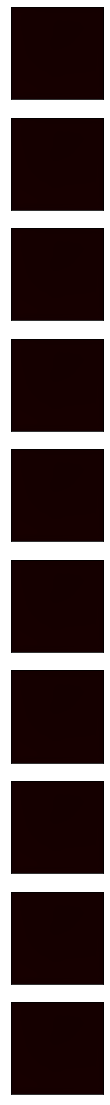

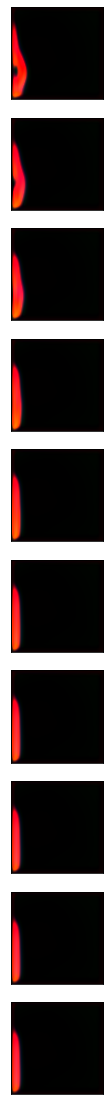

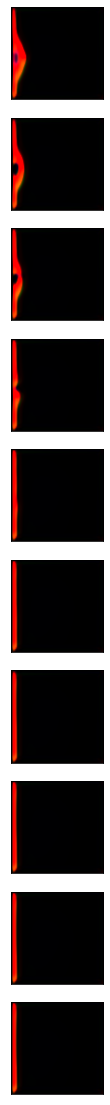

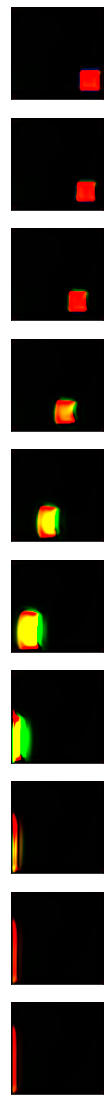

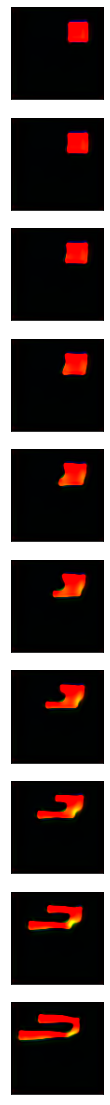

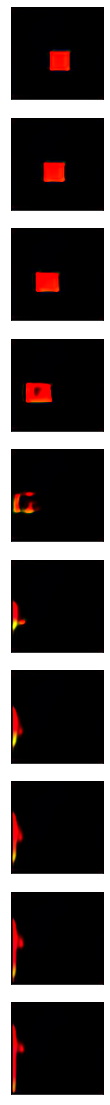

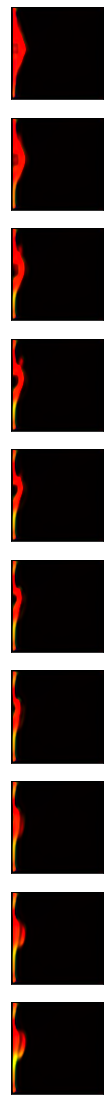

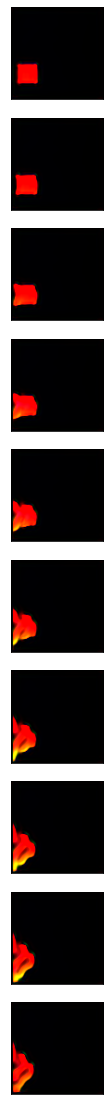

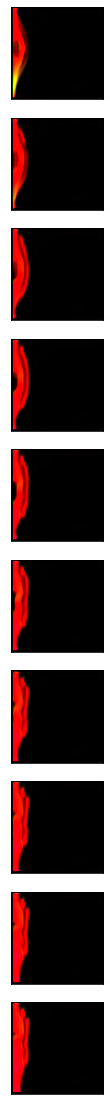

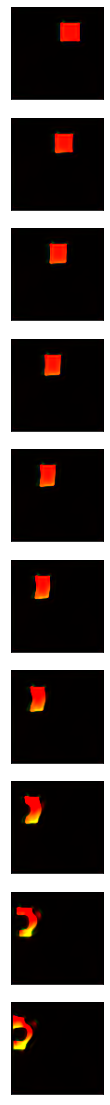

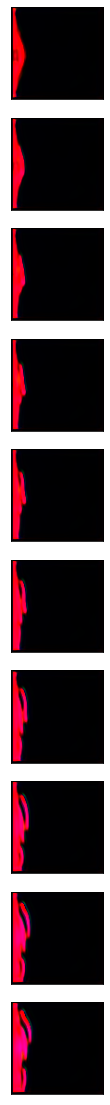

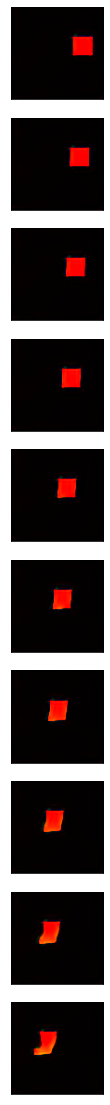

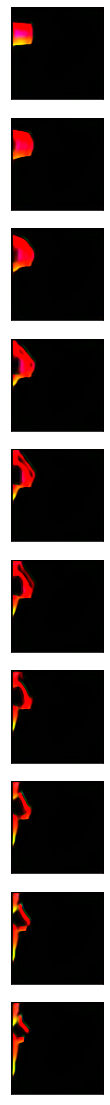

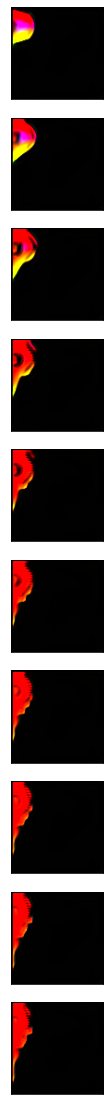

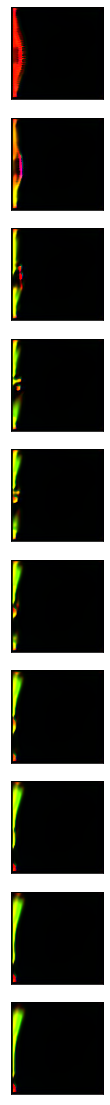

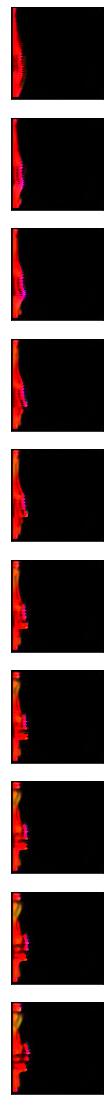

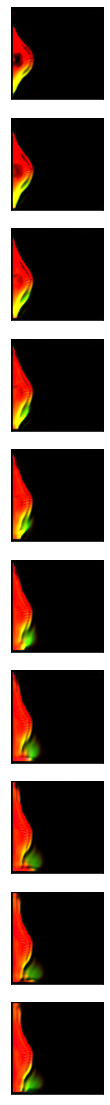

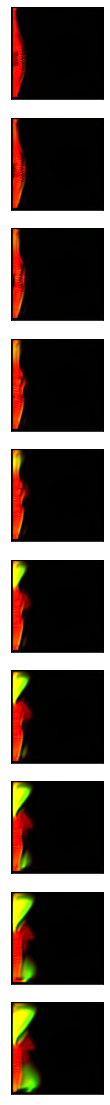

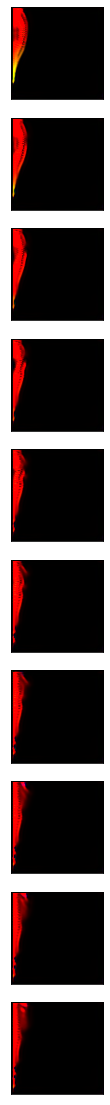

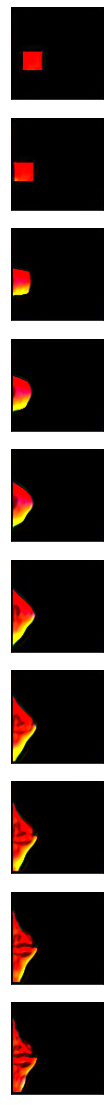

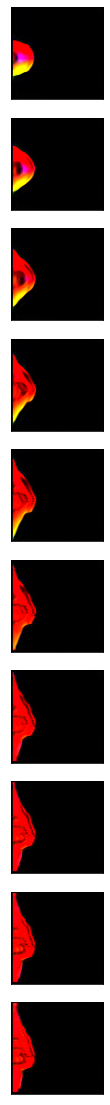

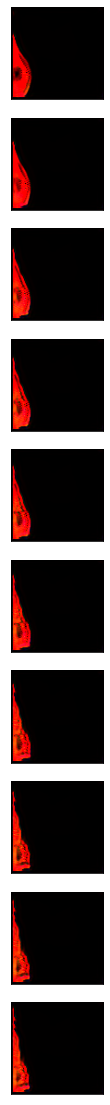

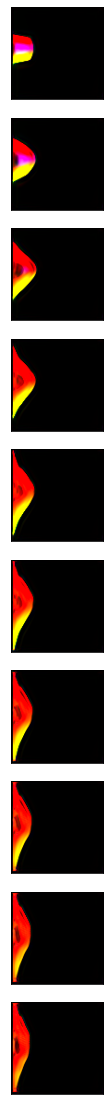

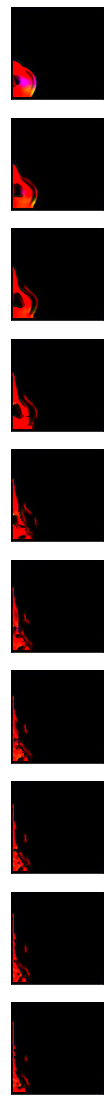

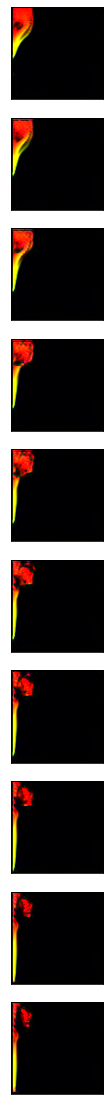

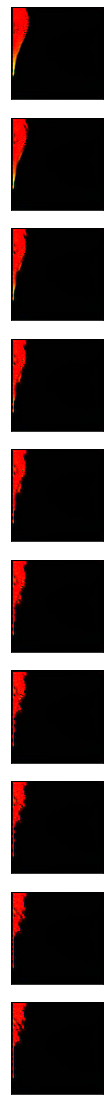

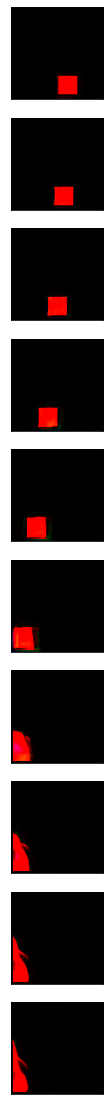

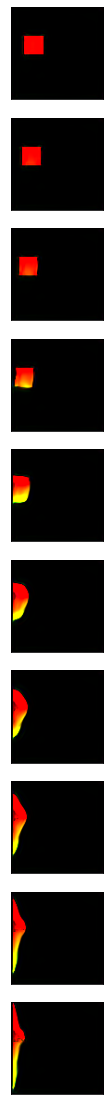

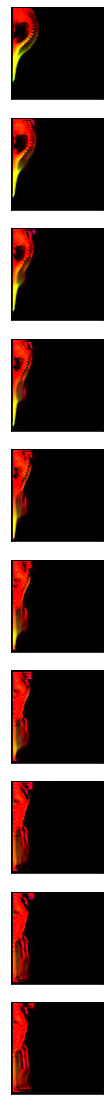

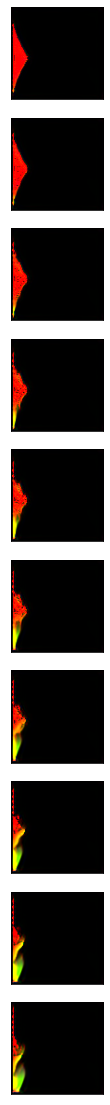

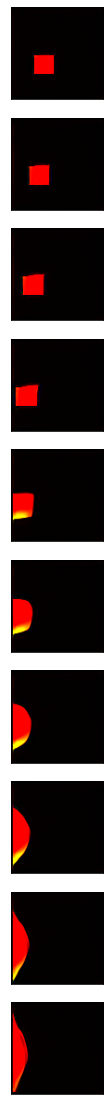

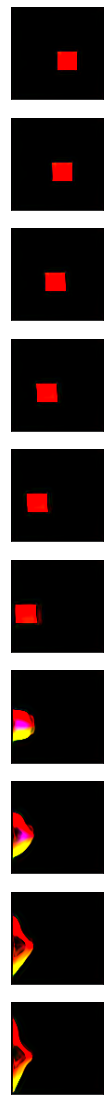

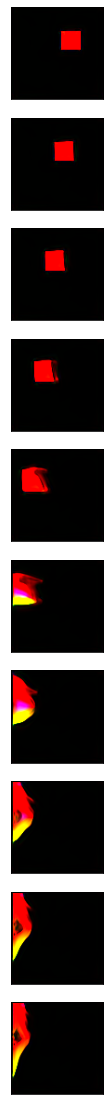

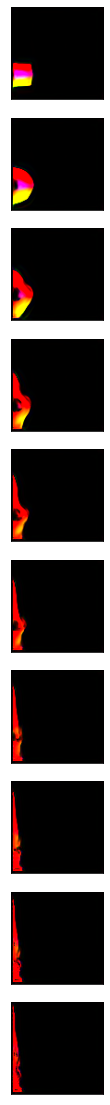

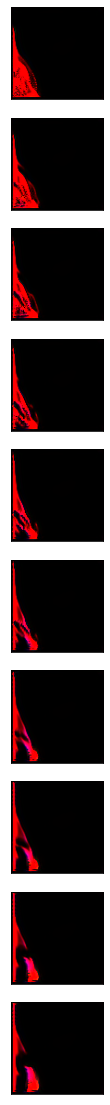

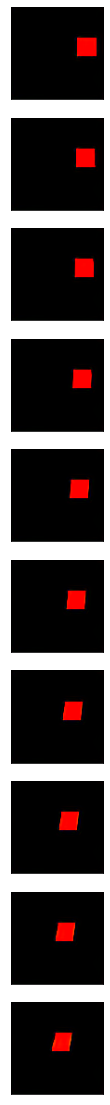

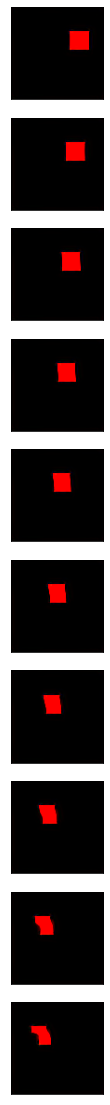

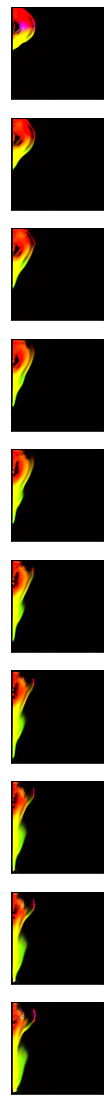

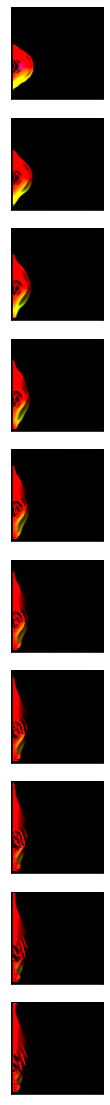

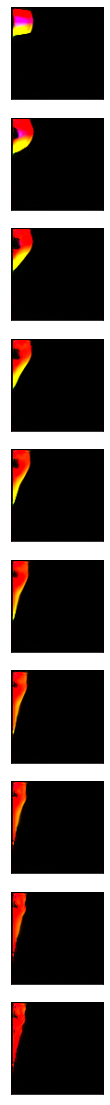

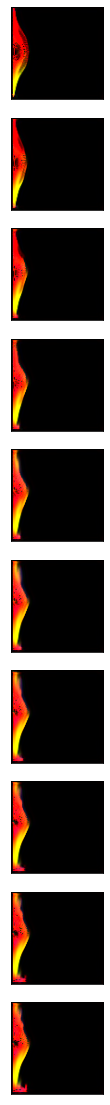

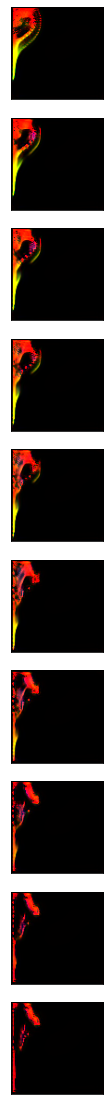

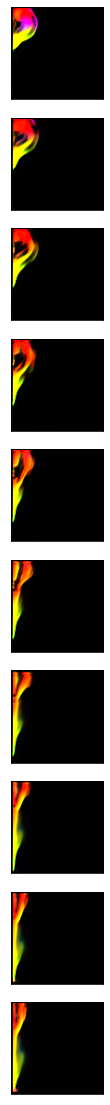

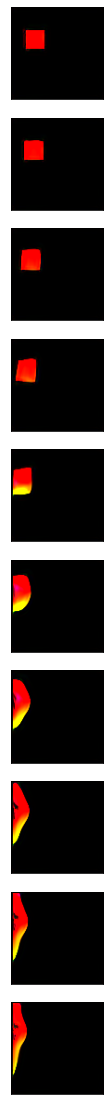

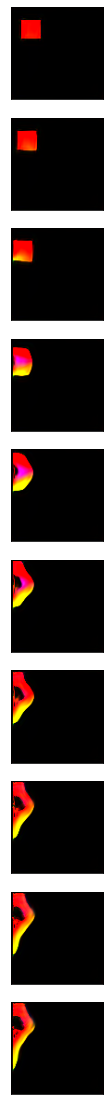

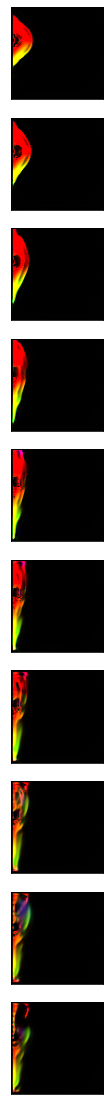

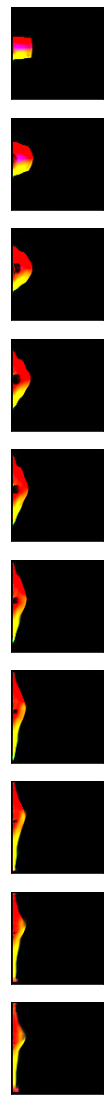

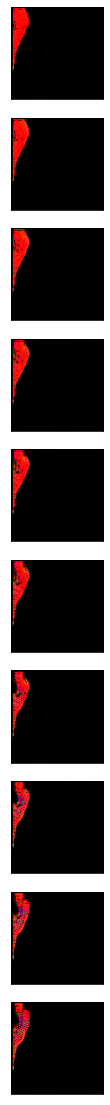

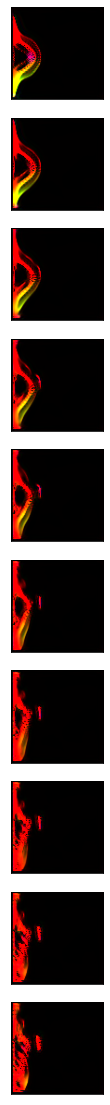

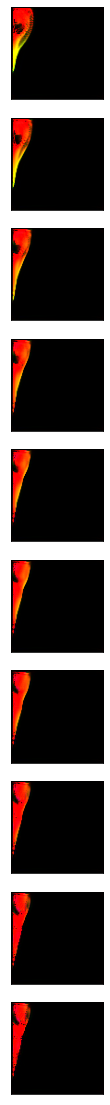

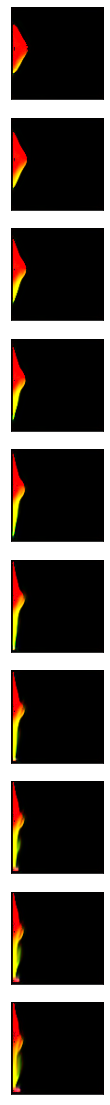

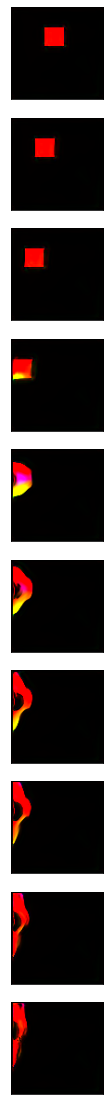

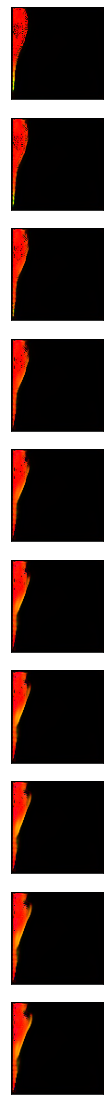

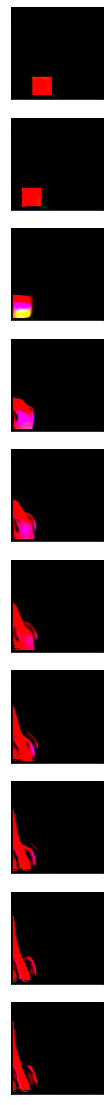

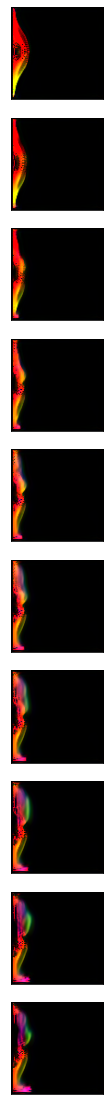

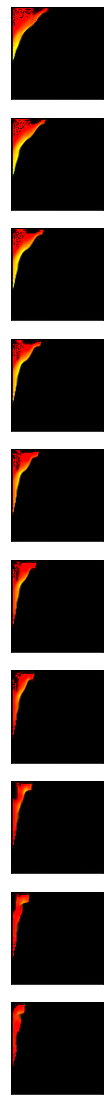

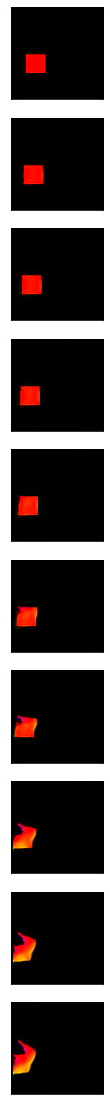

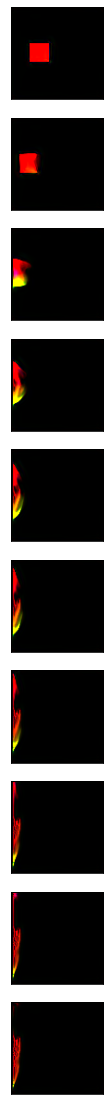

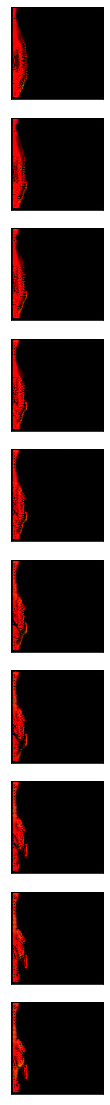

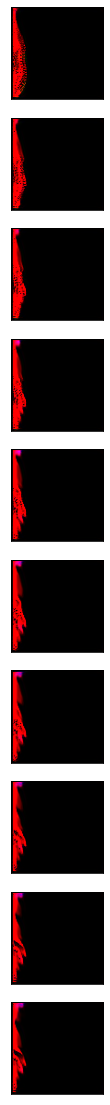

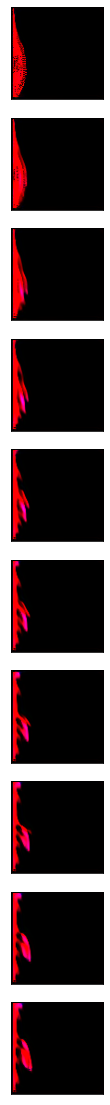

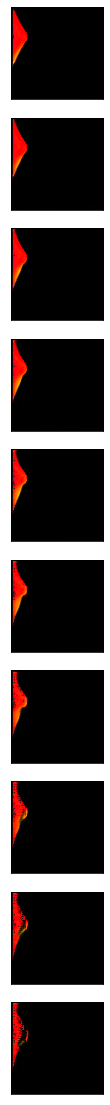

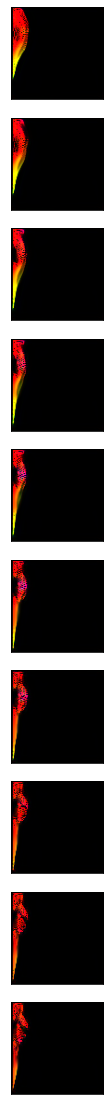

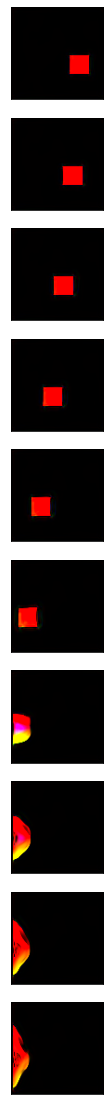

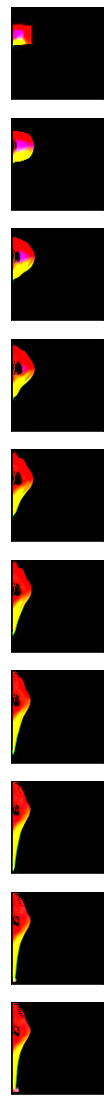

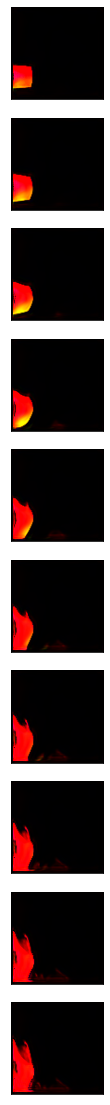

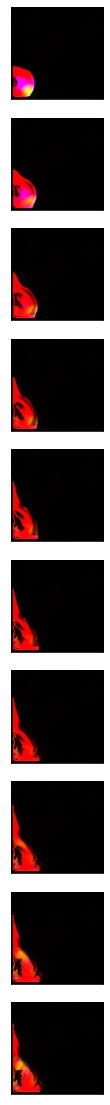

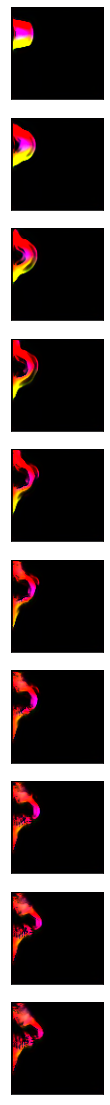

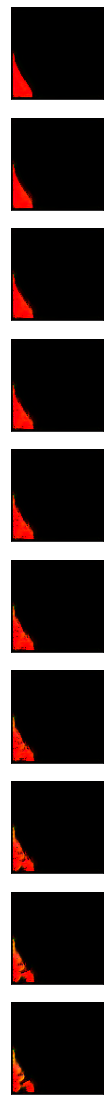

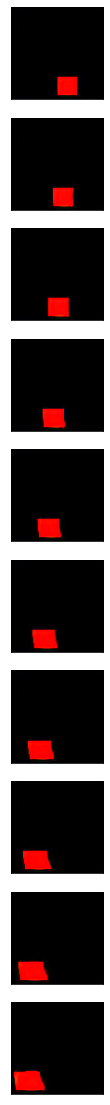

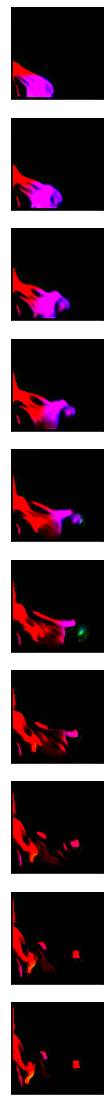

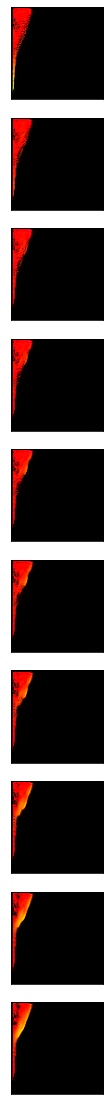

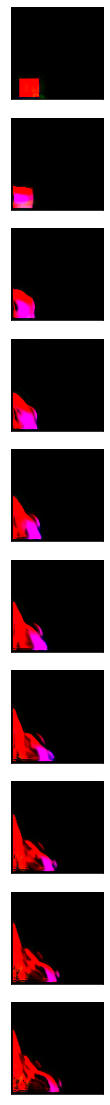

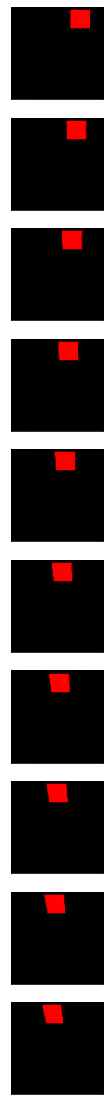

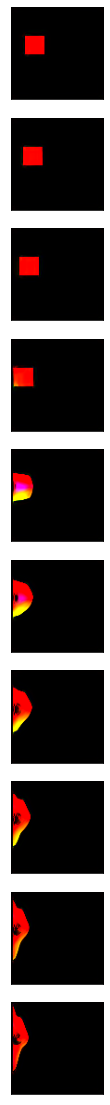

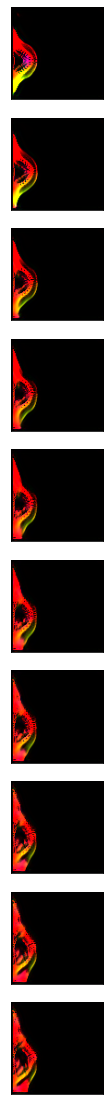

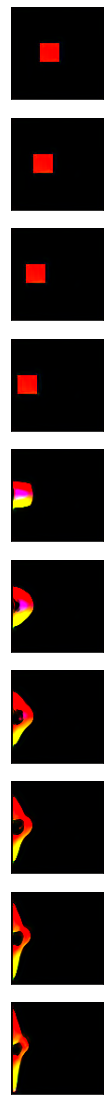

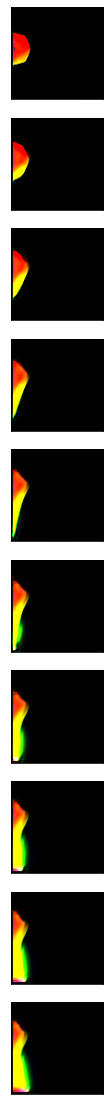

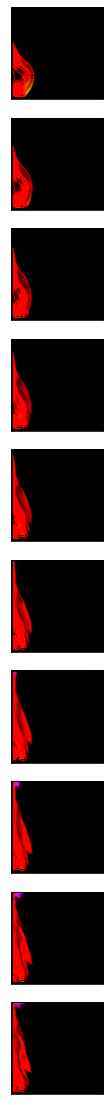

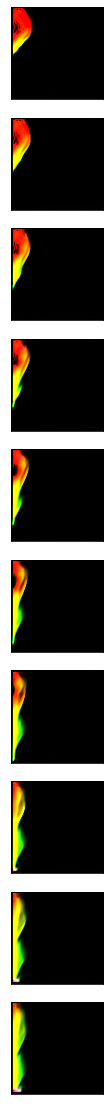

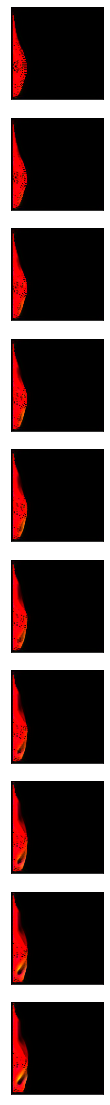

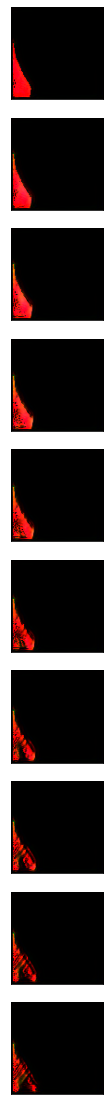

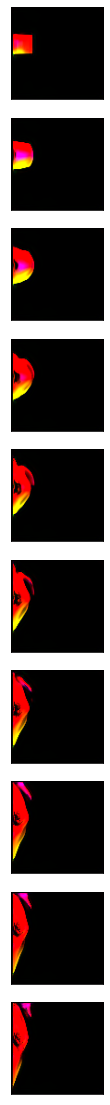

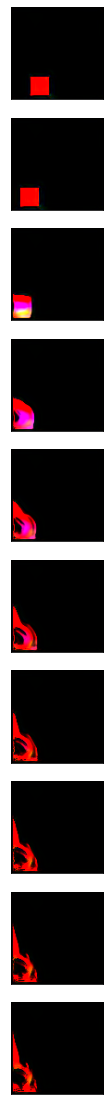

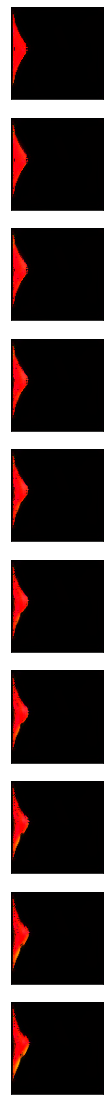

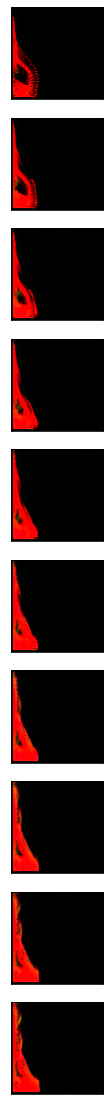

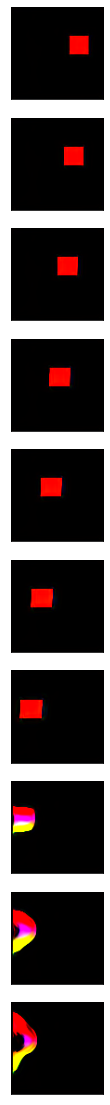

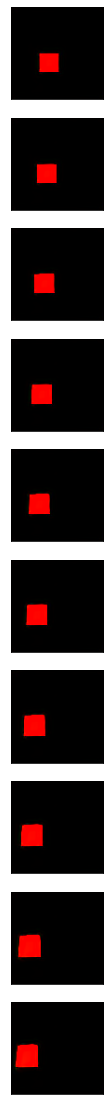

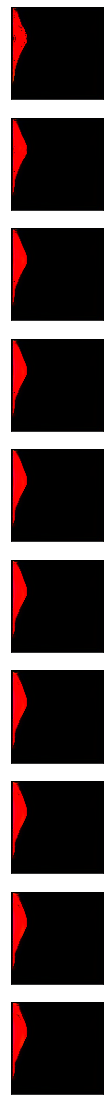

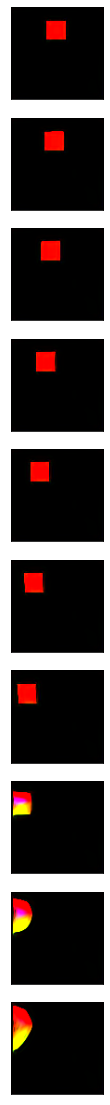

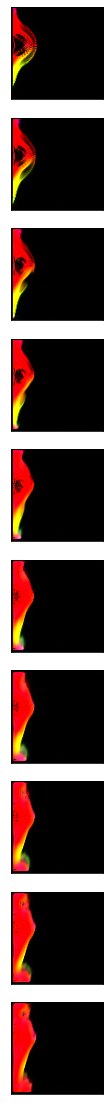

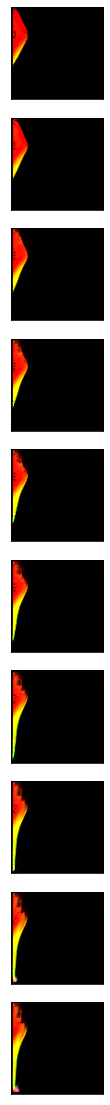

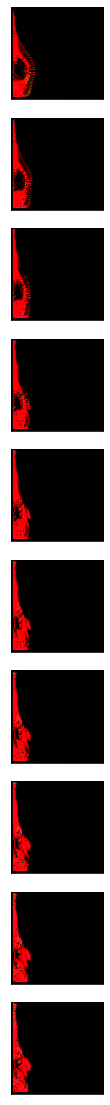

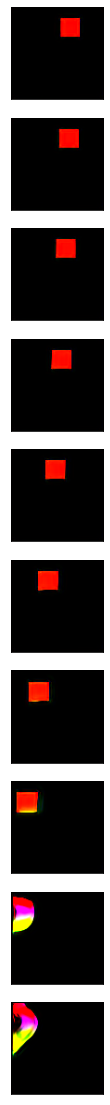

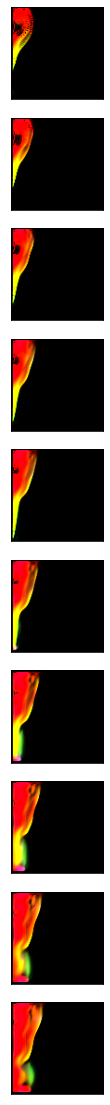

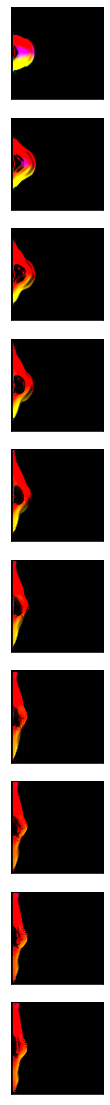

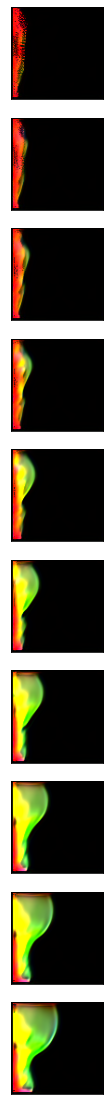

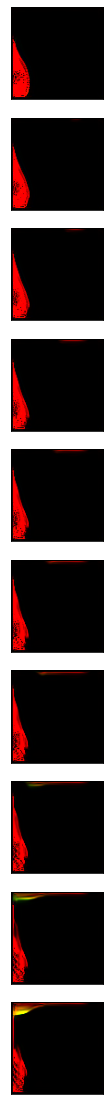

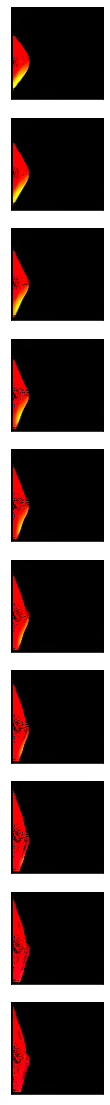

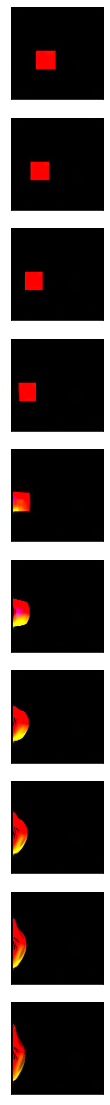

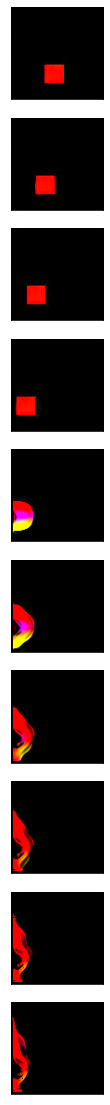

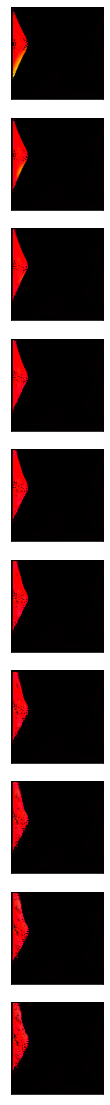

In [15]:
optimizer = torch.optim.Adam(model_origin.parameters(), lr=0.00005)

for epoch in range(1, epochs+1):
    epoch_loss = train(model=model_origin, discnet=netD, train_loader=trainloader, epochnow=epoch)
    print("[Epoch {}] loss:{}".format(epoch, epoch_loss))
    torch.save(model_origin.state_dict(), "../data/model/" + timestampStr + "/new_stepwise_ep{}.pt".format(epoch))
    torch.save(netD.state_dict(), "../data/model/" + timestampStr + "/new_discnet_ep{}.pt".format(epoch))

In [ ]:
plt.plot(loss_history)
plt.show()
torch.cuda.empty_cache()

In [ ]:
# torch.cuda.empty_cache()
# model_origin = StepAE().to(device)
# model_origin.load_state_dict(torch.load("cifar10.pt"))
model_origin.eval()